In [57]:
# Install dependency packges if you don't already have them

# !pip install requests beautifulsoup4
# !pip install pandas numpy
# !pip install xlrd
# !pip install --upgrade jupyter
# !pip install geopandas
# !pip install geodatasets
# !pip install shapely
# !pip install seaborn

In [58]:
import requests
import matplotlib as mpl
from bs4 import BeautifulSoup
import os
from urllib.parse import urljoin
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
# from shapely.geometry import Polygon
from matplotlib import cm
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

In [59]:
# get an object to represent the website contents

url = "https://www.census.gov/data/tables/time-series/demo/geographic-mobility/state-to-state-migration.html"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

In [60]:
import os

def find_repo_root(start_path):
    current_path = os.path.abspath(start_path)
    
    while True:
        # Check for the existence of the .git directory or other indicators
        if os.path.isdir(os.path.join(current_path, '.git')) or \
           os.path.isfile(os.path.join(current_path, 'README.md')):
            return current_path
        
        parent_path = os.path.dirname(current_path)
        
        # Stop if we reach the root directory
        if parent_path == current_path:
            break
        
        current_path = parent_path

    return None  # Return None if not found

root = find_repo_root(os.getcwd())
root

'c:\\Users\\fitsl\\Documents\\Programming\\UVM Programming Classes\\Data Science I\\Project'

In [61]:
## this puts everything into the "data" folder of your current directory. So only run this when you are in your root project directory.
## this is just commented out to save time

for link in soup.find_all('a'):
    href = link.get('href')
    if href and href.endswith('.xls'):
        xls_url = urljoin(url, href)
        print(f"Downloading: {xls_url}")  # Debug output
        xls_response = requests.get(xls_url)
        filename = os.path.join(root, 'Data', 'State', os.path.basename(xls_url))
        with open(filename, 'wb') as f:
            f.write(xls_response.content)
print("Downloaded all XLS files.")

In [62]:
def clean_acs_from_path(df_path):
    """
    Rename the columns in a ACS migration dataframe from excel. This does a lot of stuff:
        -removes header and footer (finds only cols starting with a US state name plus some other key ones)
        -renames and makes header all the state cols and leader cols (if there are any)

    Also make sure you have the states.txt file in your current directory. 

    :param df_path: the path to the xls file where the data is stored. make sure, if relative, you're starting in the right place
    :returns: a cleaned dataframe with col1 = where people currently lived, possibly some leader columns detailing the population of that state,
    and definitely two columns for every state showing where people moved from one year ago.
    """
    try:
        df = pd.read_excel(df_path, skiprows=6) #create the dataframe
        df.columns.values[0] = 'State'

        bad_col_list = [i for i in range(11, len(df.columns), 11)] ## every 11th column starting with 11th .. these are the copied "current residence" columns.
        df.drop(df.columns[bad_col_list], axis=1, inplace=True)

        new_names = [
            "Current Population",
            "Current Population MOE",
            "Same house 1 year ago",
            "Same house 1 year ago MOE",
            "Same state of residence 1 year ago",
            "Same state of residence 1 year ago MOE",
            "Total Inmigration",
            "Total Inmigration MOE"
        ]

        #not all of the sheets are formatted the same way so we have to wrap this in if else
        if df.columns.values[1] == "Unnamed: 1":
            # print("changing column values") #debug
            for i in range(len(new_names)):
                df.columns.values[i+1] = new_names[i]
        else:
            pass
        
        # get rid of all the rows not actually reflecting "states"
        # I have this saved in another txt file for easier editing
        with open("state_names.txt", "r") as f: 
            state_names = [line.strip() for line in f]

        df = df[df['State'].isin(state_names)] 

        # rename all the state sub columns (estimate v MOE)
        for state in state_names:
                if state in df.columns:
                    idx = df.columns.get_loc(state)
                    df.rename(columns={state: state, df.columns[idx + 1]: state + " MOE"}, inplace=True)


        df.replace(to_replace=r'.*N/A.*', value=np.nan, regex=True, inplace=True)
        return df
    except Exception as e:
        print(f"Error processing file {df_path}: {e}")
        return None

In [63]:
def acs_df_to_pure_state(df_inp):
    """
    Trims the frame so now all we have is the state column and then all the _inflow_ from other states

    :returns: a dataframe with 1st col state and all other columns 'colx' are estimates for how many people currently 
    in state used to live in colx. 
    """
    with open("state_names.txt", "r") as f: 
            state_names = [line.strip() for line in f]
    state_names.insert(0, "State") # we want our original identifying column
    df = df_inp.copy()
    df = df.filter(items=state_names)

    return df

In [64]:
# now we have our data downloaded, we explore the 2021 file:
df_path = f"{root}/Data/State/State_to_State_Migrations_Table_2016.xls"
df = clean_acs_from_path(df_path)
df_pure = acs_df_to_pure_state(df) 
df.head()

State  Current Population  Current Population MOE  \
2  United States2           319361956                   30974   
4         Alabama             4810126                    3913   
5          Alaska              731760                    1282   
6         Arizona             6851836                    4173   
7        Arkansas             2949650                    3135   

   Same house 1 year ago  Same house 1 year ago MOE  \
2              272660098                     208903   
4                4141850                      18249   
5                 593897                       7921   
6                5586753                      30225   
7                2484705                      17957   

   Same state of residence 1 year ago  Same state of residence 1 year ago MOE  \
2                            36952658                                  198593   
4                              529994                                   17409   
5                              100004                                    6403   
6                              938077                                   26500   
7                              384811                                   15832   

   Total Inmigration  Total Inmigration MOE  Alabama  ...  Wyoming  \
2            7552536                  73712  99892.0  ...  27184.0   
4             122220                   9811      NaN  ...    539.0   
5              31300                   3641    423.0  ...    291.0   
6             273257                  14805    894.0  ...    925.0   
7              71083                   6657   2057.0  ...    178.0   

   Wyoming MOE  Total.1  Total.1 MOE  Puerto Rico  Puerto Rico MOE  \
2       3871.0  2196664        37386      88676.0           7958.0   
4        691.0    16062         2720        335.0            214.0   
5        242.0     6559         1959        848.0           1059.0   
6        683.0    53749         6106       1462.0            917.0   
7        290.0     9051         1843        857.0            794.0   

   U.S. Island Area  U.S. Island Area MOE  Foreign Country  \
2             16060                  2338          2091928   
4               608                   479            15119   
5               350                   448             5361   
6               151                   253            52136   
7                 0                   197             8194   

   Foreign Country MOE  
2                36976  
4                 2741  
5                 1639  
6                 6088  
7                 1794  

[5 rows x 119 columns]

In [65]:
df.sort_values(by="Total Inmigration", ascending=False).head(11)

State  Current Population  Current Population MOE  \
2   United States2           319361956                   30974   
14         Florida            20401575                    7828   
60           Texas            27472626                   10409   
8       California            38783436                   10247   
48  North Carolina            10032407                    5350   
16         Georgia            10179860                    6234   
6          Arizona             6851836                    4173   
63        Virginia             8312297                    5430   
47        New York            19526443                    6611   
65      Washington             7202119                    4069   
54    Pennsylvania            12645493                    5619   

    Same house 1 year ago  Same house 1 year ago MOE  \
2               272660098                     208903   
14               17176492                      49542   
60               23105984                      50841   
8                33594813                      62303   
48                8460264                      33199   
16                8514847                      32855   
6                 5586753                      30225   
63                7008805                      27572   
47               17465164                      35945   
65                5924723                      30369   
54               11016361                      36704   

    Same state of residence 1 year ago  \
2                             36952658   
14                             2387227   
60                             3599897   
8                              4337251   
48                             1190972   
16                             1290632   
6                               938077   
63                              961003   
47                             1634487   
65                              958326   
54                             1308271   

    Same state of residence 1 year ago MOE  Total Inmigration  \
2                                   198593            7552536   
14                                   43437             605018   
60                                   48634             531996   
8                                    59356             514758   
48                                   27274             330896   
16                                   29551             305040   
6                                    26500             273257   
63                                   22934             264164   
47                                   32252             260723   
65                                   27224             257728   
54                                   34321             252060   

    Total Inmigration MOE  Alabama  ...  Wyoming  Wyoming MOE  Total.1  \
2                   73712  99892.0  ...  27184.0       3871.0  2196664   
14                  21606  11353.0  ...    454.0        351.0   232838   
60                  20183   6915.0  ...    732.0        486.0   234749   
8                   19678   3045.0  ...   2674.0       1596.0   336614   
48                  14462   3491.0  ...    145.0        175.0    50275   
16                  15456  18276.0  ...     22.0         37.0    69341   
6                   14805    894.0  ...    925.0        683.0    53749   
63                  11923   2424.0  ...     48.0         62.0    78325   
47                  11746    402.0  ...     83.0        103.0   166069   
65                  13383   1465.0  ...    866.0        517.0    61342   
54                  10750   1978.0  ...    188.0        211.0    68801   

    Total.1 MOE  Puerto Rico  Puerto Rico MOE  U.S. Island Area  \
2         37386      88676.0           7958.0             16060   
14        15743      24132.0           4560.0              1117   
60        13127       9246.0           2823.0               590   
8         13654       1102.0            682.0              3315   
48         5579       1631.0         

In [66]:
#commented out to save time; this takes a while and frankly is a little useless I think

# df_ind = df.set_index("State")
# sns.pairplot(df_ind)

Index(['State', 'Current Population', 'Current Population MOE',
       'Same house 1 year ago', 'Same house 1 year ago MOE',
       'Same state of residence 1 year ago',
       'Same state of residence 1 year ago MOE', 'Total Inmigration',
       'Total Inmigration MOE', 'Alabama',
       ...
       'Wyoming', 'Wyoming MOE', 'Total.1', 'Total.1 MOE', 'Puerto Rico',
       'Puerto Rico MOE', 'U.S. Island Area', 'U.S. Island Area MOE',
       'Foreign Country', 'Foreign Country MOE'],
      dtype='object', length=119)

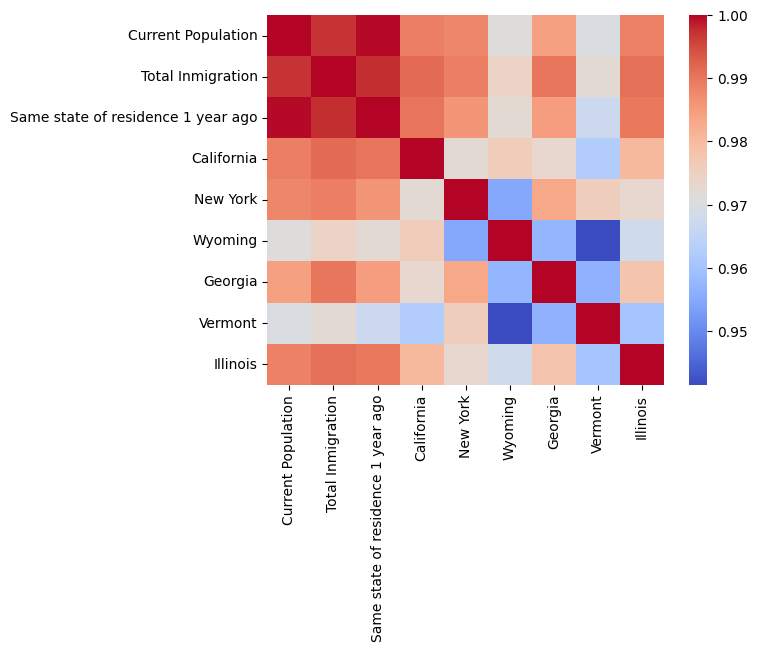

In [67]:
#seems like maybe there is a link between current population and inmigration. mess around with a correlation heat map...
df_ind = df.set_index("State")
df_ind = df_ind[['Current Population', 'Total Inmigration', 'Same state of residence 1 year ago', 'California', 'New York', 'Wyoming', 'Georgia', 'Vermont', 'Illinois' ]]
corr_mat = df_ind.corr()
sns.heatmap(corr_mat, cmap='coolwarm')

df.columns
# this seems weird. all the correlations are very high. 
# I guess the more people are coming to your state from X, the more they are from Y, pretty much regardless??

In [68]:
df.head()

State  Current Population  Current Population MOE  \
2  United States2           319361956                   30974   
4         Alabama             4810126                    3913   
5          Alaska              731760                    1282   
6         Arizona             6851836                    4173   
7        Arkansas             2949650                    3135   

   Same house 1 year ago  Same house 1 year ago MOE  \
2              272660098                     208903   
4                4141850                      18249   
5                 593897                       7921   
6                5586753                      30225   
7                2484705                      17957   

   Same state of residence 1 year ago  Same state of residence 1 year ago MOE  \
2                            36952658                                  198593   
4                              529994                                   17409   
5                              100004                                    6403   
6                              938077                                   26500   
7                              384811                                   15832   

   Total Inmigration  Total Inmigration MOE  Alabama  ...  Wyoming  \
2            7552536                  73712  99892.0  ...  27184.0   
4             122220                   9811      NaN  ...    539.0   
5              31300                   3641    423.0  ...    291.0   
6             273257                  14805    894.0  ...    925.0   
7              71083                   6657   2057.0  ...    178.0   

   Wyoming MOE  Total.1  Total.1 MOE  Puerto Rico  Puerto Rico MOE  \
2       3871.0  2196664        37386      88676.0           7958.0   
4        691.0    16062         2720        335.0            214.0   
5        242.0     6559         1959        848.0           1059.0   
6        683.0    53749         6106       1462.0            917.0   
7        290.0     9051         1843        857.0            794.0   

   U.S. Island Area  U.S. Island Area MOE  Foreign Country  \
2             16060                  2338          2091928   
4               608                   479            15119   
5               350                   448             5361   
6               151                   253            52136   
7                 0                   197             8194   

   Foreign Country MOE  
2                36976  
4                 2741  
5                 1639  
6                 6088  
7                 1794  

[5 rows x 119 columns]

In [69]:
#create a new column to see where most people are coming from.
df_ind = df.set_index("State").drop(columns="Total.1")

#define these separately so they dont count for eachother 
inflow_max  = df_ind.idxmax(axis=1)
inflow_max_values = df_ind.max(axis=1)
total_inflow = df_ind.sum(axis=1)

outflow_max = df_ind.drop("United States2").idxmax(axis=0)
outflow_max_values = df_ind.drop("United States2").max(axis=0)
total_outflow = df_ind.drop("United States2").sum(axis=0)

df_ind['inflow_max'] = inflow_max
df_ind['inflow_max_val'] =inflow_max_values
df_ind['total_inflow'] = total_inflow


df_ind['outflow_max_val']= outflow_max_values
df_ind['outflow_max'] = outflow_max
df_ind['total_outflow'] = total_outflow

df_ind

Current Population  Current Population MOE  \
State                                                        
United States2           319361956                   30974   
Alabama                    4810126                    3913   
Alaska                      731760                    1282   
Arizona                    6851836                    4173   
Arkansas                   2949650                    3135   
California                38783436                   10247   
Colorado                   5476928                    3255   
Connecticut                3541758                    2975   
Delaware                    942073                    1325   
Florida                   20401575                    7828   
Georgia                   10179860                    6234   
Hawaii                     1410258                    1894   
Idaho                      1663756                    2007   
Illinois                  12654142                    5822   
Indiana                    6554084                    4241   
Iowa                       3097283                    2760   
Kansas                     2870529                    2533   
Kentucky                   4385213                    2955   
Louisiana                  4622042                    3291   
Maine                      1319292                    1668   
Maryland                   5949566                    4278   
Massachusetts              6745441                    3674   
Michigan                   9813772                    4749   
Minnesota                  5455904                    2872   
Mississippi                2951081                    3274   
Missouri                   6022165                    4040   
Montana                    1032794                    1223   
Nebraska                   1882987                    1995   
Nevada                     2907243                    2819   
New Hampshire              1322101                    1298   
New Jersey                 8852286                    5371   
New Mexico                 2057857                    2689   
New York                  19526443                    6611   
North Carolina            10032407                    5350   
North Dakota                746271                    1202   
Ohio                      11481752                    4551   
Oklahoma                   3873232                    2534   
Oregon                     4052221                    3173   
Pennsylvania              12645493                    5619   
Rhode Island               1045691                    1810   
South Carolina             4903788                    3376   
South Dakota                853832                    1413   
Tennessee                  6580953                    4457   
Texas                     27472626                   10409   
Utah                       3002244                    3318   
Vermont                     619387                     803   
Virginia                   8312297                    5430   
Washington                 7202119                    4069   
West Virginia              1810709                    2337   
Wisconsin                  5712104                    3128   
Wyoming                     577567                    1366   
Puerto Rico                3384760                    2761   

                Same house 1 year ago  Same house 1 year ago MOE  \
State                                                              
United States2              272660098                     208903   
Alabama                       4141850                      18249   
Alaska                         593897                       7921   
Arizona                       5586753                      30225   
Arkansas                      2484705                      17957   
California                   33594813                      62303   
Colorado                      4466067                      27786   
Connecticut                   3116440                  

In [70]:
df_ind.reset_index("State", inplace=True)
gdf = gpd.read_file(f"{root}/Data/Shapefiles/States_GeoData")
gdf = gdf.merge(df_ind, left_on='NAME', right_on='State')
gdf.head()

STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  ... U.S. Island Area  \
0  MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ...  ...                0   
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  ...               47   
2  POLYGON ((-103.00256 36.52659, -103.00219 36.6...  ...              484   
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  ...              559   
4  POLYGON ((-82.6432 38.16909, -82.643 38.16956,...  ...                0   

   U.S. Island Area MOE  Foreign Country  Foreign Country MOE  \
0                   213             4942                 1201   
1                   102            48597                 5493   
2                   543            14228                 2840   
3                   555            75765                 6271   
4                   193             3630                 1109   

           inflow_max  inflow_max_val  total_inflow  outflow_max_val  \
0  Current Population       2951081.0     6046838.0           8825.0   
1  Current Population      10032407.0    20571206.0          30447.0   
2  Current Population       3873232.0     7930302.0          30532.0   
3  Current Population       8312297.0    17044506.0          35641.0   
4  Current Population       1810709.0     3723417.0           8726.0   

      outflow_max  total_outflow  
0           Texas        77285.0  
1  South Carolina       255238.0  
2           Texas       105583.0  
3  North Carolina       265891.0  
4            Ohio        51180.0  

[5 rows x 134 columns]

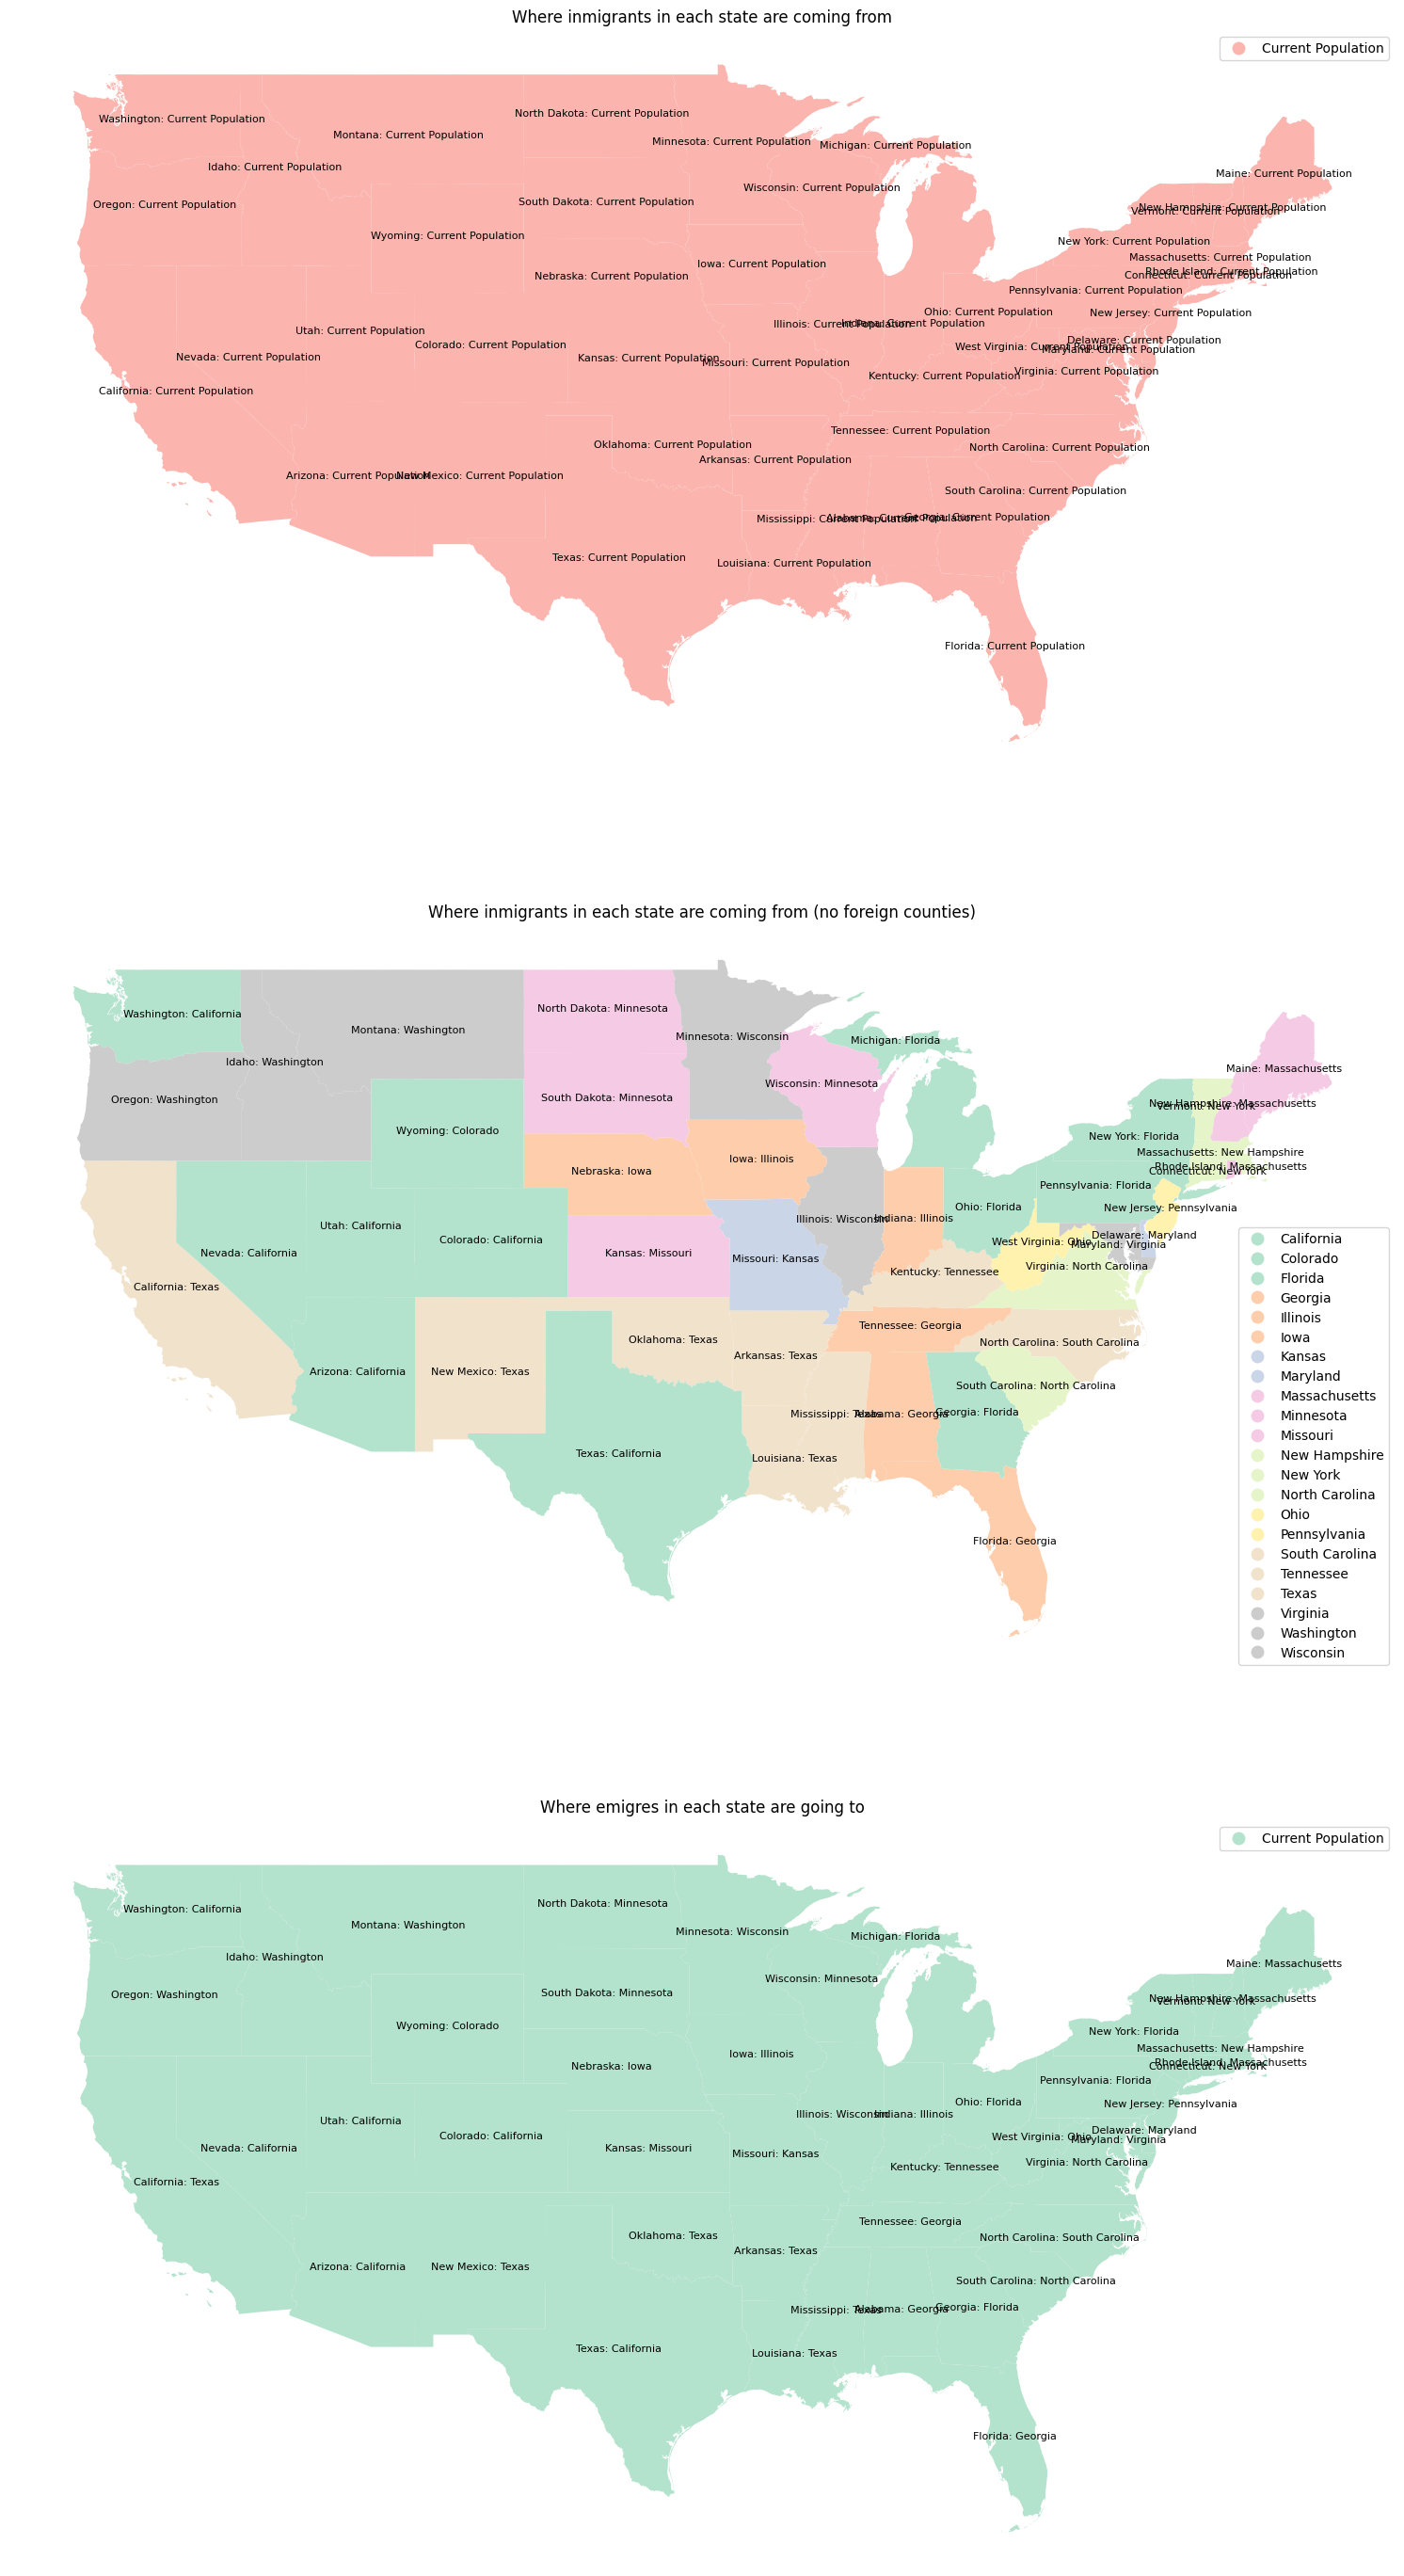

In [71]:
visframe = gdf.to_crs('EPSG:4326')
visframe = visframe[~visframe.State.isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico'])] 
## just the continental. Note that the four non-continental are among the 
# most important to consider here... I'm just not that good at mapping to get them in



# create figure and axes for with Matplotlib for main map
fig, axes = plt.subplots(3, figsize=(40, 35))
# remove the axis box from the axes
axes = axes.flatten()
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')


#plot 1 has inflow max
visframe.plot(column='inflow_max', legend=True, ax=axes[0], cmap='Pastel1')
unique_categories = visframe['inflow_max'].unique()
colors = cm.magma(np.linspace(0, 1, len(unique_categories)))
category_color_map = dict(zip(unique_categories, colors))

#add names on plot itself for clarity
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['inflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        
        #  # Get the corresponding color for the category
        # color = category_color_map[num]
        
        # # Convert RGBA to grayscale to determine brightness
        # brightness = 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]
        
        # # Choose text color based on brightness
        # text_color = '#00FFFF' if brightness < 0.5 else 'black'
        
        # Add the text to the plot
        axes[0].text(point.x, point.y, label, fontsize=8, ha='center', color='black')



visframe.drop(columns='Foreign Country').plot(column='inflow_max', legend=True, ax=axes[2], cmap='Pastel2')
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['outflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        axes[1].text(point.x, point.y, label, fontsize=8, ha='center', color='black')


#pllot three has outflow max 
visframe.plot(column='outflow_max', legend=True, ax=axes[1], cmap='Pastel2')

#add names on plot itself for clarity
for geom, state, num in zip(visframe.geometry, visframe['State'], visframe['outflow_max']):
    if num is not None:  # Check if the value is not NaN
        point = geom.representative_point()
        label = f"{state}: {num}"
        axes[2].text(point.x, point.y, label, fontsize=8, ha='center',  color='black')

# set titles
axes[0].set_title("Where inmigrants in each state are coming from")
axes[1].set_title("Where inmigrants in each state are coming from (no foreign counties)")
axes[2].set_title("Where emigres in each state are going to")


plt.savefig(f"{root}/Figures/State EDA/in_out_migration_plot_bystate_2021")

In [72]:
# create a per capita dataframe (to use across all)

# now we're interested in per capita data, so we have to wrangle those...
def df_read_state_pop_xls(path, years):
    """
    Given a path to an state population in census format and a range of years, return a merged dataframe of states
    and population value for each year. 
    """
    df = pd.read_excel(path, skiprows=3)
    df.columns.values[0] = 'State'
    df['State'] = df['State'].str.replace('.', '', regex=False)

    # get rid of any filler rows
    with open("state_names.txt", "r") as f: 
                state_names = [line.strip() for line in f]
    df = df[df['State'].isin(state_names)] 

    #  get rid of any filler columns
    years.insert(0, "State")
    df = df[years]
    df.columns = df.columns.map(str)
    return df

df_2000s = df_read_state_pop_xls(f"{root}/Data/State Population Data/2000_2009_statepopulation.xls", [year for year in range(2000,2010)])
df_2010s = df_read_state_pop_xls(f"{root}/Data/State Population Data/2010_2019_statepopulation.xlsx", list(range(2010, 2020)))
df_2020s = df_read_state_pop_xls(f"{root}/Data/State Population Data/2020_2023_statepopulation.xlsx", list(range(2020, 2024)))


df_state_pops = df_2000s.merge(df_2010s, on='State').merge(df_2020s, on='State')
df_state_pops[['State', '2006']]

State        2006
0                Alabama   4628981.0
1                 Alaska    675302.0
2                Arizona   6029141.0
3               Arkansas   2821761.0
4             California  36021202.0
5               Colorado   4720423.0
6            Connecticut   3517460.0
7               Delaware    859268.0
8   District of Columbia    570681.0
9                Florida  18166990.0
10               Georgia   9155813.0
11                Hawaii   1309731.0
12                 Idaho   1468669.0
13              Illinois  12643955.0
14               Indiana   6332669.0
15                  Iowa   2982644.0
16                Kansas   2762931.0
17              Kentucky   4219239.0
18             Louisiana   4302665.0
19                 Maine   1323619.0
20              Maryland   5627367.0
21         Massachusetts   6410084.0
22              Michigan  10036081.0
23             Minnesota   5163555.0
24           Mississippi   2904978.0
25              Missouri   5842704.0
26               Montana    952692.0
27              Nebraska   1772693.0
28                Nevada   2522658.0
29         New Hampshire   1308389.0
30            New Jersey   8661679.0
31            New Mexico   1962137.0
32              New York  19104631.0
33        North Carolina   8917270.0
34          North Dakota    649422.0
35                  Ohio  11481213.0
36              Oklahoma   3594090.0
37                Oregon   3670883.0
38          Pennsylvania  12510809.0
39          Rhode Island   1063096.0
40        South Carolina   4357847.0
41          South Dakota    783033.0
42             Tennessee   6088766.0
43                 Texas  23359580.0
44                  Utah   2525507.0
45               Vermont    622892.0
46              Virginia   7673725.0
47            Washington   6370753.0
48         West Virginia   1827912.0
49             Wisconsin   5577655.0
50               Wyoming    522667.0
51           Puerto Rico   3805214.0

In [73]:
def merge_state_pop(df, year, state_pops=df_state_pops):
    year = str(year)
    year_pop = df_state_pops.copy()
    year_pop = year_pop[['State',  year]]
    df = df.merge(year_pop, on='State', how='outer')
    return df


df_path = f"{root}/data/state/State_to_State_Migrations_Table_2006.xls"
# plot_three_states(df_path)
df = clean_acs_from_path(df_path)
df = acs_df_to_pure_state(df)
df = merge_state_pop(df, 2006)
df


# year_pop = df_state_pops.copy()
# year_pop = year_pop[['State', '2006']]
# df = df.merge(year_pop, on='State', how='outer')
# df 


State    Alaska   Alabama  Arkansas   Arizona  California  \
0                Alabama     392.0  593683.0    1811.0    1304.0      5984.0   
1                 Alaska  102086.0     751.0     503.0    1190.0      3353.0   
2                Arizona    3715.0    1805.0    1163.0  935748.0     85497.0   
3               Arkansas     751.0    2678.0  416998.0    4212.0      9141.0   
4             California    6376.0    4133.0    3709.0   31915.0   5173950.0   
5               Colorado    1821.0    1285.0     893.0   13714.0     34803.0   
6            Connecticut       0.0     496.0       0.0     262.0      2727.0   
7               Delaware       0.0       0.0     204.0      55.0       325.0   
8   District of Columbia       NaN       NaN       NaN       NaN         NaN   
9                Florida    4995.0   13015.0    3232.0    6030.0     27658.0   
10               Georgia    2232.0   14873.0    2851.0    5024.0     24662.0   
11                Hawaii    2906.0     332.0       0.0    1718.0     14459.0   
12                 Idaho     995.0     170.0     225.0    3178.0     13537.0   
13              Illinois    1742.0    1286.0    2309.0    5924.0     15322.0   
14               Indiana     130.0    1551.0    1201.0    2434.0      7374.0   
15                  Iowa     109.0     740.0     675.0    1702.0      6764.0   
16                Kansas     412.0     938.0    2495.0    1695.0      8150.0   
17              Kentucky     187.0    3863.0    1076.0    1049.0      5461.0   
18             Louisiana     152.0    2581.0    2486.0     235.0      5286.0   
19                 Maine     220.0      80.0      38.0     164.0      1123.0   
20              Maryland     183.0    1486.0     116.0    1504.0     10194.0   
21         Massachusetts    1531.0     364.0     443.0    1404.0     11605.0   
22              Michigan    1363.0    2181.0    1313.0    2602.0      9623.0   
23             Minnesota    1241.0     249.0     166.0    3315.0      9997.0   
24           Mississippi      77.0    5924.0    2508.0     659.0      2747.0   
25              Missouri    1389.0    2106.0    8100.0    3053.0     12491.0   
26               Montana     281.0     588.0       0.0    1867.0      3460.0   
27              Nebraska     514.0     124.0     365.0    1238.0      5170.0   
28                Nevada    1669.0     260.0     668.0    6618.0     59811.0   
29         New Hampshire     488.0      76.0     164.0     779.0      1907.0   
30            New Jersey     379.0     658.0     208.0    2138.0      7910.0   
31            New Mexico    1066.0    1207.0     393.0    8173.0      8210.0   
32              New York    2513.0     812.0     331.0    3761.0     23126.0   
33        North Carolina     997.0    2497.0    1648.0    3920.0     17613.0   
34          North Dakota     147.0      77.0      50.0     833.0      1460.0   
35                  Ohio     745.0    1834.0    1260.0    4530.0     11098.0   
36              Oklahoma    1304.0     513.0    7936.0    4549.0      8947.0   
37                Oregon    1422.0      42.0     420.0    8078.0     51295.0   
38          Pennsylvania    1501.0    1410.0    1153.0    2405.0     10789.0   
39           Puerto Rico       0.0       0.0       0.0      38.0      1210.0   
40          Rhode Island     106.0      98.0       0.0     844.0      1824.0   
41        South Carolina    1317.0    4779.0     229.0    2265.0      4096.0   
42          South Dakota     116.0       0.0     190.0     923.0      1536.0   
43             Tennessee     445.0    7438.0    3598.0    3087.0     10721.0   
44                 Texas    4910.0    8736.0   14725.0   18641.0     81572.0   
45                  Utah     605.0     723.0     247.0    7495.0     24994.0   
46               Vermont       0.0      17.0      66.0     455.0       554.0   
47              Virginia    4116.0    3379.0    1061.0    3286.0     18797.0   
48            Washington    4161.0     547.0     944.0    9879.0     53034.0   
49         West Vir

In [74]:
def add_calc_columns(df, year=False, state_pops=False):
    """
    Intake a puredf (just state vs. state) and output a frame with inmigration and emigration columns
    """
    year = str(year)
    if "Total.1" in df.columns: #eg the newer fancier sheets
        df = df.drop(columns="Total.1")
    df = df[df['State'] != 'United States2'] #remove people who came from 'the US'... why would I care...

    df = df.set_index("State")

    # remove any 'migration to alabama from alabama' type cells
    with open("state_names.txt", "r") as f: 
        state_names = [line.strip() for line in f]
    for state in state_names:
        if (state in df.columns) & (state in df.index):
            df.loc[state, state] = None 


    inflow_max  = df.idxmax(axis=1)
    total_inflow = df.sum(axis=1)
    outflow_max  = df.idxmax(axis=0)
    total_outflow = df.sum(axis=0)
    if 'Foreign Country' in df.columns:
        inflow_max_noforeign = df.drop(columns='Foreign Country').idxmax(axis=1)
        total_inflow_noforeign = df.drop(columns='Foreign Country').sum(axis=1)
    else: 
        inflow_max_noforeign = None
        total_inflow_noforeign = None


    
    df['inflow_max'] = inflow_max
    df['outflow_max'] = outflow_max
    df['inflow_max_noforeign'] = inflow_max_noforeign
    df['total_inflow_noforeign'] = total_inflow_noforeign
    df['total_inflow'] = total_inflow
    df['total_outflow'] = total_outflow
    

    df = df.reset_index("State")
    if year is not None and state_pops is not None :
        df = merge_state_pop(df, year)

    df['per_capita_inflow'] = df['total_inflow'] / df[year] 
    df['per_capita_outflow'] = df['total_outflow'] / df[year] 

    df['per_capita_inflow_noforeign'] = None
    if 'Foreign Country' in df.columns:
        df['per_capita_inflow_noforeign'] = df['total_inflow_noforeign'] / df[year] 

    df['net_per_capita_flow'] = df['per_capita_inflow']  - df['per_capita_outflow']
    df['net_flow'] = df['total_inflow'] - df['total_outflow']
    return df

In [75]:
def add_abbr_statecols(df, cols):
    path = f"{root}/Code/Cleaning/State Cleaning/statecode_data.csv"
    state_abbrs = pd.read_csv(path)
    df = df.merge(
        state_abbrs,
        on='State',
        how = 'left',
    )
    state_dict = df.set_index('State')['abbreviation'].to_dict()
    df.drop(columns=['regex', 'abbreviation'], inplace=True)
    for col in cols:
        new_name = f"{col}_abbr"
        df[new_name] = df[col].map(lambda x : state_dict.get(x, "Foreign"))
    return df

In [76]:
df_path = f"{root}/data/state/State_to_State_Migrations_Table_2006.xls"
# plot_three_states(df_path)
df = clean_acs_from_path(df_path)
df = acs_df_to_pure_state(df)
df = add_calc_columns(df, '2006', df_state_pops)
df = add_abbr_statecols(df, ['State', 'inflow_max', 'outflow_max'])
df.head()

State  Alaska  Alabama  Arkansas  Arizona  California  Colorado  \
0     Alabama   392.0      NaN    1811.0   1304.0      5984.0    1158.0   
1      Alaska     NaN    751.0     503.0   1190.0      3353.0     968.0   
2     Arizona  3715.0   1805.0    1163.0      NaN     85497.0    7030.0   
3    Arkansas   751.0   2678.0       NaN   4212.0      9141.0    1766.0   
4  California  6376.0   4133.0    3709.0  31915.0         NaN   15885.0   

   Connecticut  Delaware  Florida  ...  total_outflow        2006  \
0        213.0     392.0  19258.0  ...       101626.0   4628981.0   
1        498.0       0.0    940.0  ...        63115.0    675302.0   
2       1392.0     589.0   7667.0  ...       193407.0   6029141.0   
3         50.0      88.0   3666.0  ...        75886.0   2821761.0   
4       5596.0    1339.0  27196.0  ...       744004.0  36021202.0   

   per_capita_inflow  per_capita_outflow  per_capita_inflow_noforeign  \
0           0.029775            0.021954                         None   
1           0.055785            0.093462                         None   
2           0.047655            0.032079                         None   
3           0.037772            0.026893                         None   
4           0.014502            0.020655                         None   

   net_per_capita_flow  net_flow  State_abbr  inflow_max_abbr  \
0             0.007821   36201.0          AL               GA   
1            -0.037676  -25443.0          AK               WA   
2             0.015577   93913.0          AZ               CA   
3             0.010879   30697.0          AR               TX   
4            -0.006153 -221640.0          CA               TX   

   outflow_max_abbr  
0                GA  
1                CA  
2                CA  
3                TX  
4                AZ  

[5 rows x 67 columns]

In [77]:
def geo_match(df, folder, lefton, righton):
    """
    Takes a dataframe and returns a geodataframe with attached geo data from the folder.
    Merges the two based on lefton and righton having the same values. lefton=geodata, righton=df_col
    """
    gdf = gpd.read_file(folder)
    gdf = gdf.merge(df, left_on=lefton, right_on=righton)
    return gdf


In [78]:
def plot_name_cols_geo(visframe, cmap_, xcol, ycol, ax_, hue_col=None, drop_cols=None, going=False, verbose=True):
    """
    Plot geo-data with "xcol : ycol" on each different shape.

    :param visframe: the geopandas frame to plot from
    :param cmap_: the color map to encode the shapes with (according to ycol)
    :param xcol: the variable to print but not encode
    :param ycol: the variable to print and encode
    :param ax_: the matplotlib axis to put it on. For subplotting in one figure.

    :returns: Nothing. just prints. 

    """
    ax_.axis("off")
    visframe.plot(column=hue_col, ax=ax_, cmap=cmap_)
    
    if verbose:
        for geom, x, y in zip(visframe.geometry, visframe[xcol], visframe[ycol]):
            if y is not None:  # Check if the value is not NaN so that we don't try to text untextable things
                point = geom.representative_point()
                if going:            label = f"{x} -> {y}"
                else: label = f"{x} <-  {y}" 
                ax_.text(point.x, point.y, label, fontsize=8, ha='center', color='black')

    if hue_col:
        #Make the range of colros
        norm = mpl.colors.Normalize(vmin=visframe[hue_col].min(), vmax=visframe[hue_col].max())
        sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm) 
        cbar = plt.colorbar(sm, ax=ax_)

         
         #Make the ticks
        min_tick = visframe[hue_col].min()
        max_tick = visframe[hue_col].max()
        ticks = np.linspace(min_tick, max_tick, num=10) 


        #Customize the legend
        cbar.set_label('Per Capita flow')
        cbar.set_ticks(ticks)  # dynamic ticks
        cbar.set_ticklabels([f"{tick:.0f}" for tick in ticks])  



In [79]:
def plot_three_states(data_path, save_path=None, show=None):
    name, _ = os.path.splitext(data_path)
    year = name.split('_')[-1]
    df = clean_acs_from_path(data_path)
    df = acs_df_to_pure_state(df)
    df = add_calc_columns(df, year, df_state_pops)
    df = add_abbr_statecols(df, ['State', 'inflow_max', 'outflow_max', 'inflow_max_noforeign'])
    gdf = geo_match(df, f"{root}/Data/Shapefiles/States_GeoData", lefton="NAME", righton="State")

    visframe = gdf.to_crs('EPSG:4326')
    visframe = visframe[~visframe.State.isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico', 'United States2'])]
    if 'Foreign Country' in visframe.columns: 
        fig, axes = plt.subplots(3, figsize=(25, 30))
    else:
        fig, axes = plt.subplots(2, figsize=(25, 30))
    # remove the axis box from the axes
    axes = axes.flatten()
    plot_name_cols_geo(visframe, 'summer', xcol='State_abbr', ycol='inflow_max_abbr', hue_col='per_capita_inflow', ax_=axes[0])
    if 'Foreign Country' in visframe.columns:
        plot_name_cols_geo(visframe, 'summer', xcol='State_abbr', ycol='inflow_max_noforeign_abbr', hue_col='per_capita_inflow_noforeign', ax_=axes[1])
    plot_name_cols_geo(visframe, 'summer', xcol='State_abbr', ycol='outflow_max_abbr', hue_col='per_capita_outflow', ax_=axes[-1], going=True)
    axes[0].set_title(f"{year} Where inmigrants in each state are coming from")
    axes[1].set_title(f"{year} Where inmigrants in each state are coming from (no foreign countries)")
    axes[-1].set_title(f"{year} Where emigres from each state are going to")
    if show:
        plt.show()
    if save_path:
        plt.savefig(save_path)

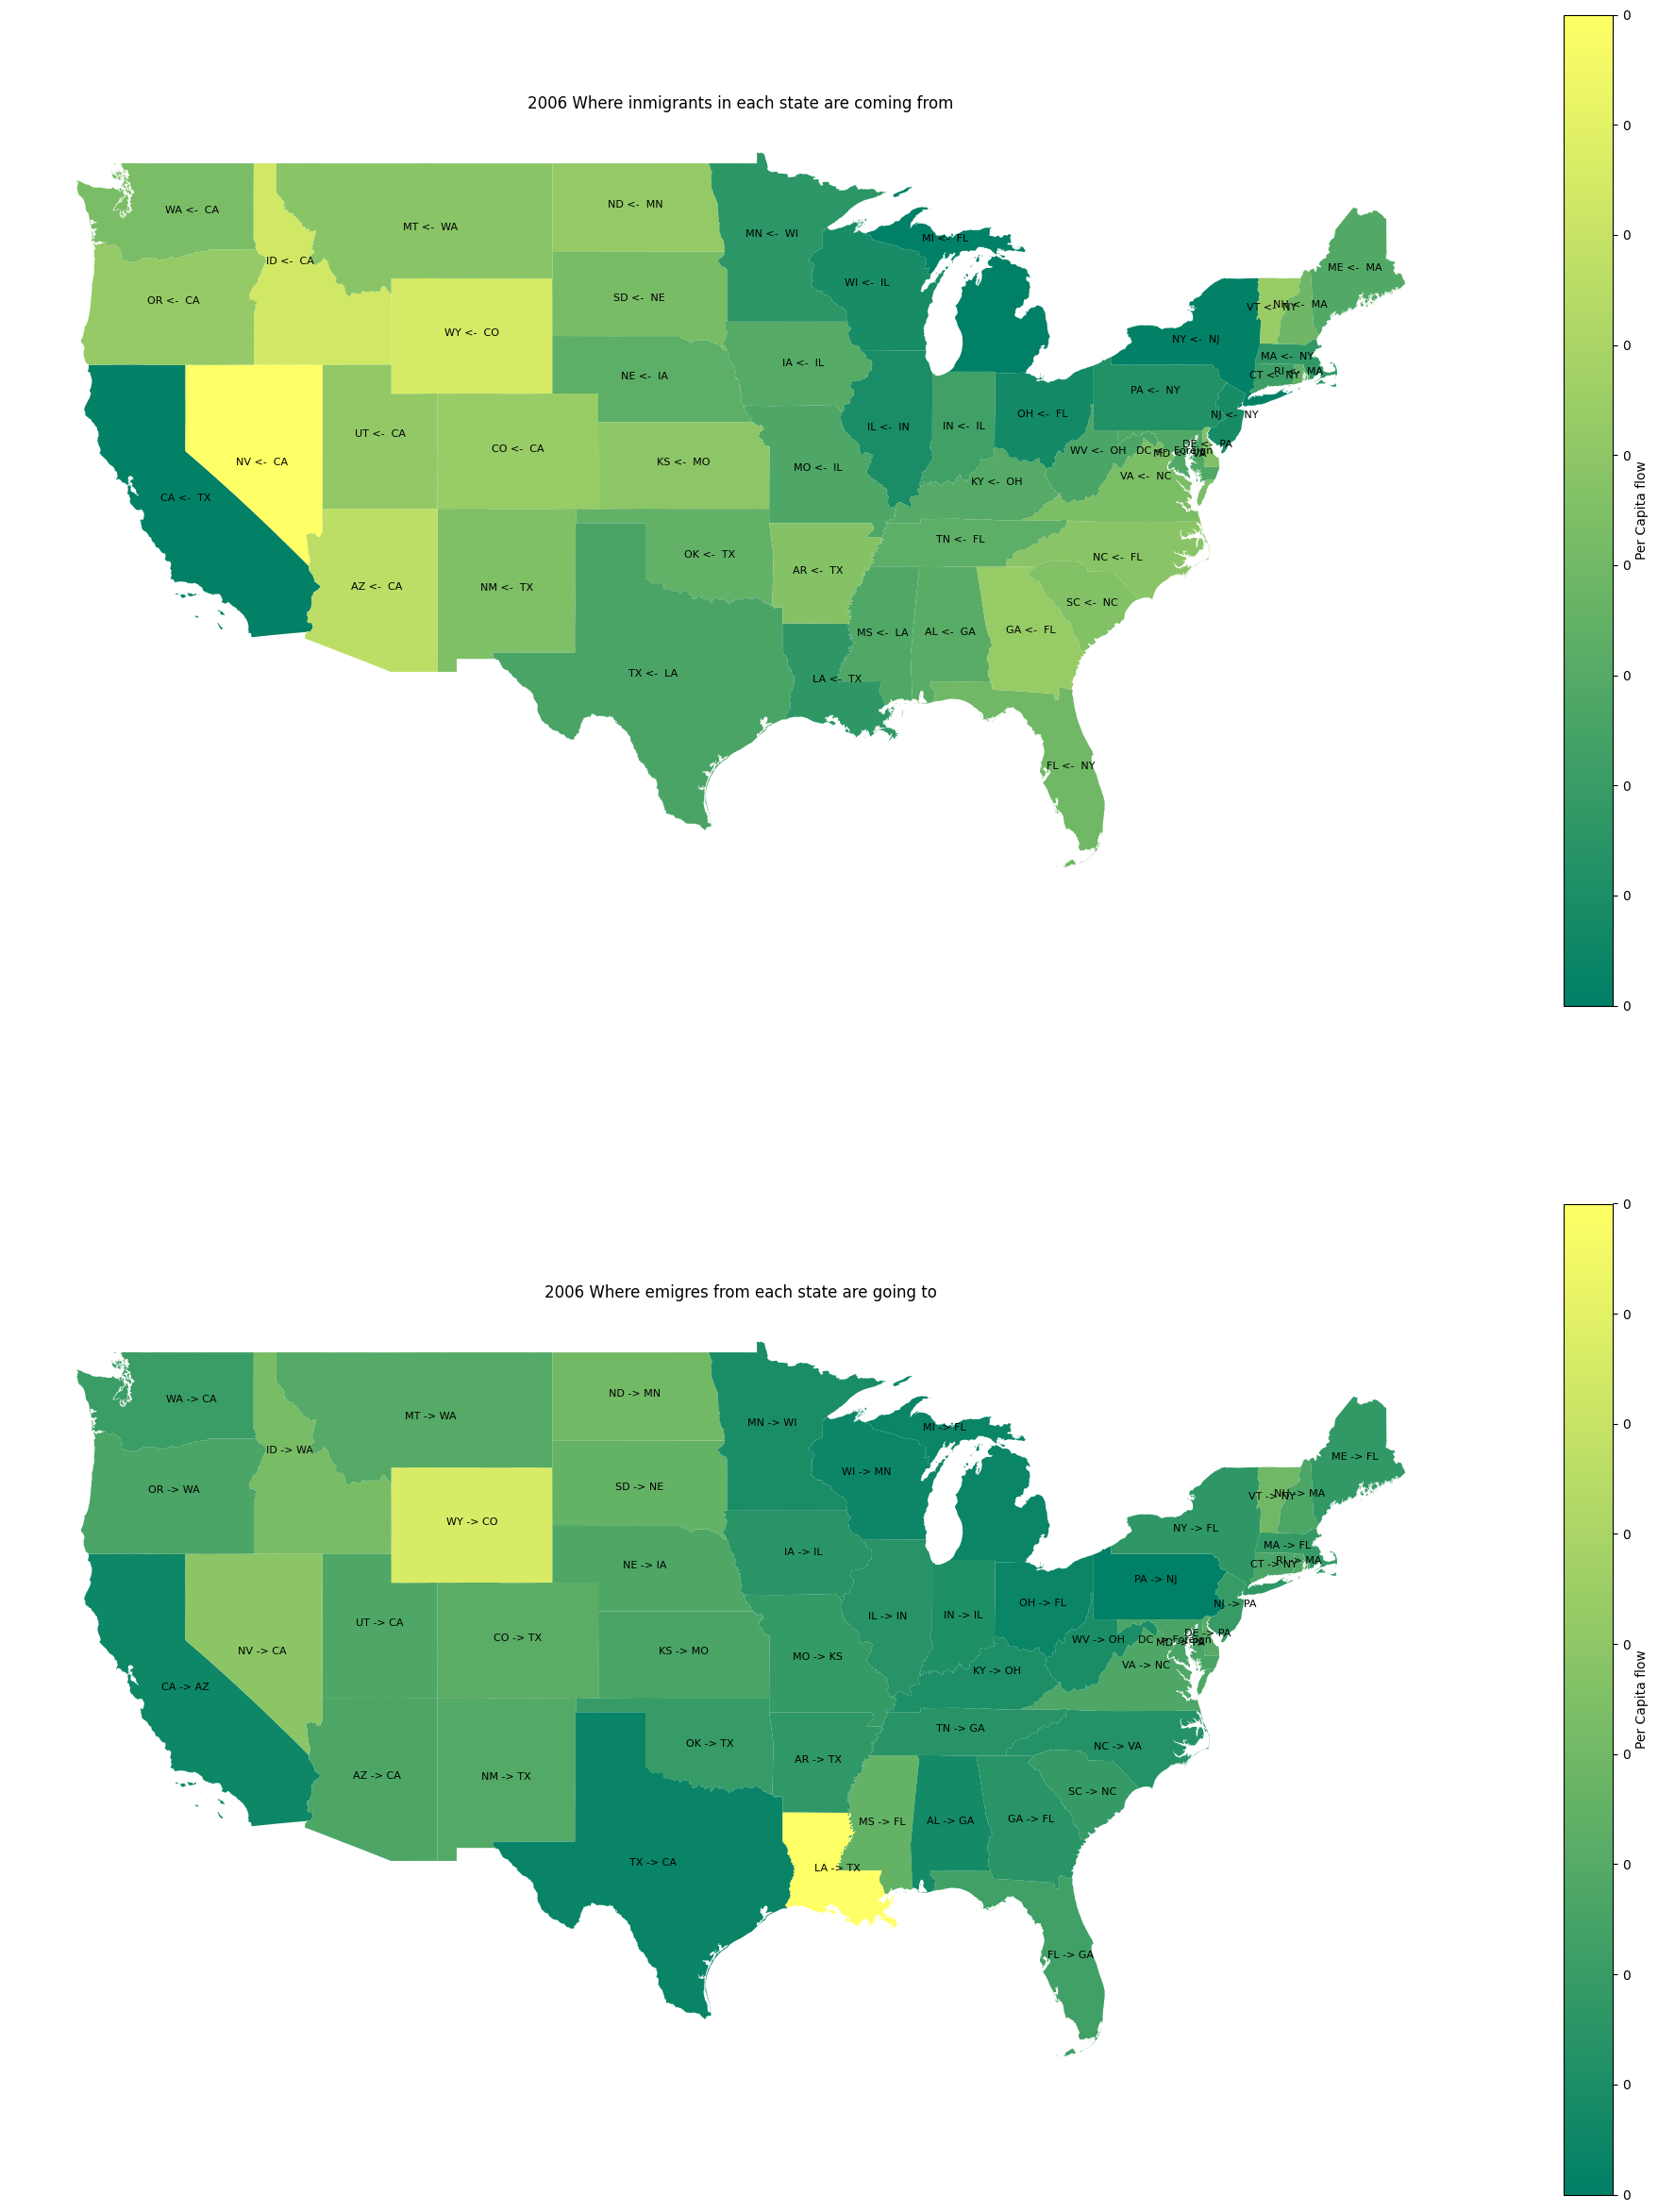

In [80]:
df_path = f"{root}/data/state/State_to_State_Migrations_Table_2006.xls"
plot_three_states(data_path=df_path)

In [81]:
df_path = f"{root}/data/state/State_to_State_Migrations_Table_2006.xls"
# plot_three_states(df_path)
df = clean_acs_from_path(df_path)
df = acs_df_to_pure_state(df)
df = merge_state_pop(df, '2006', df_state_pops)

In [82]:
# for filename in os.listdir(f"{root}/Data/State"):
#     if filename.endswith('.xls'):
#         print(f"processing {filename}")
#         name, _ = os.path.splitext(filename)
#         year = name.split('_')[-1]
#         data_path = f"{root}/Data/State/{filename}"
#         save_path = f"{root}/Figures/State EDA/Per Capita Heatmap/{year} Per Capita Heatmaps_with_abbrev.png"
#         plot_three_states(data_path, save_path)

In [83]:
def plot_heat(data_path, save_path=None, show=None):
    name, _ = os.path.splitext(data_path)
    year = name.split('_')[-1]
    df = clean_acs_from_path(data_path)
    df = acs_df_to_pure_state(df)
    df = add_calc_columns(df, year, df_state_pops)
    df = add_abbr_statecols(df, ['State', 'inflow_max', 'outflow_max', 'inflow_max_noforeign'])
    gdf = geo_match(df, f"{root}/Data/Shapefiles/States_GeoData", lefton="NAME", righton="State")

    visframe = gdf.to_crs('EPSG:4326')
    visframe = visframe[~visframe['State'].isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico', 'United States2'])]
    fig, axes = plt.subplots(2, figsize=(25, 30))
    plot_name_cols_geo(visframe, 'summer', ycol="inflow_max", xcol='State_abbr', hue_col='net_flow', ax_= axes[0], verbose=False)
    plot_name_cols_geo(visframe, 'summer', ycol="inflow_max", xcol='State_abbr', hue_col='net_per_capita_flow', ax_= axes[1], verbose=False)
   
    axes[0].set_title(f"{year} Gross Net Flow by State")
    axes[1].set_title(f"{year} Per Capita Net Migration Flow by State")
   
    if show:
        plt.show()
    if save_path:
        plt.savefig(save_path)

processing state_to_state_migrations_table_2005.xls
processing state_to_state_migrations_table_2005_2007.xls
processing state_to_state_migrations_table_2005_2009.xls
processing state_to_state_migrations_table_2006.xls
processing state_to_state_migrations_table_2006_2008.xls
processing state_to_state_migrations_table_2007.xls
processing state_to_state_migrations_table_2007_2009.xls
processing state_to_state_migrations_table_2008.xls
processing state_to_state_migrations_table_2009.xls
processing state_to_state_migrations_table_2010.xls
processing state_to_state_migrations_table_2011.xls
processing state_to_state_migrations_table_2012.xls
processing state_to_state_migrations_table_2013.xls
processing State_to_State_Migrations_Table_2014.xls
processing State_to_State_Migrations_Table_2015.xls
processing State_to_State_Migrations_Table_2016.xls
processing State_to_State_Migrations_Table_2017.xls
processing State_to_State_Migrations_Table_2018.xls
processing State_to_State_Migrations_Table_2

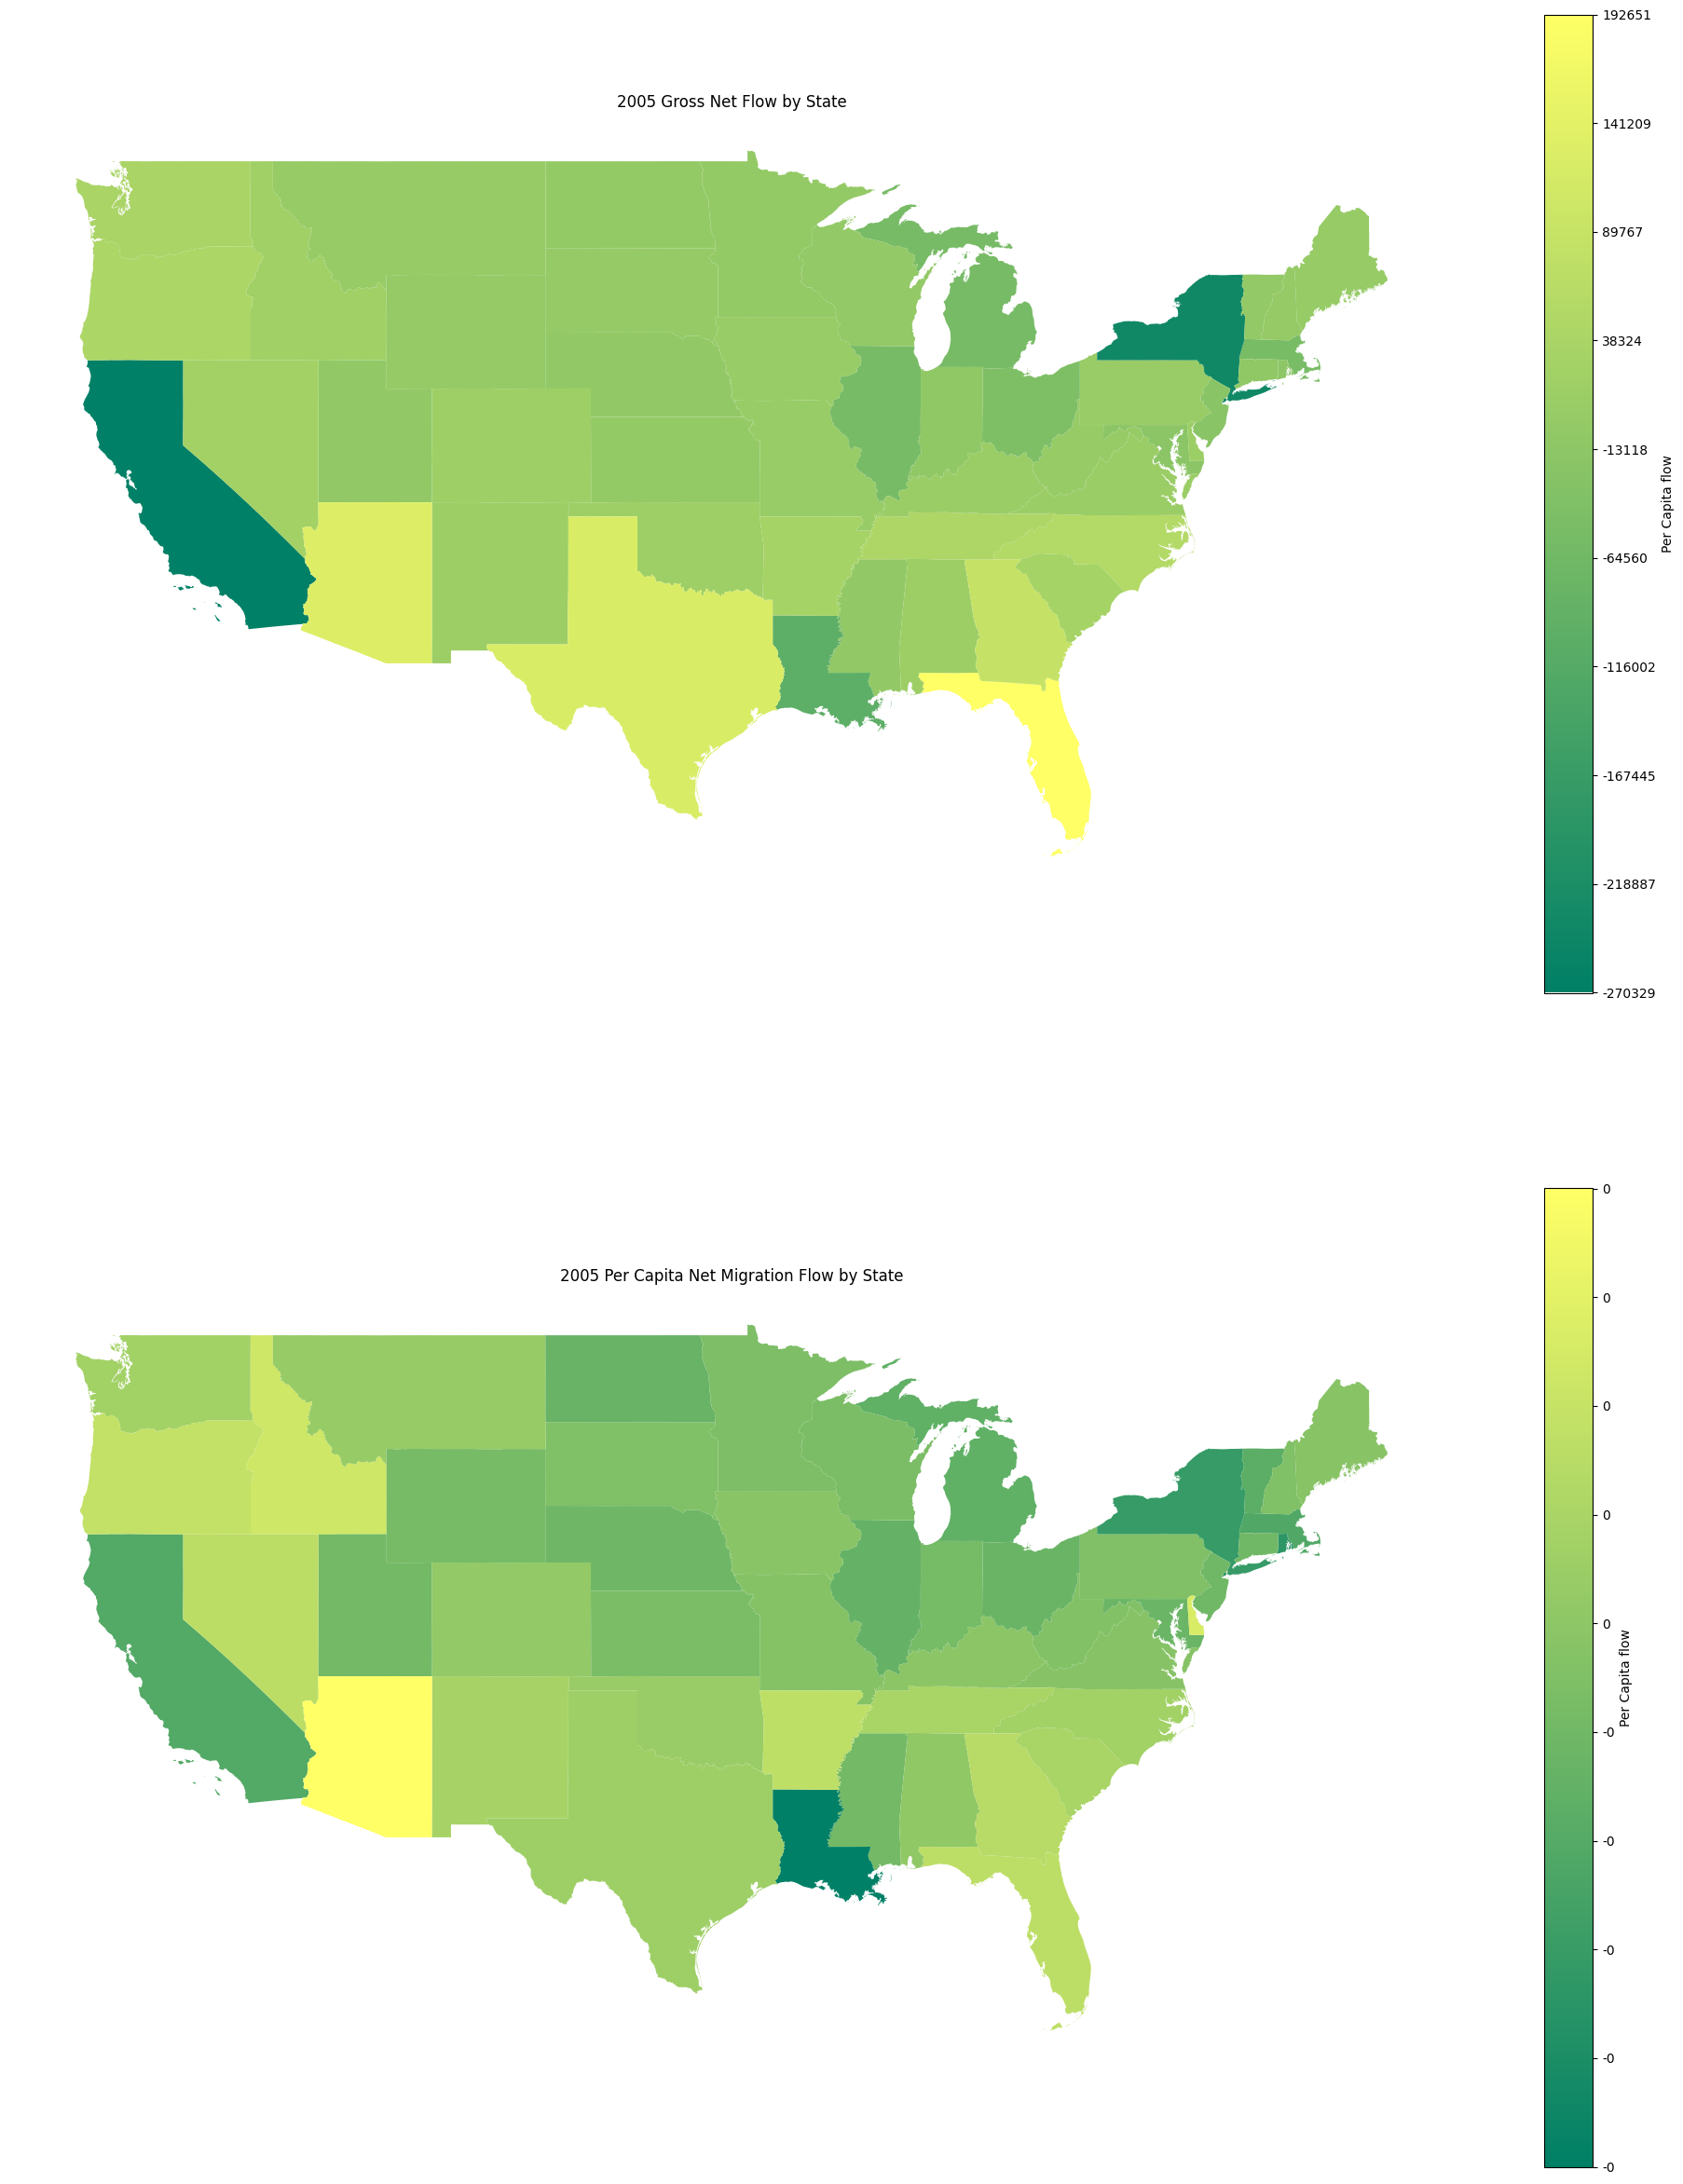

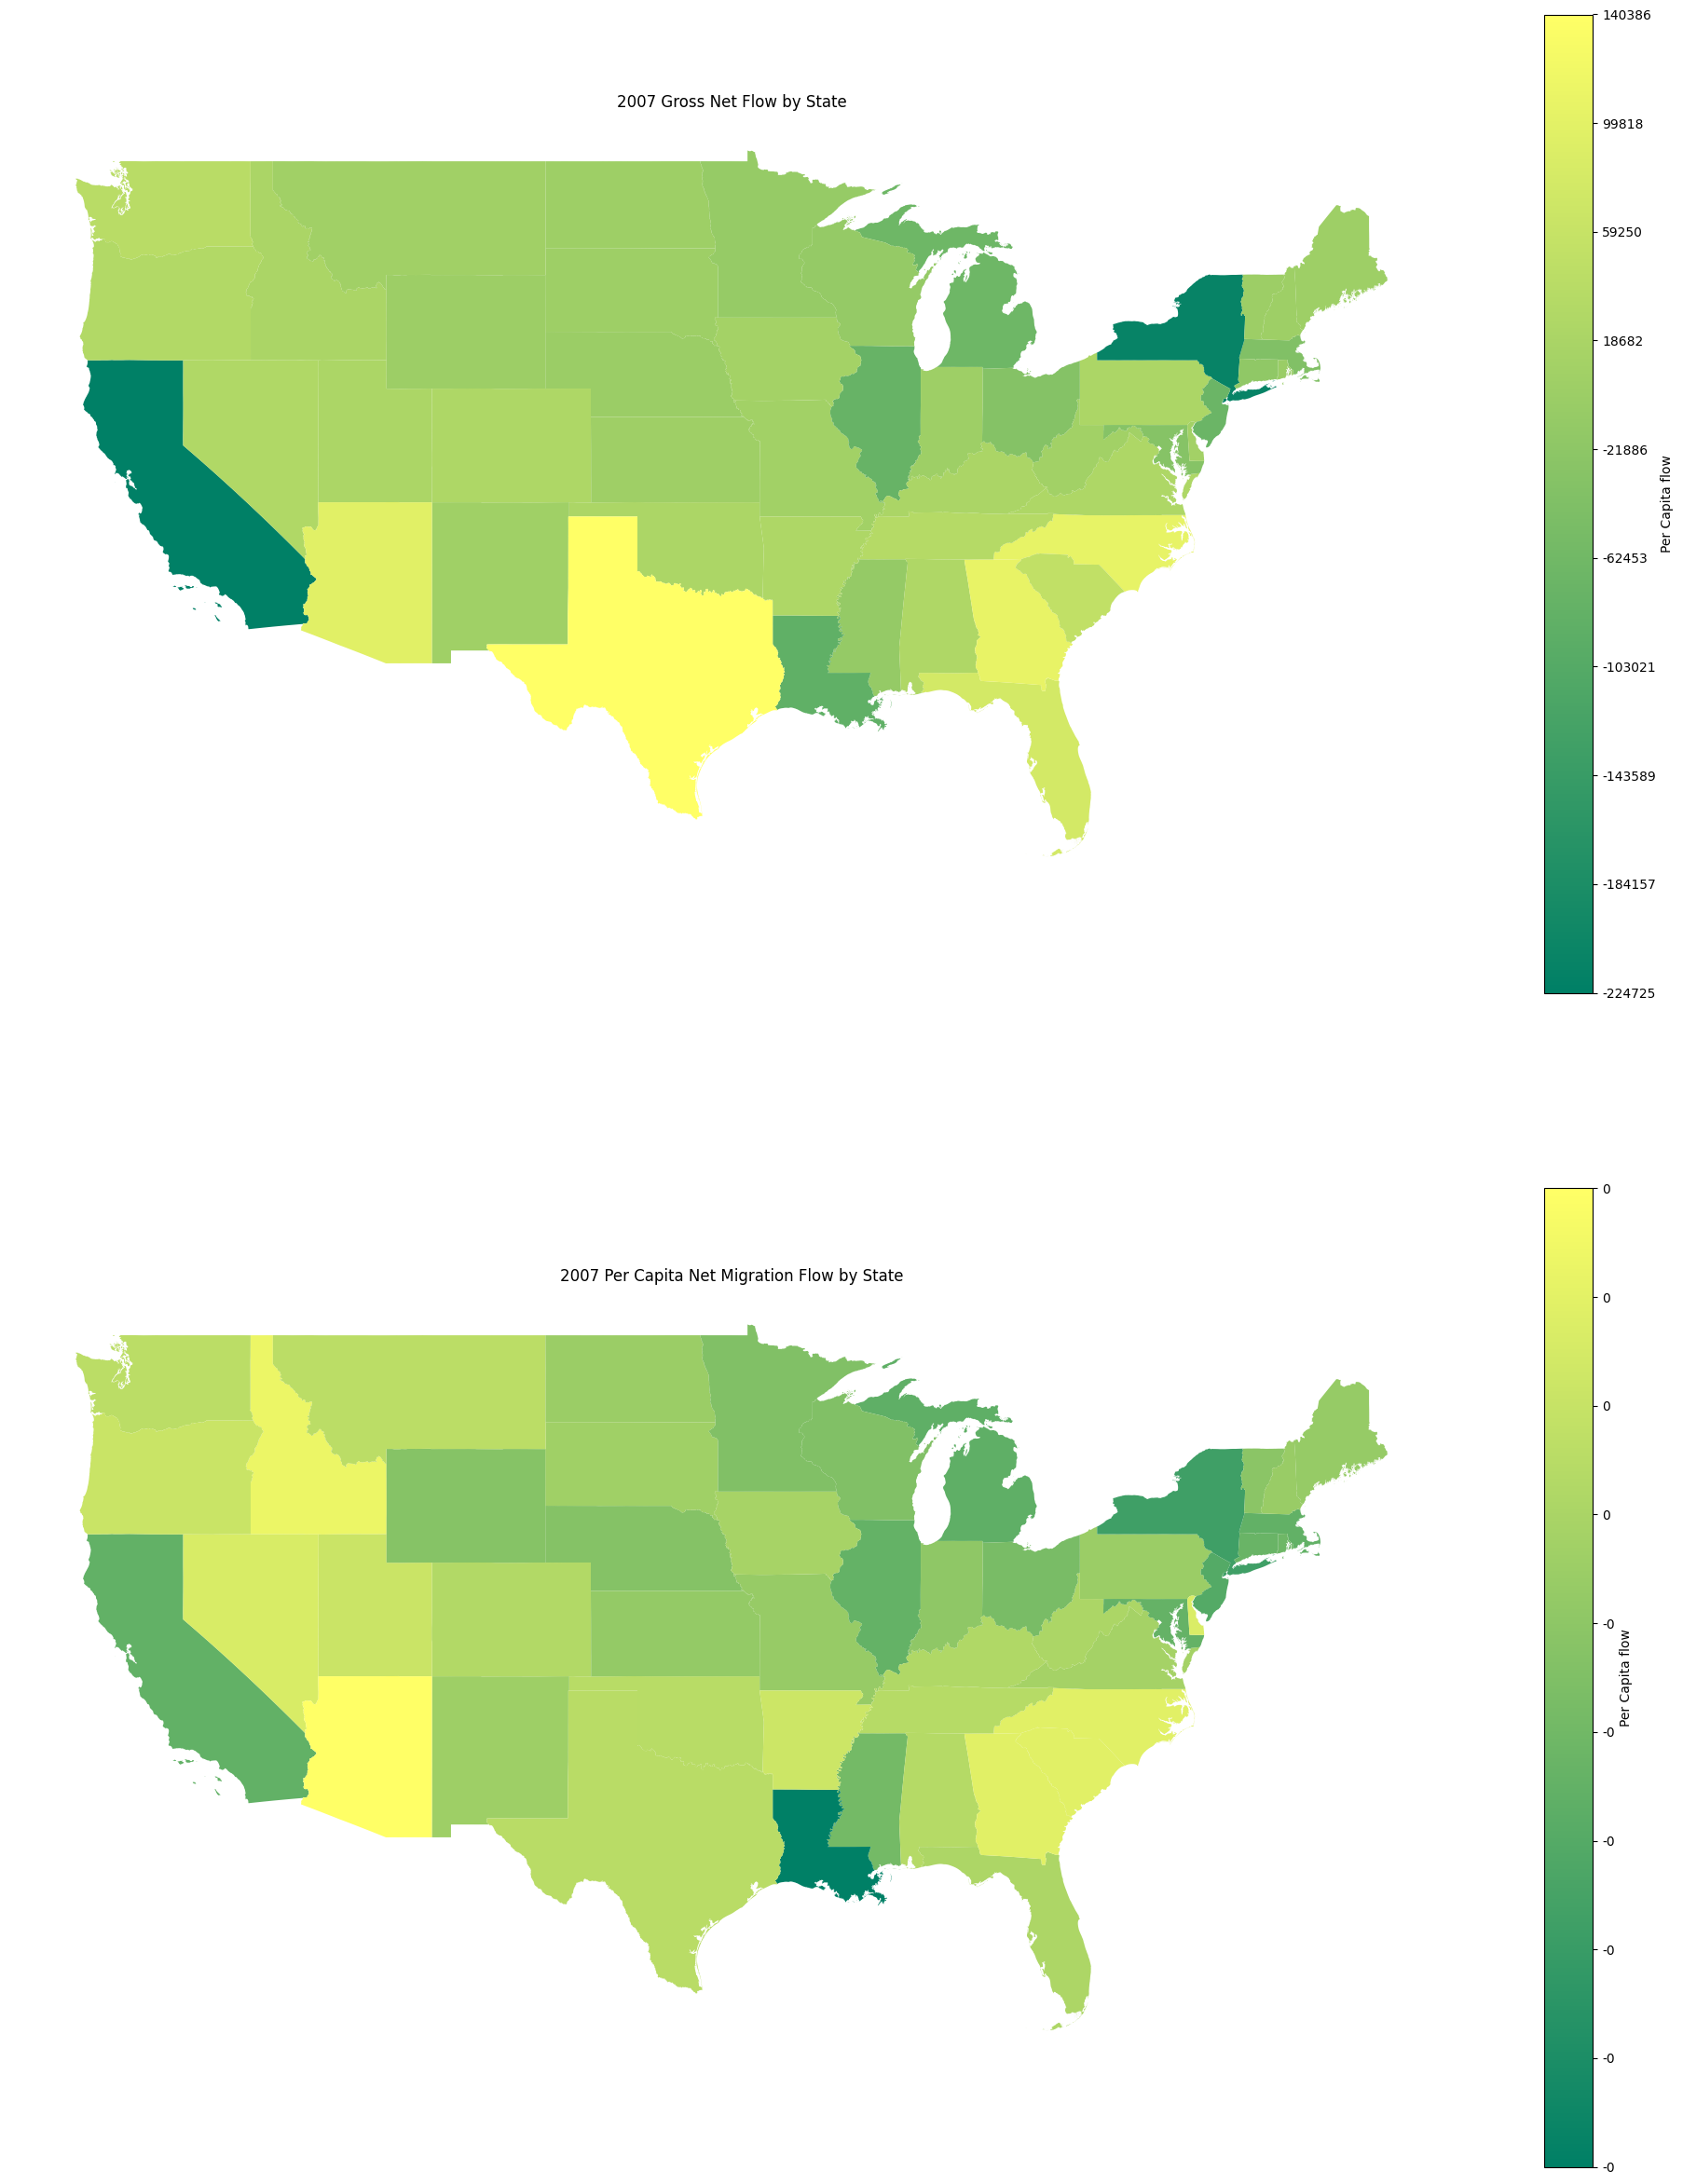

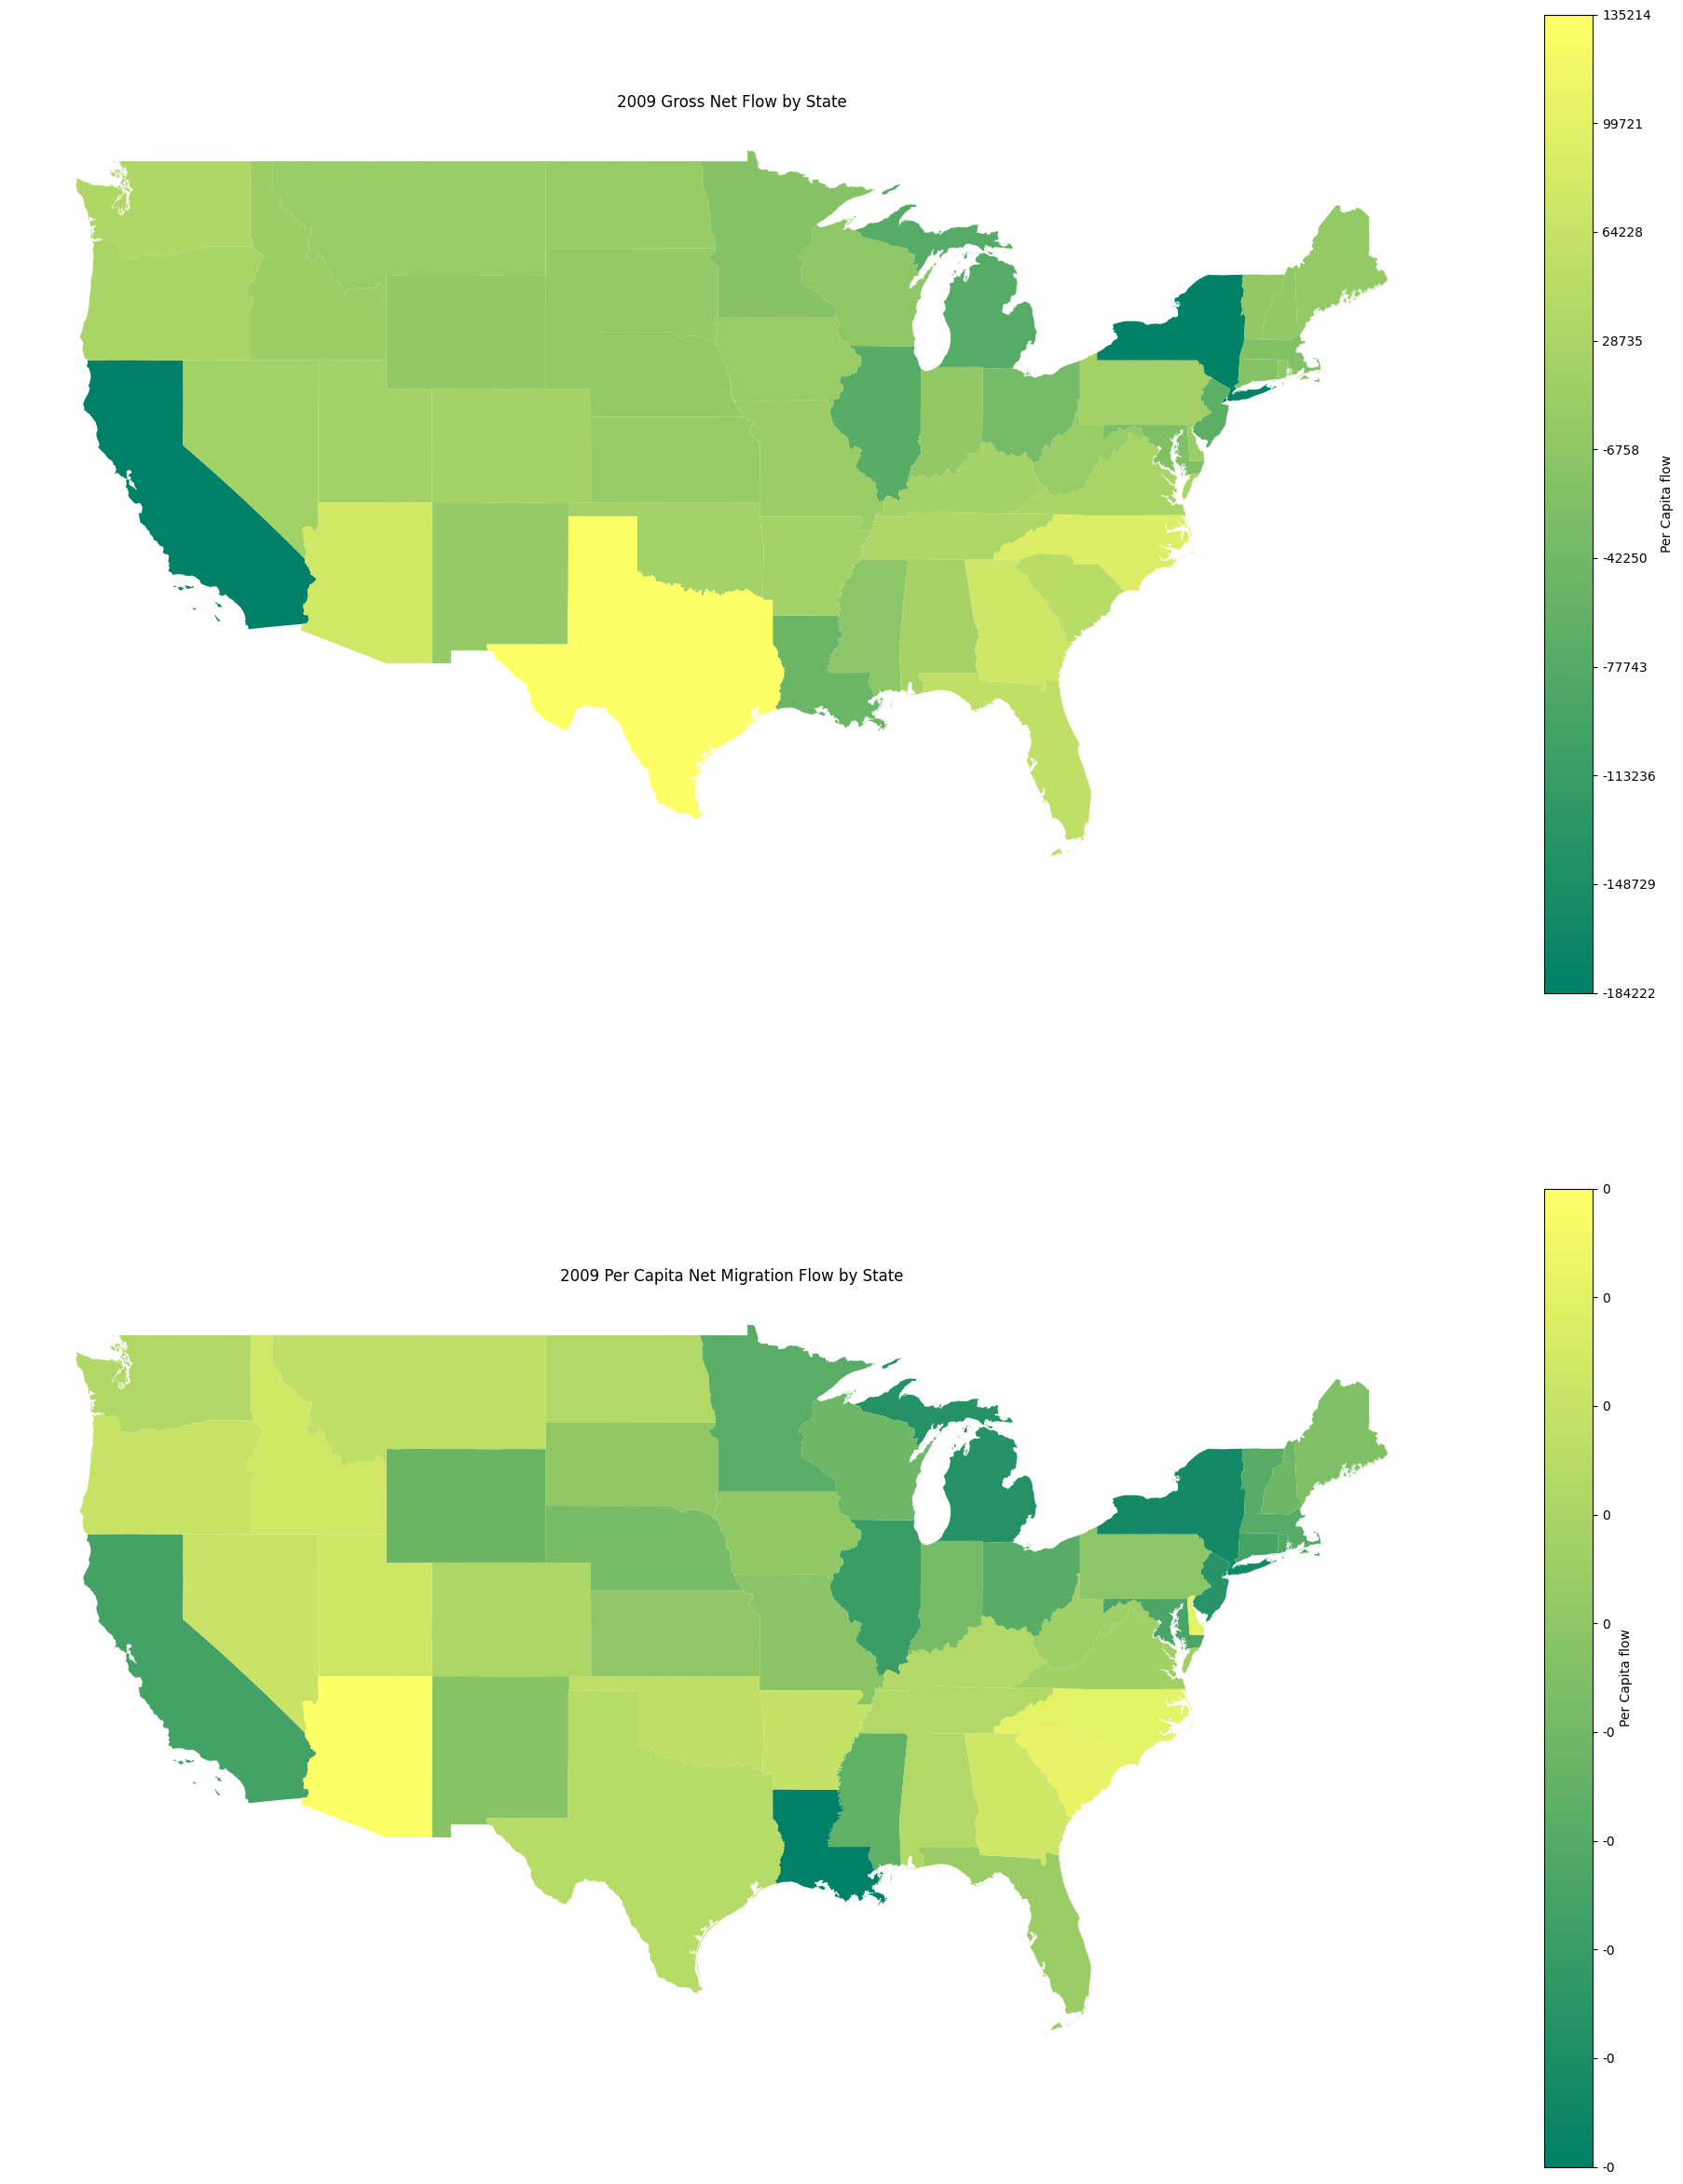

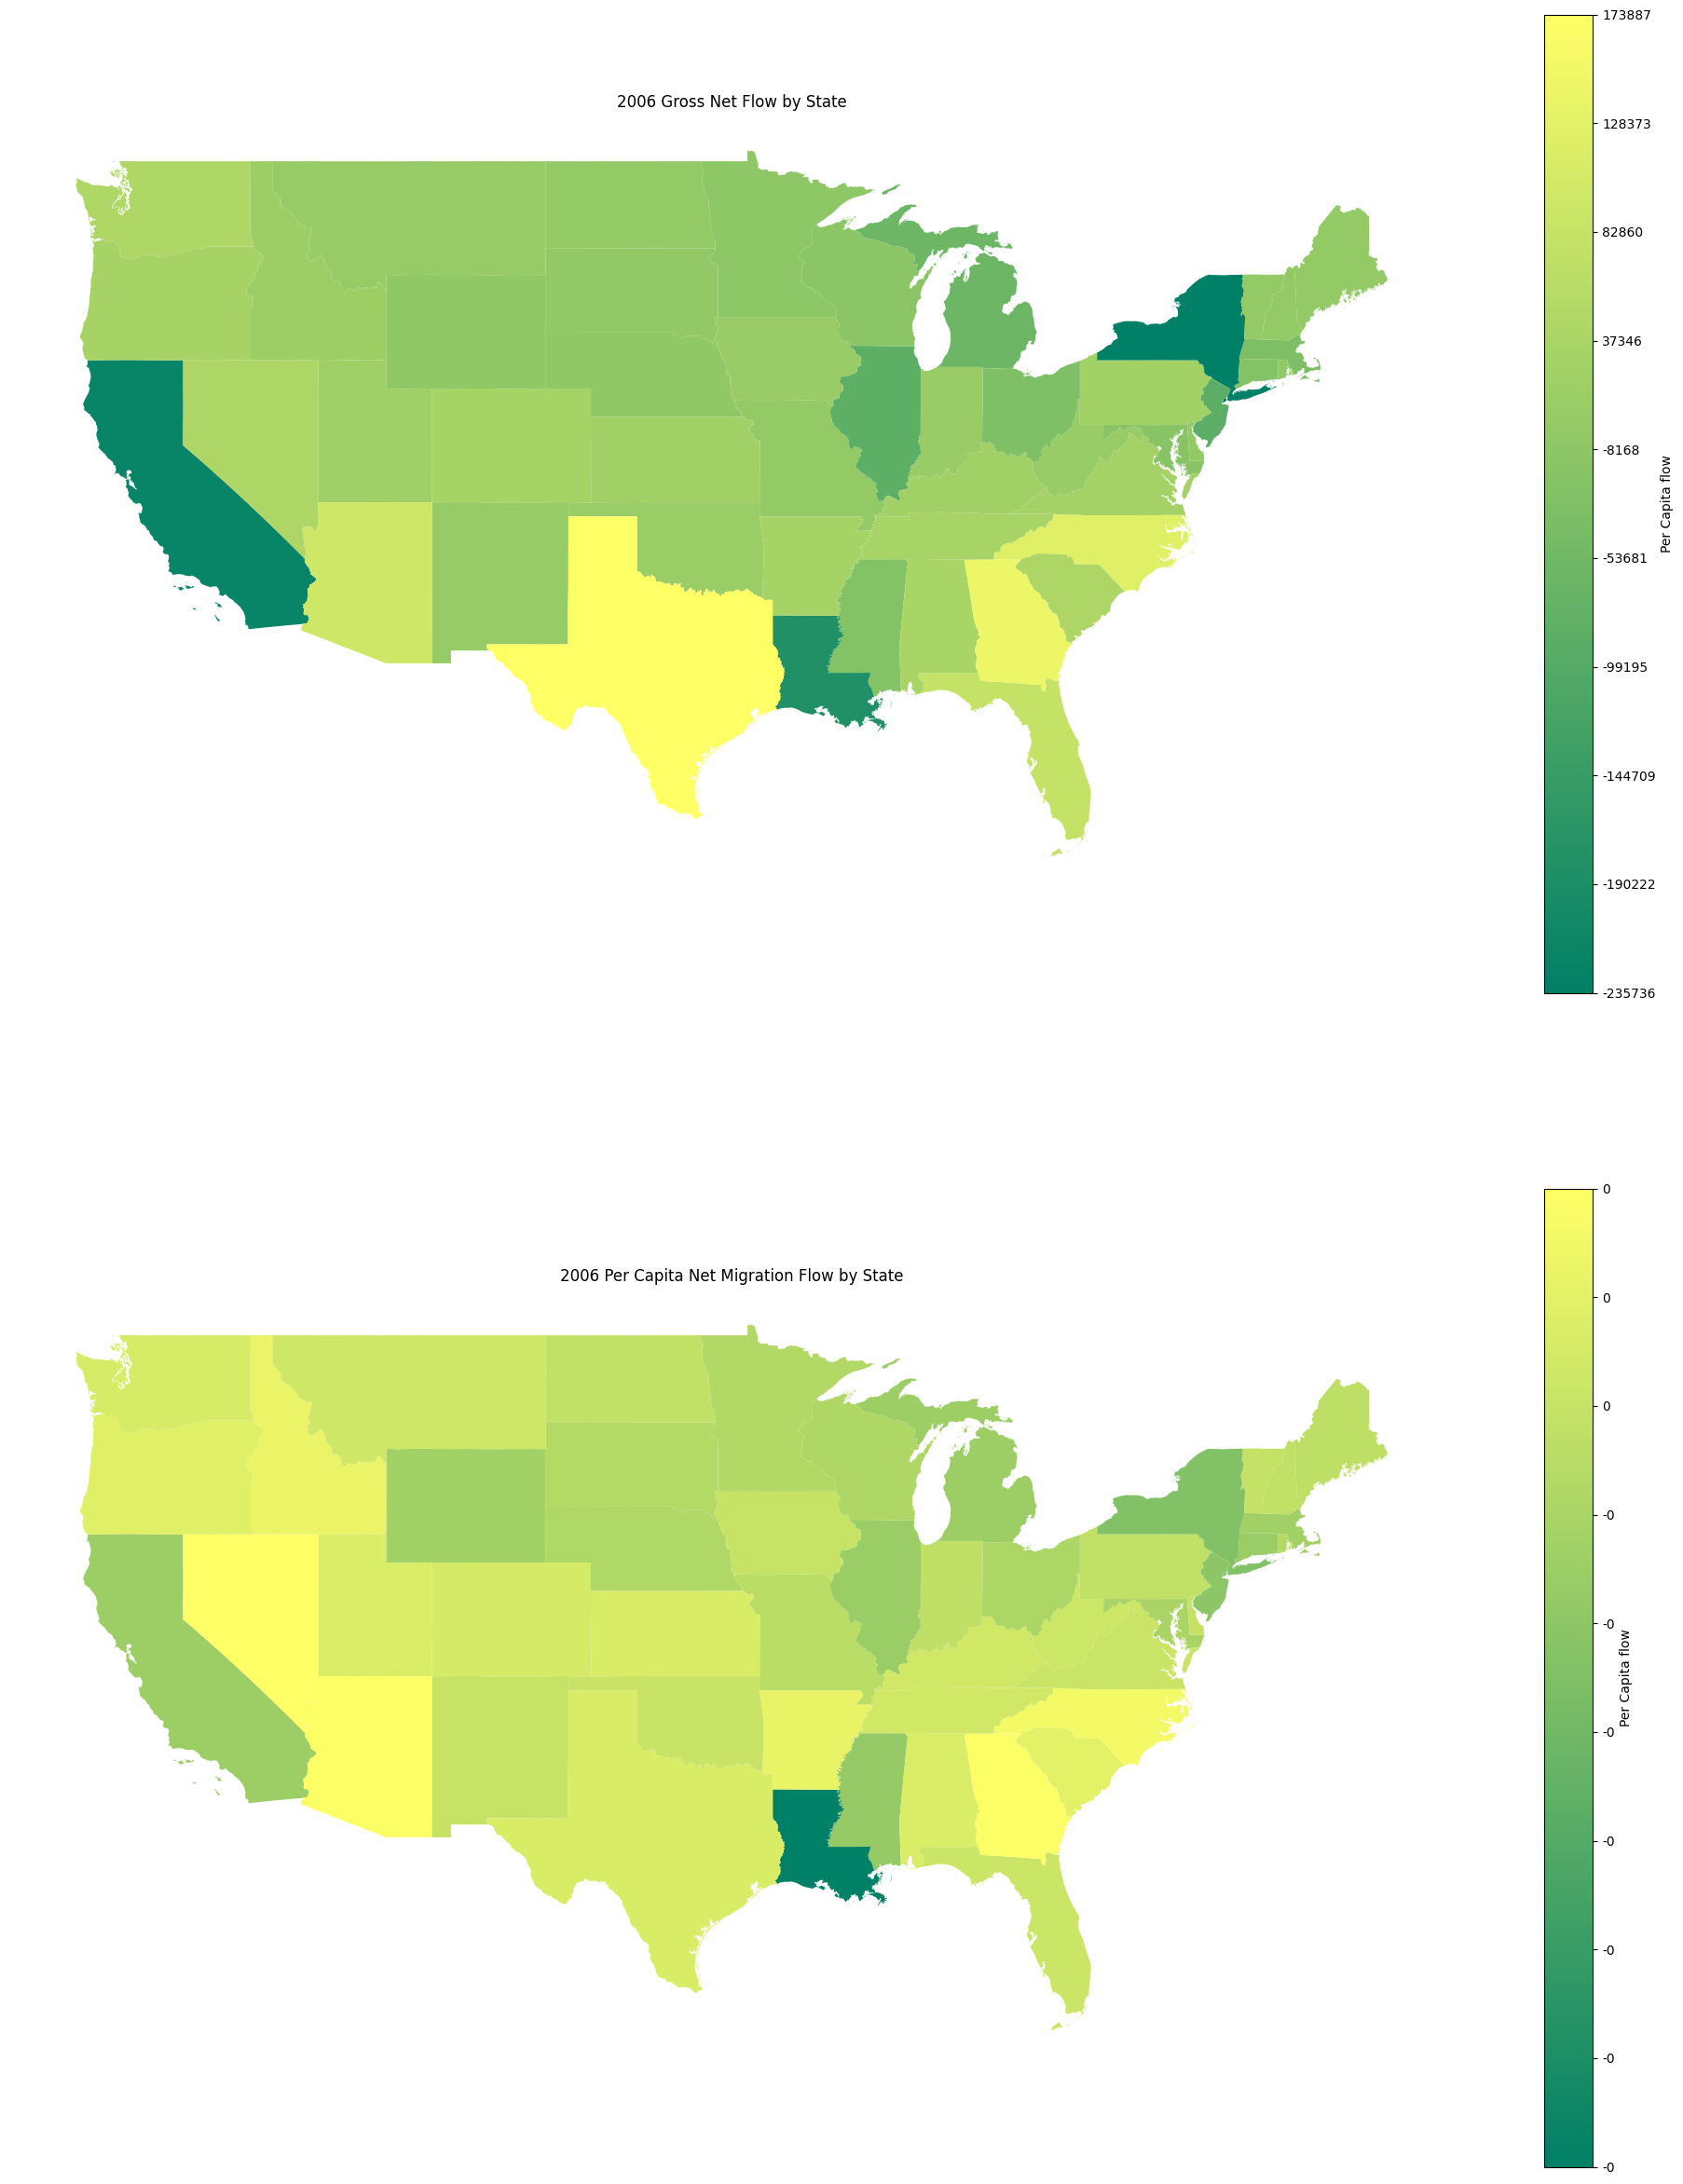

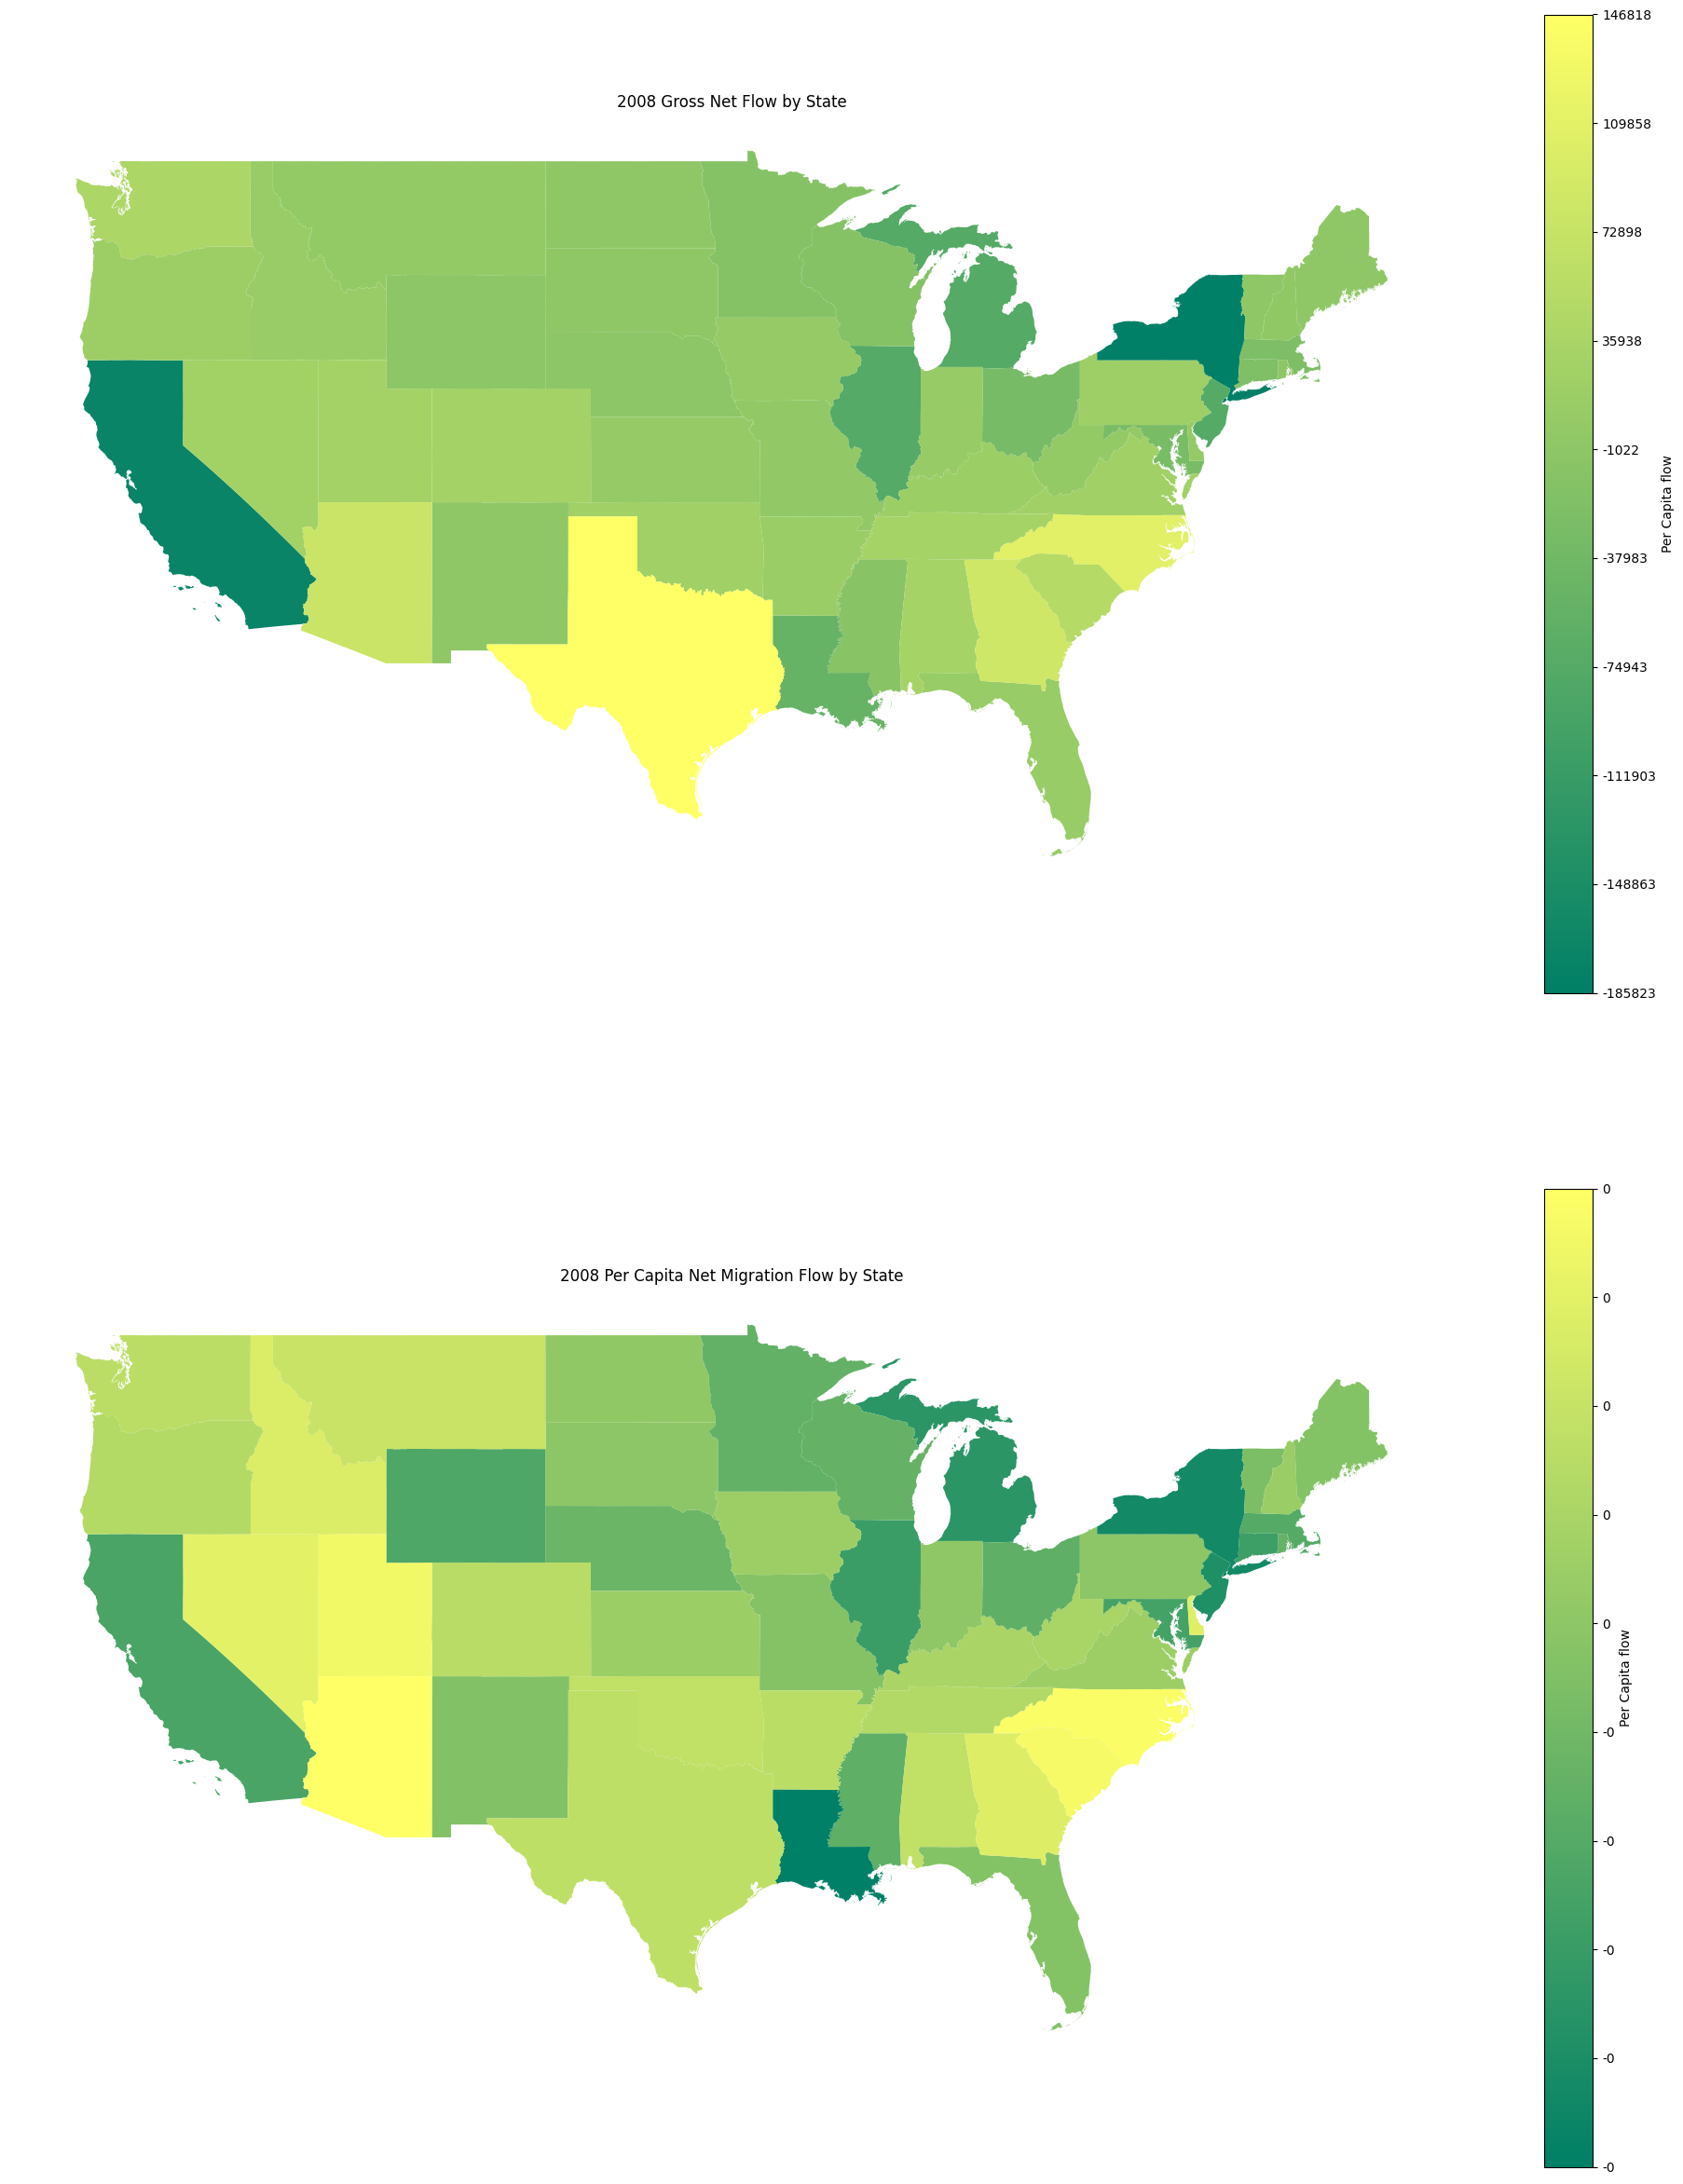

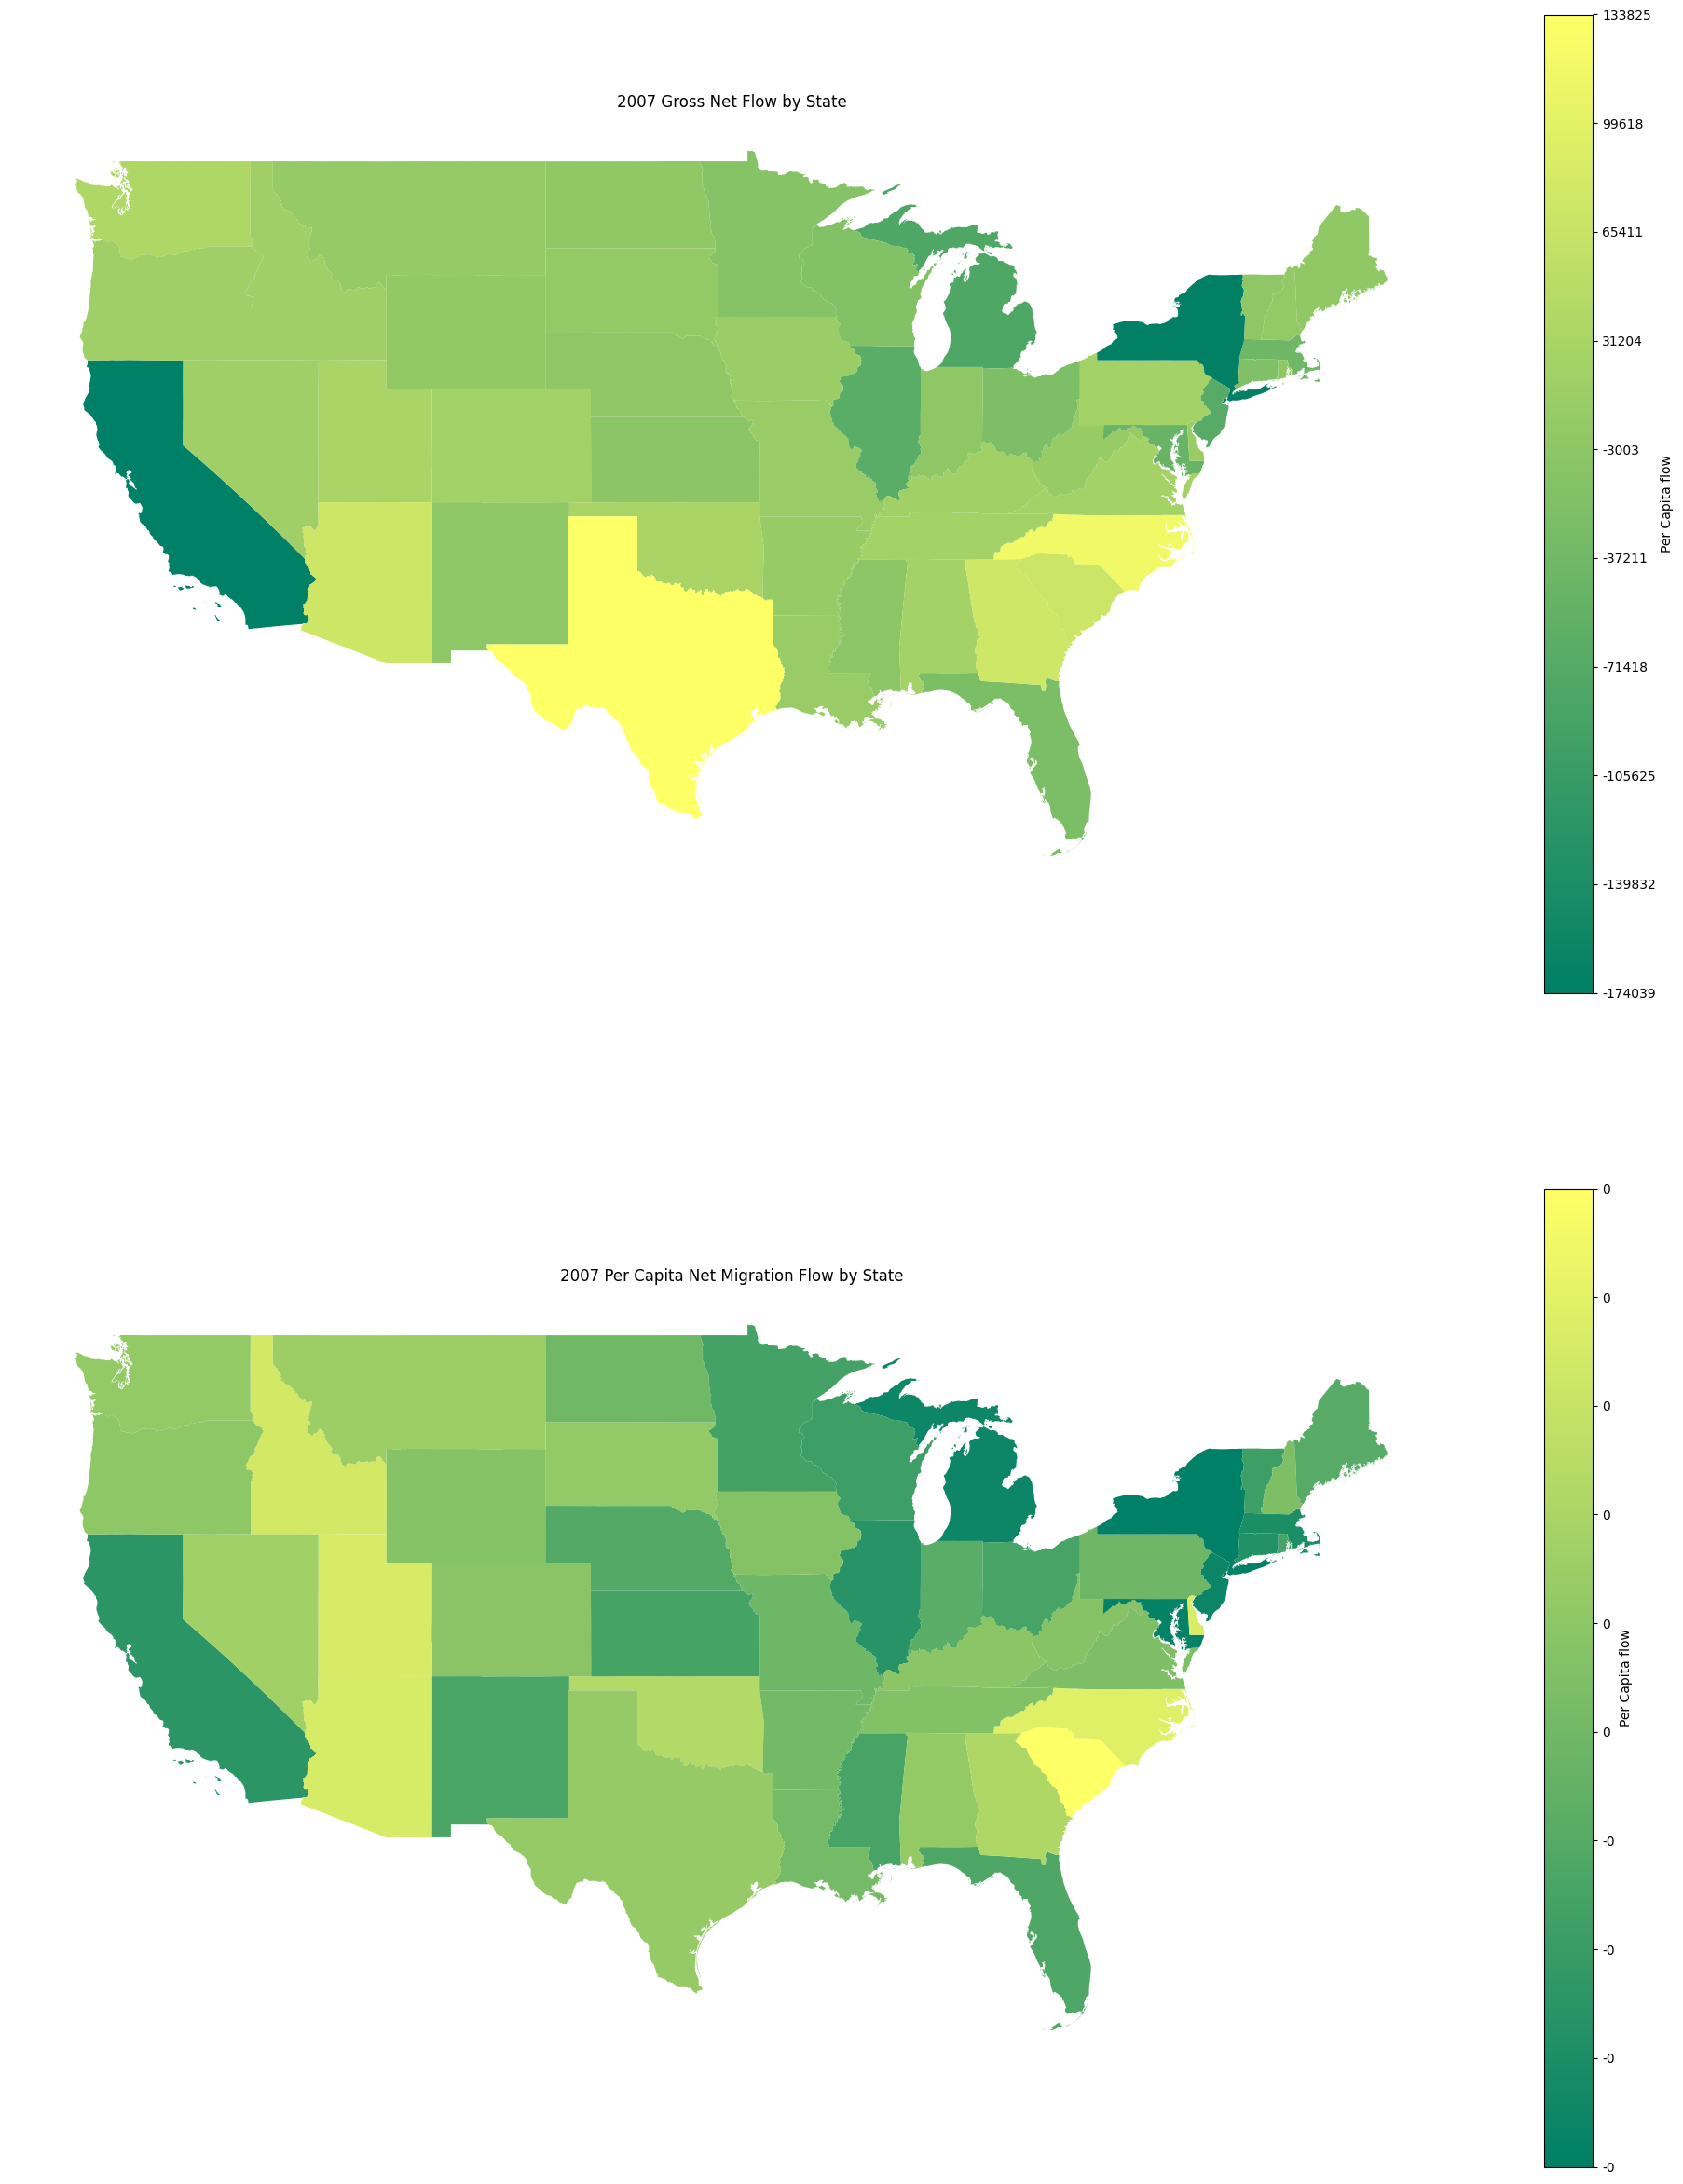

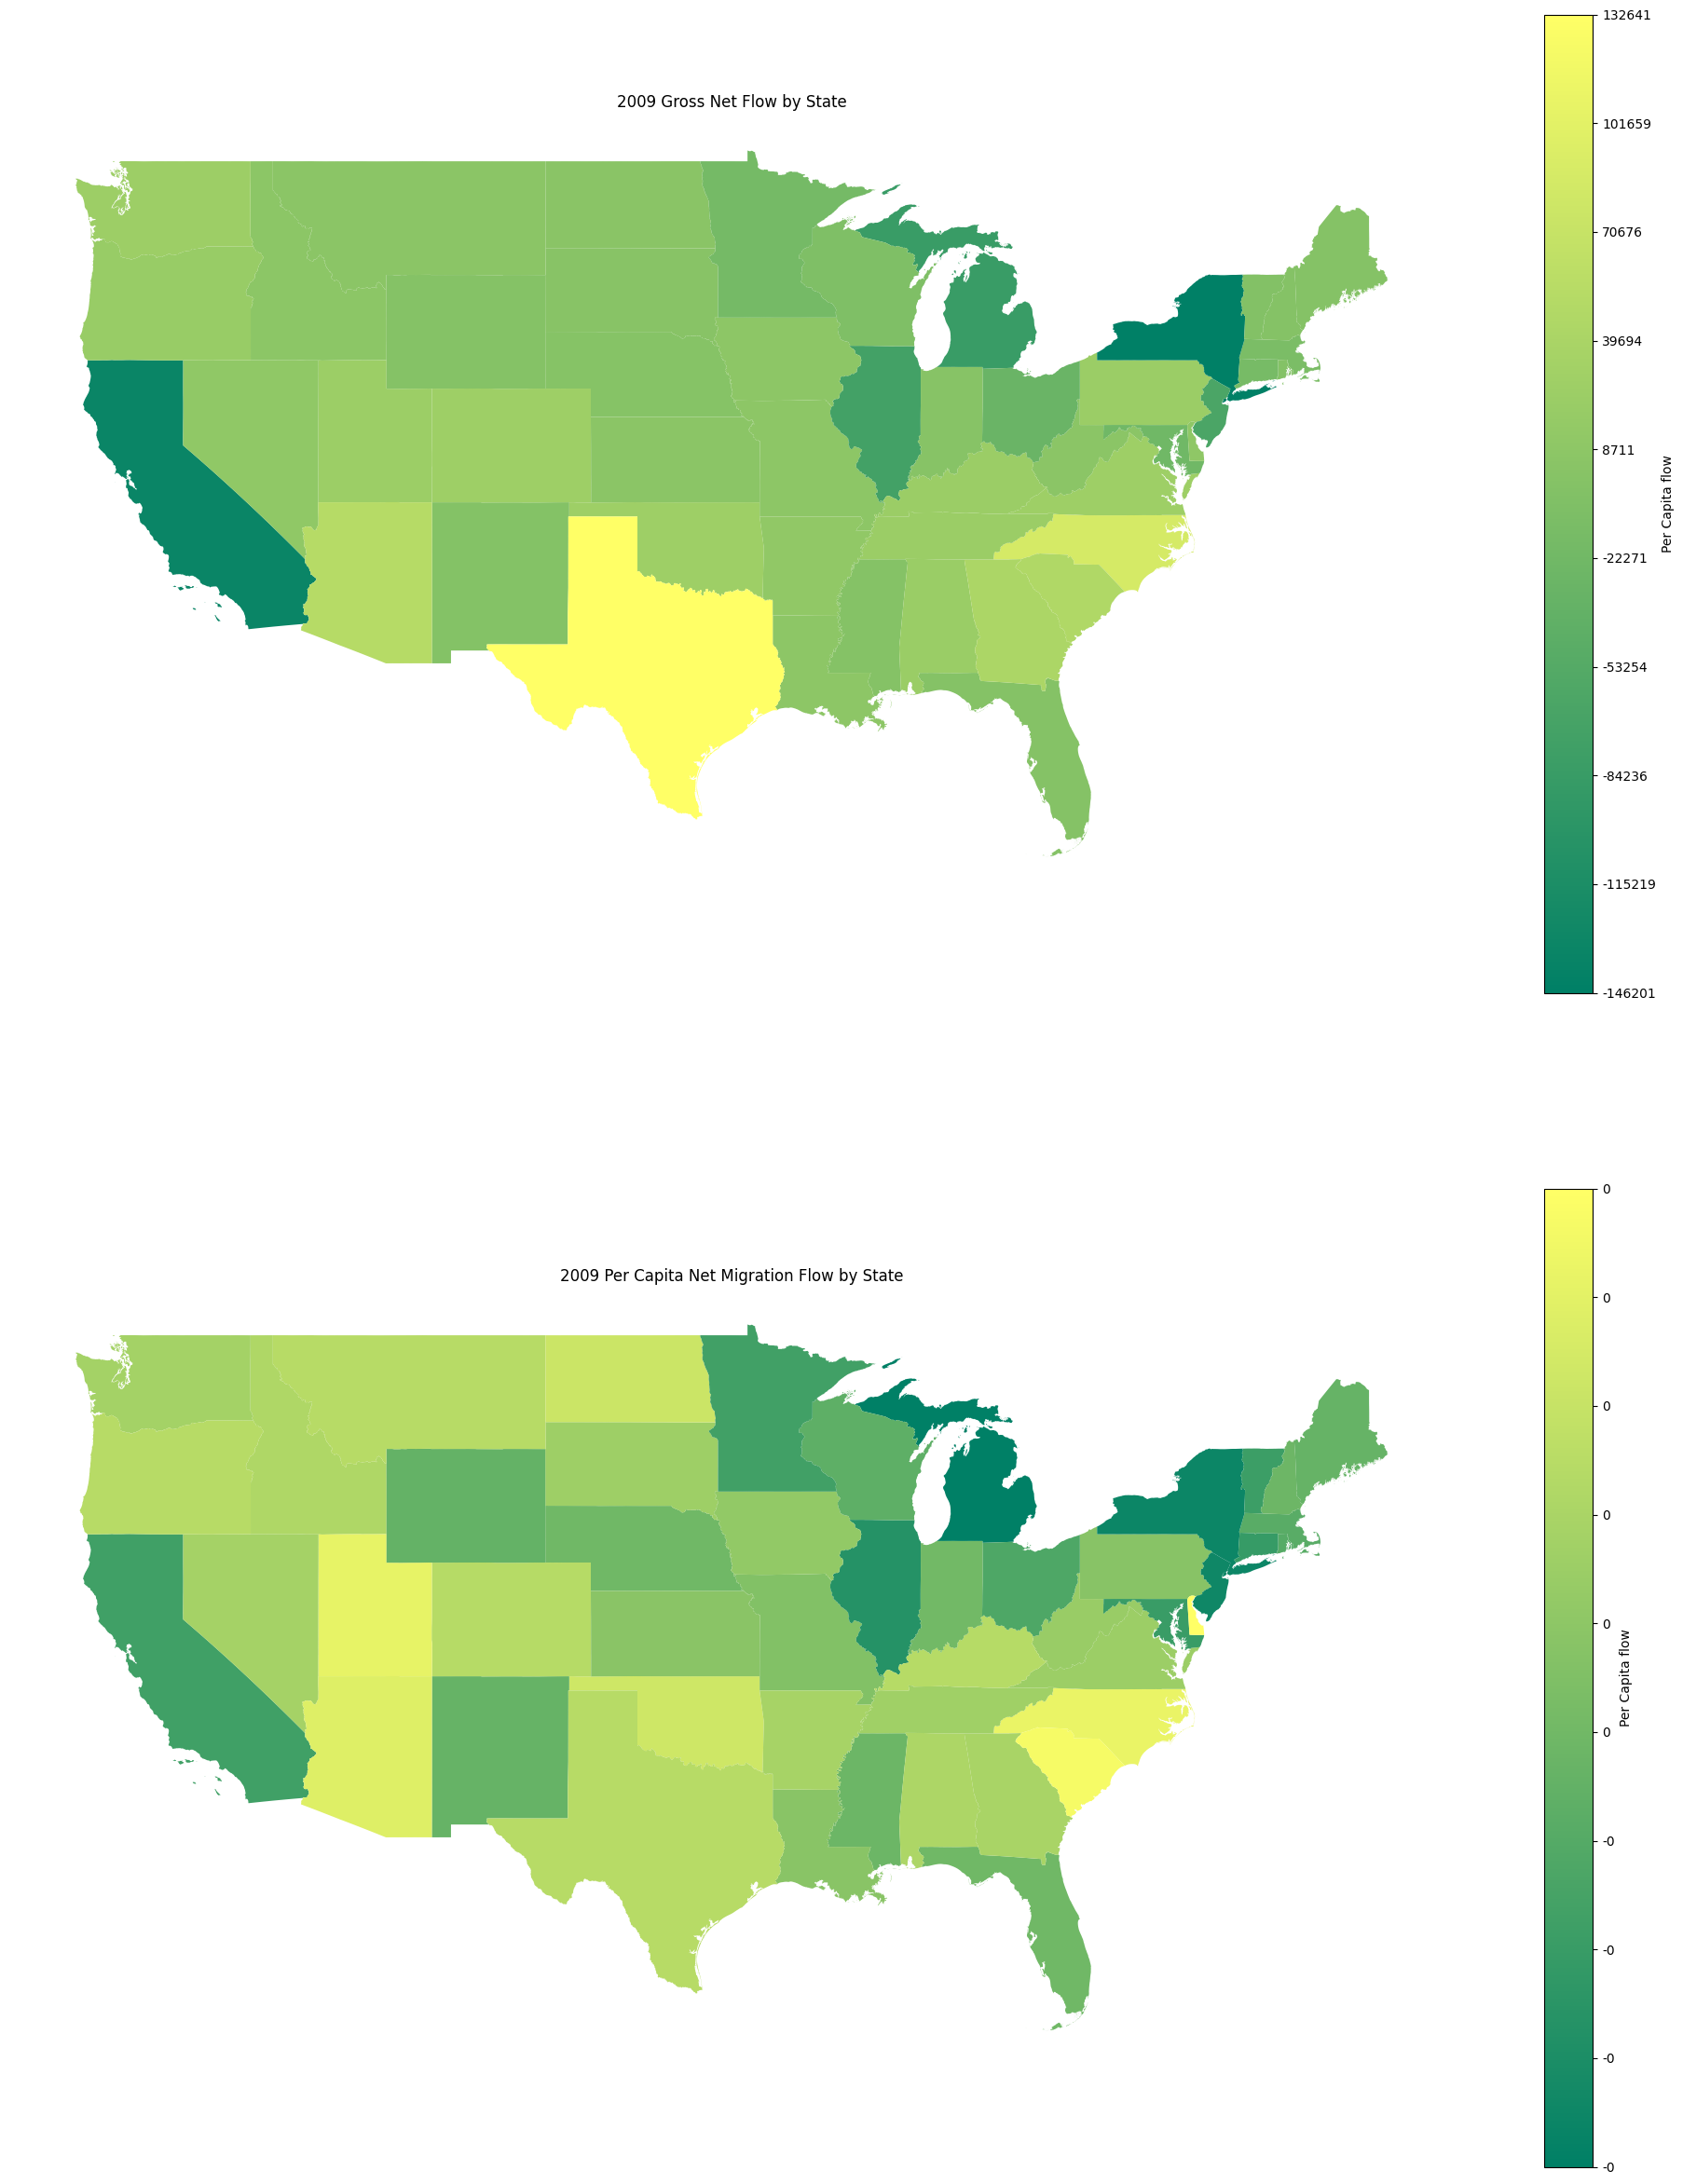

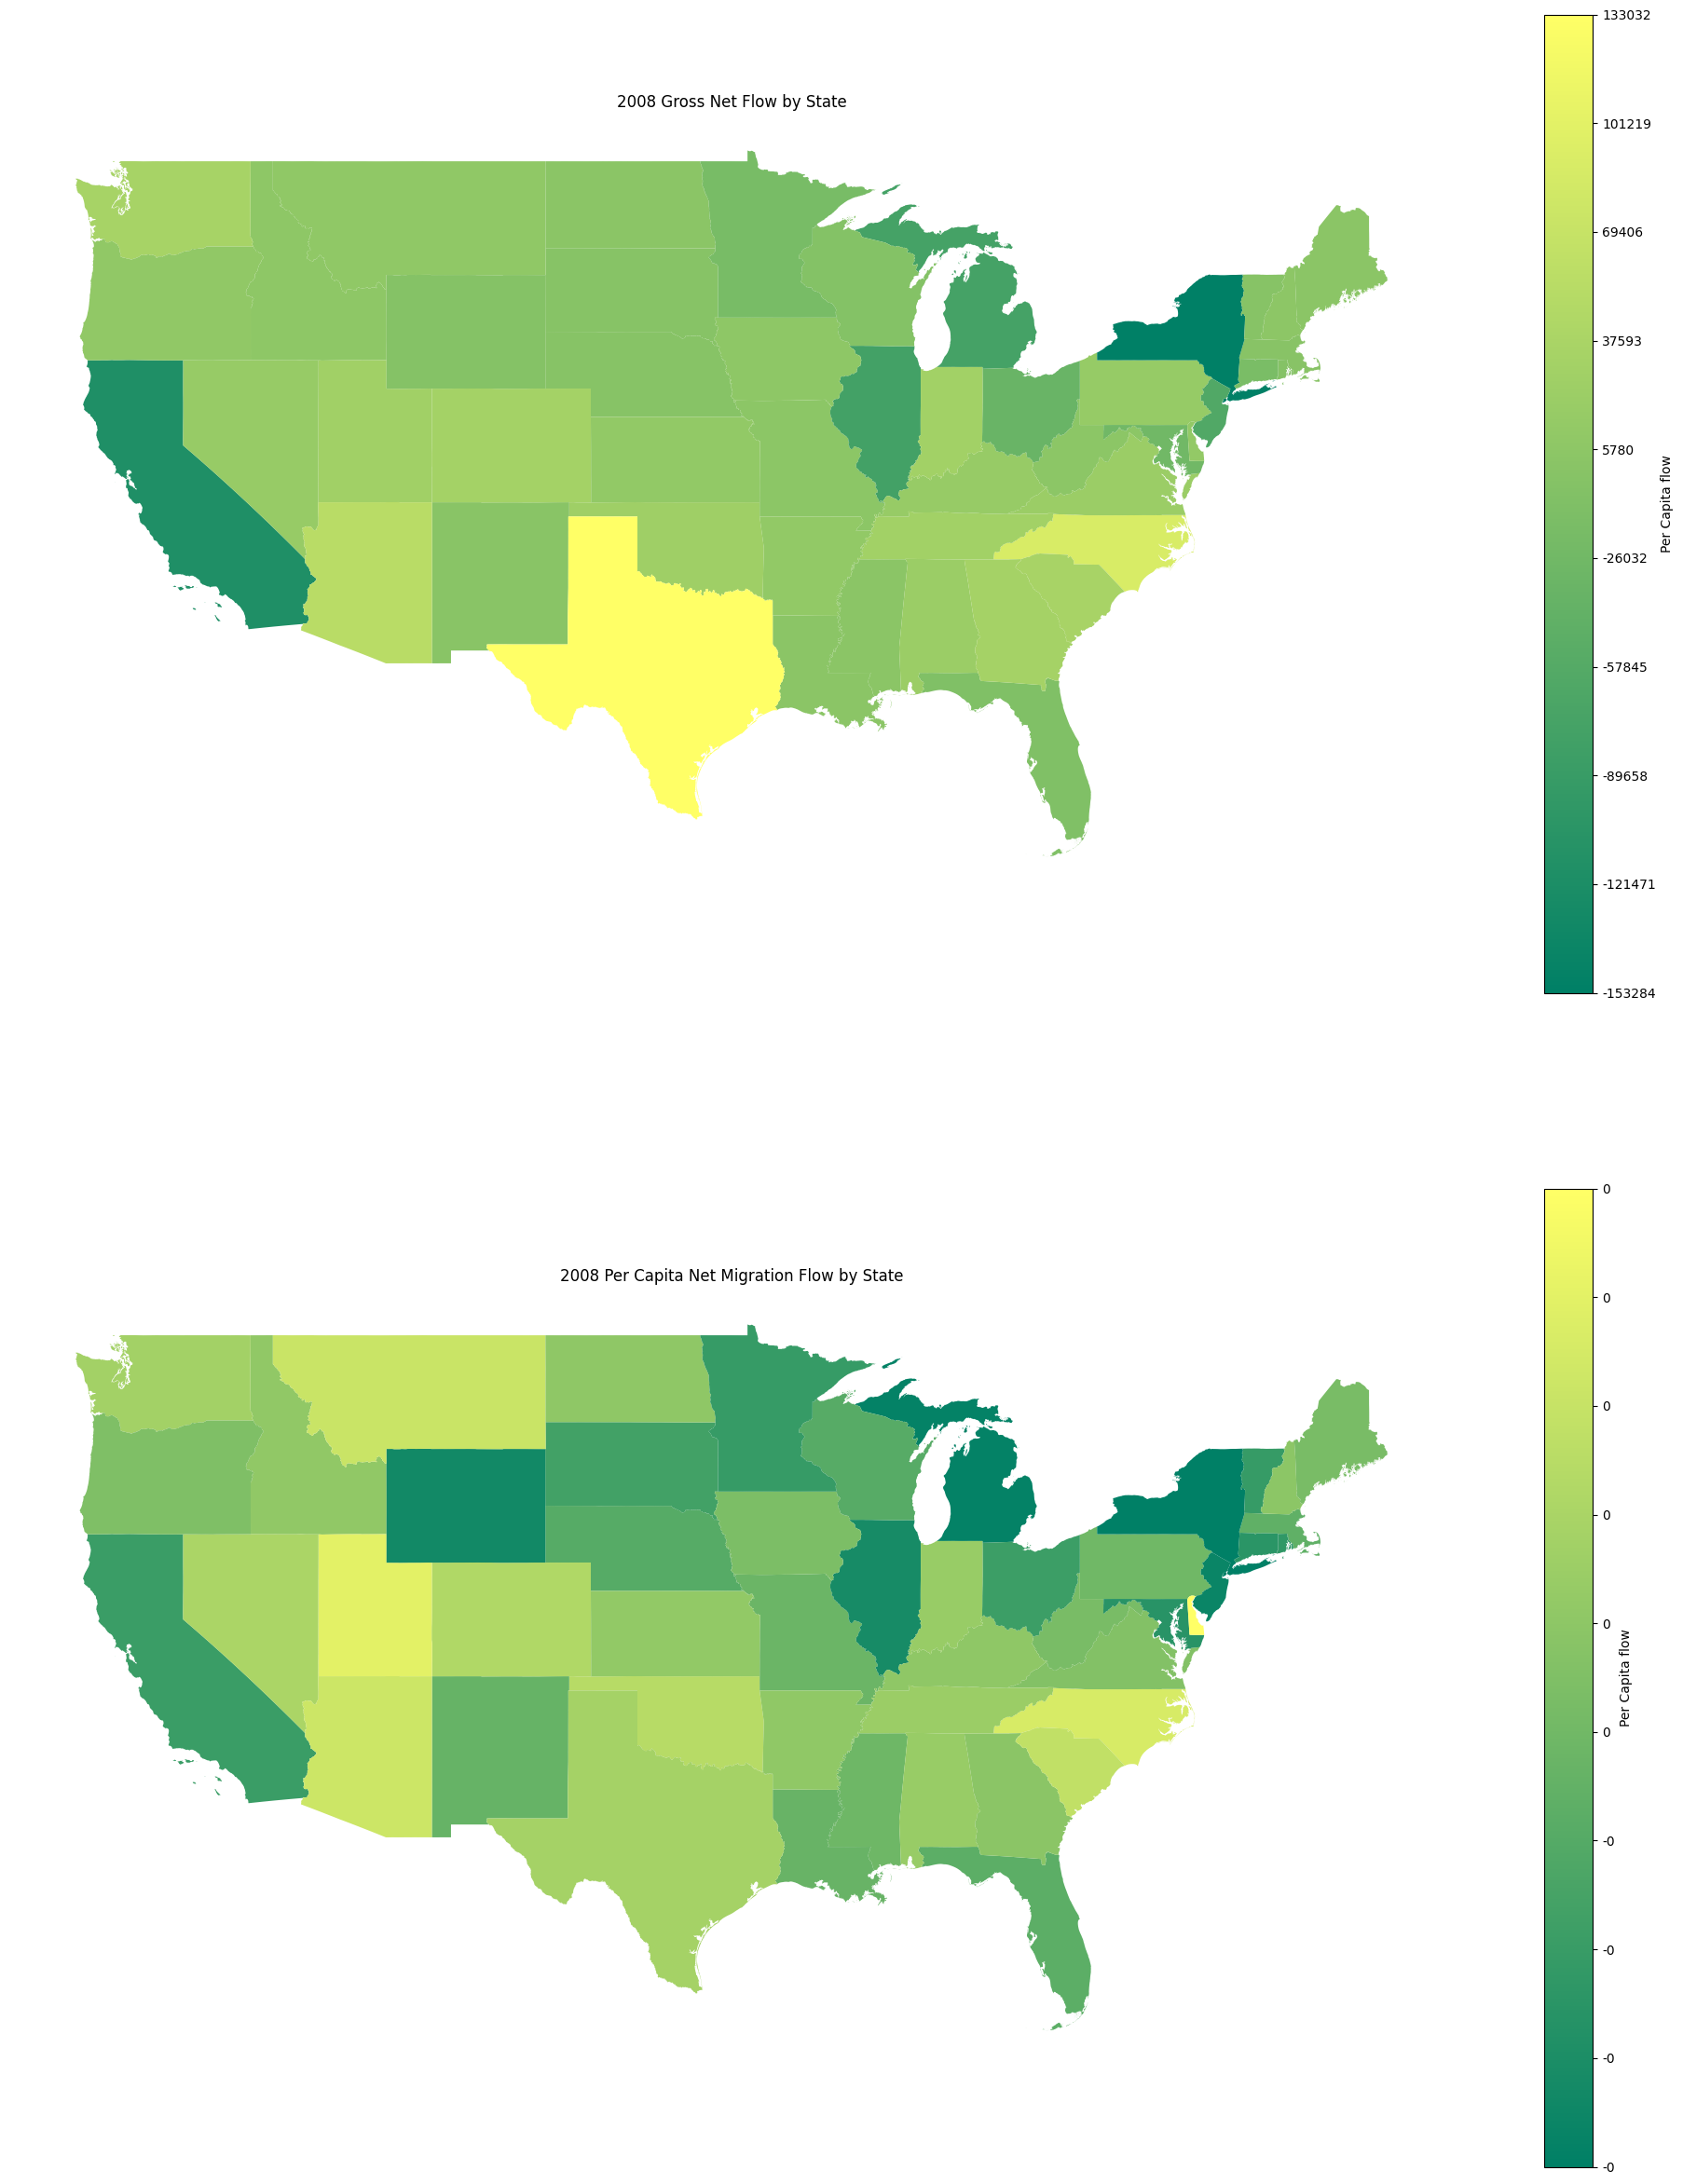

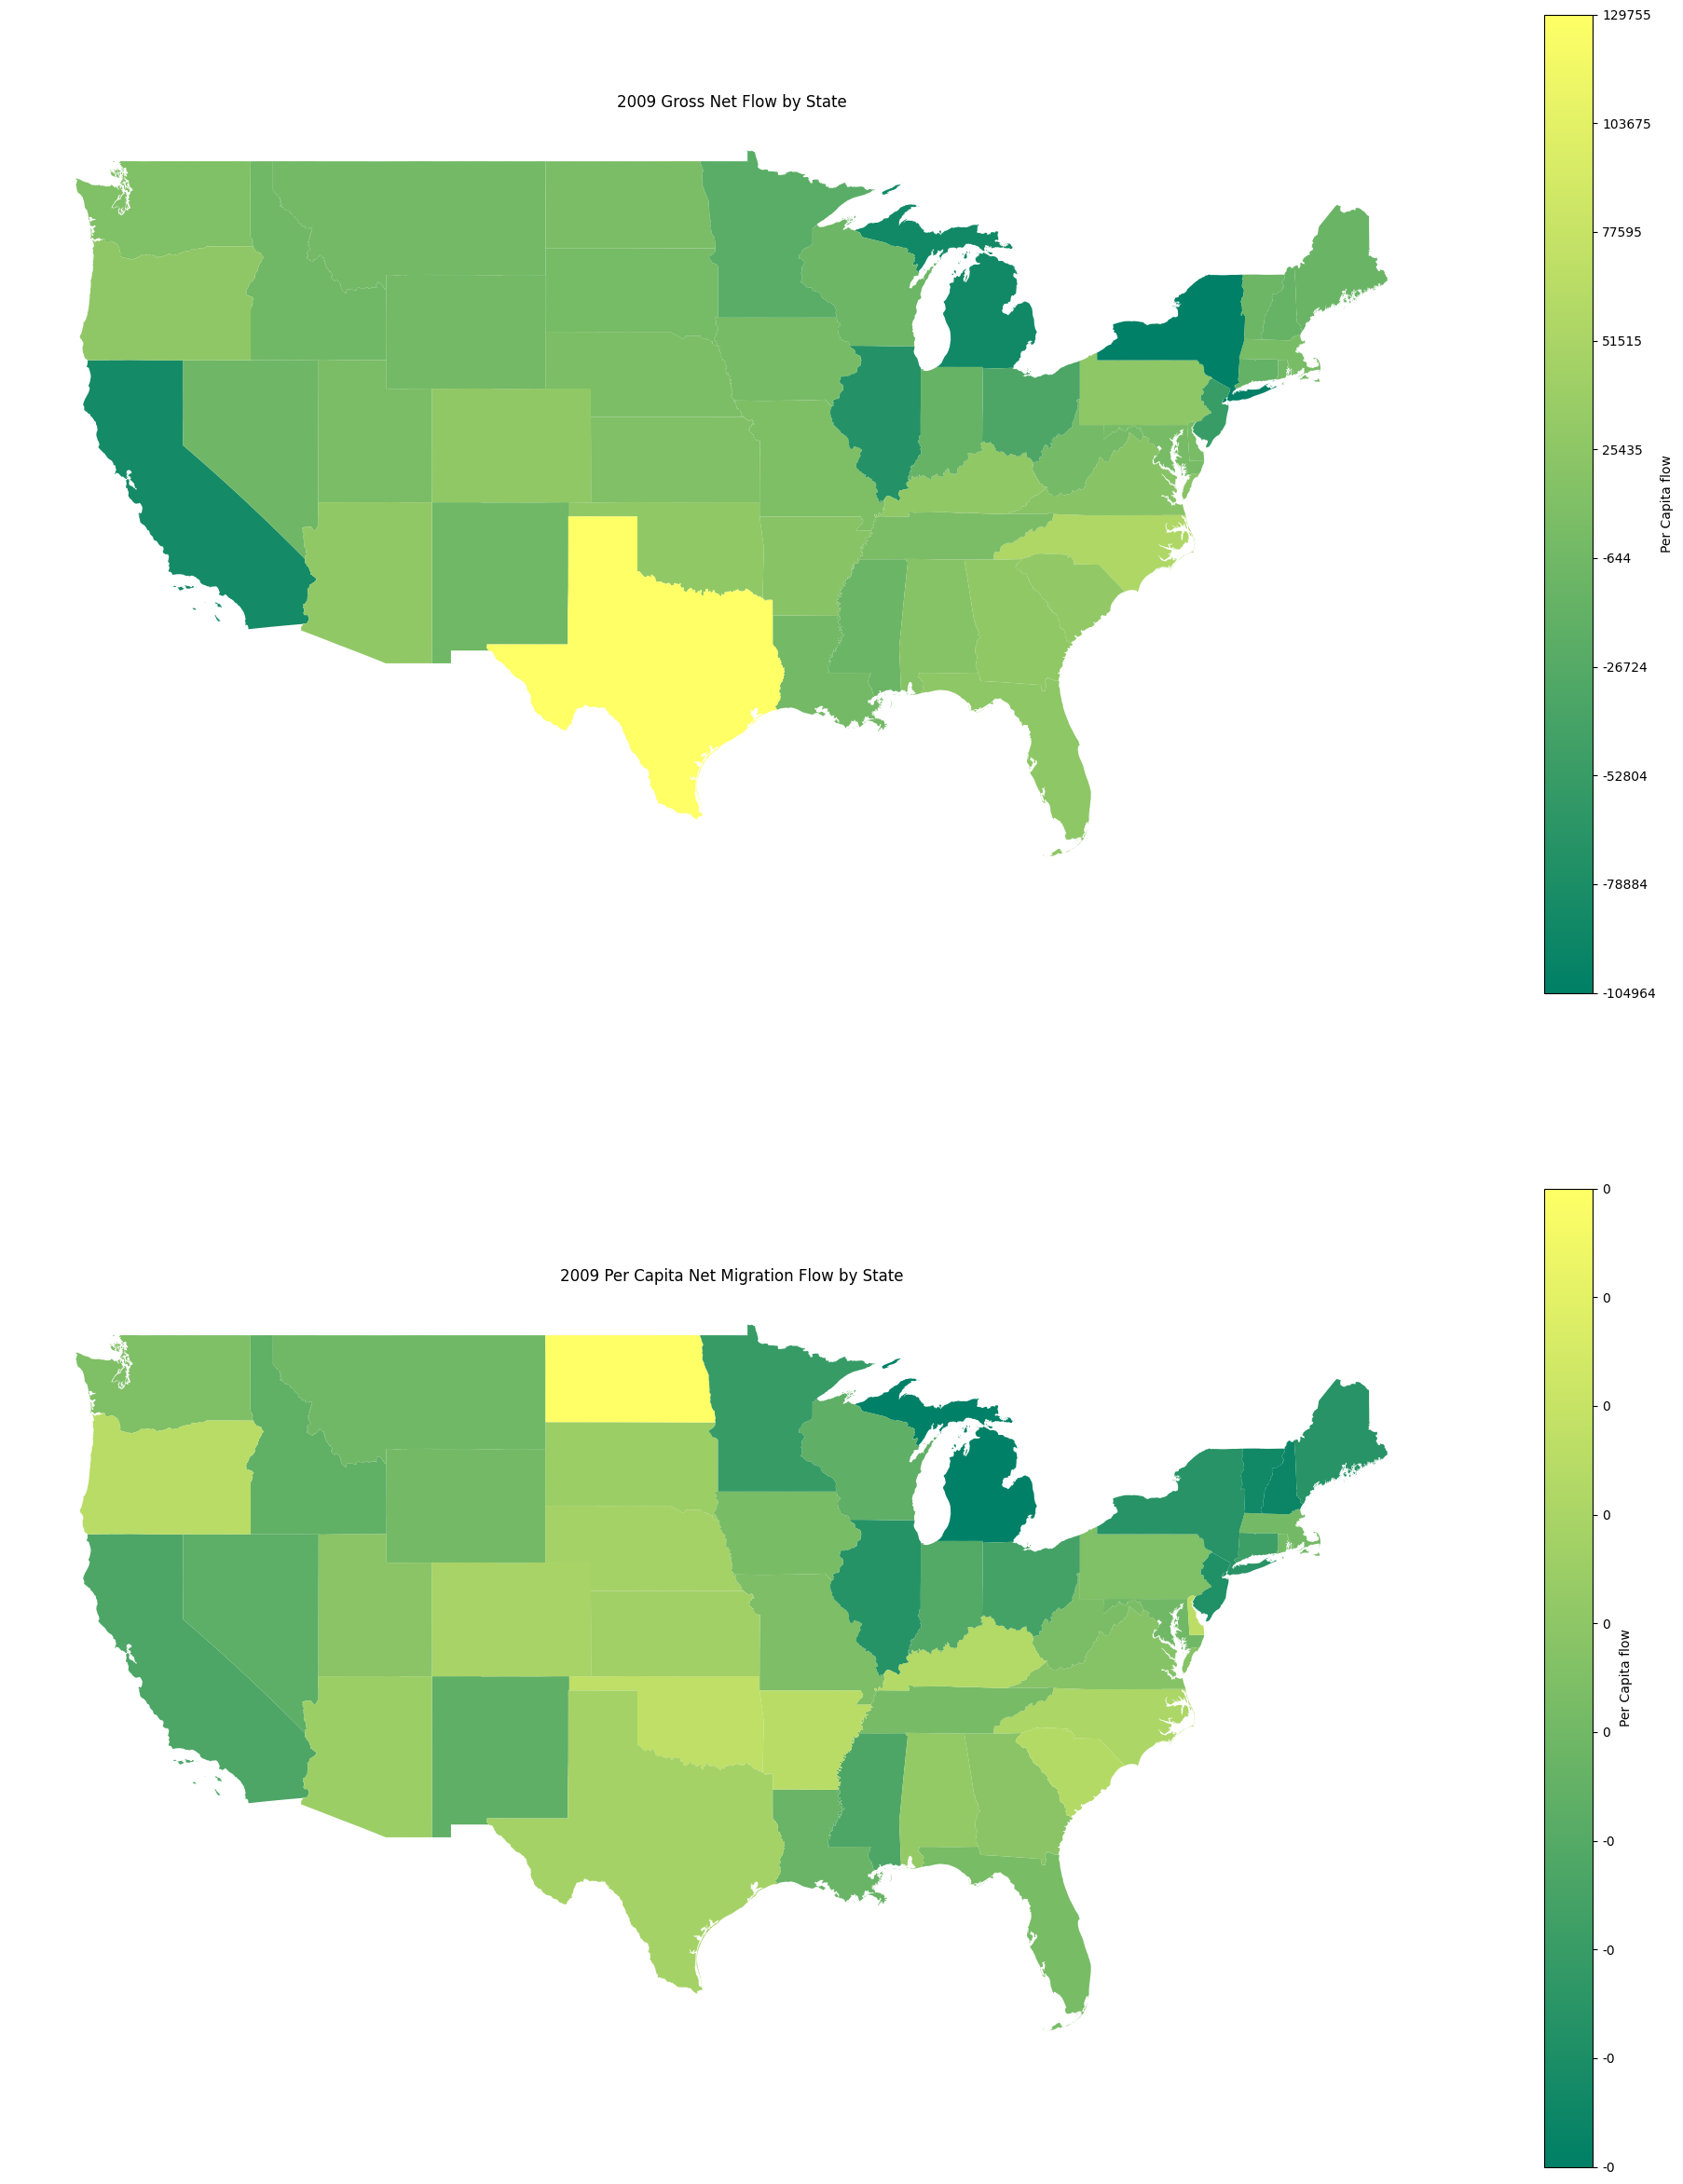

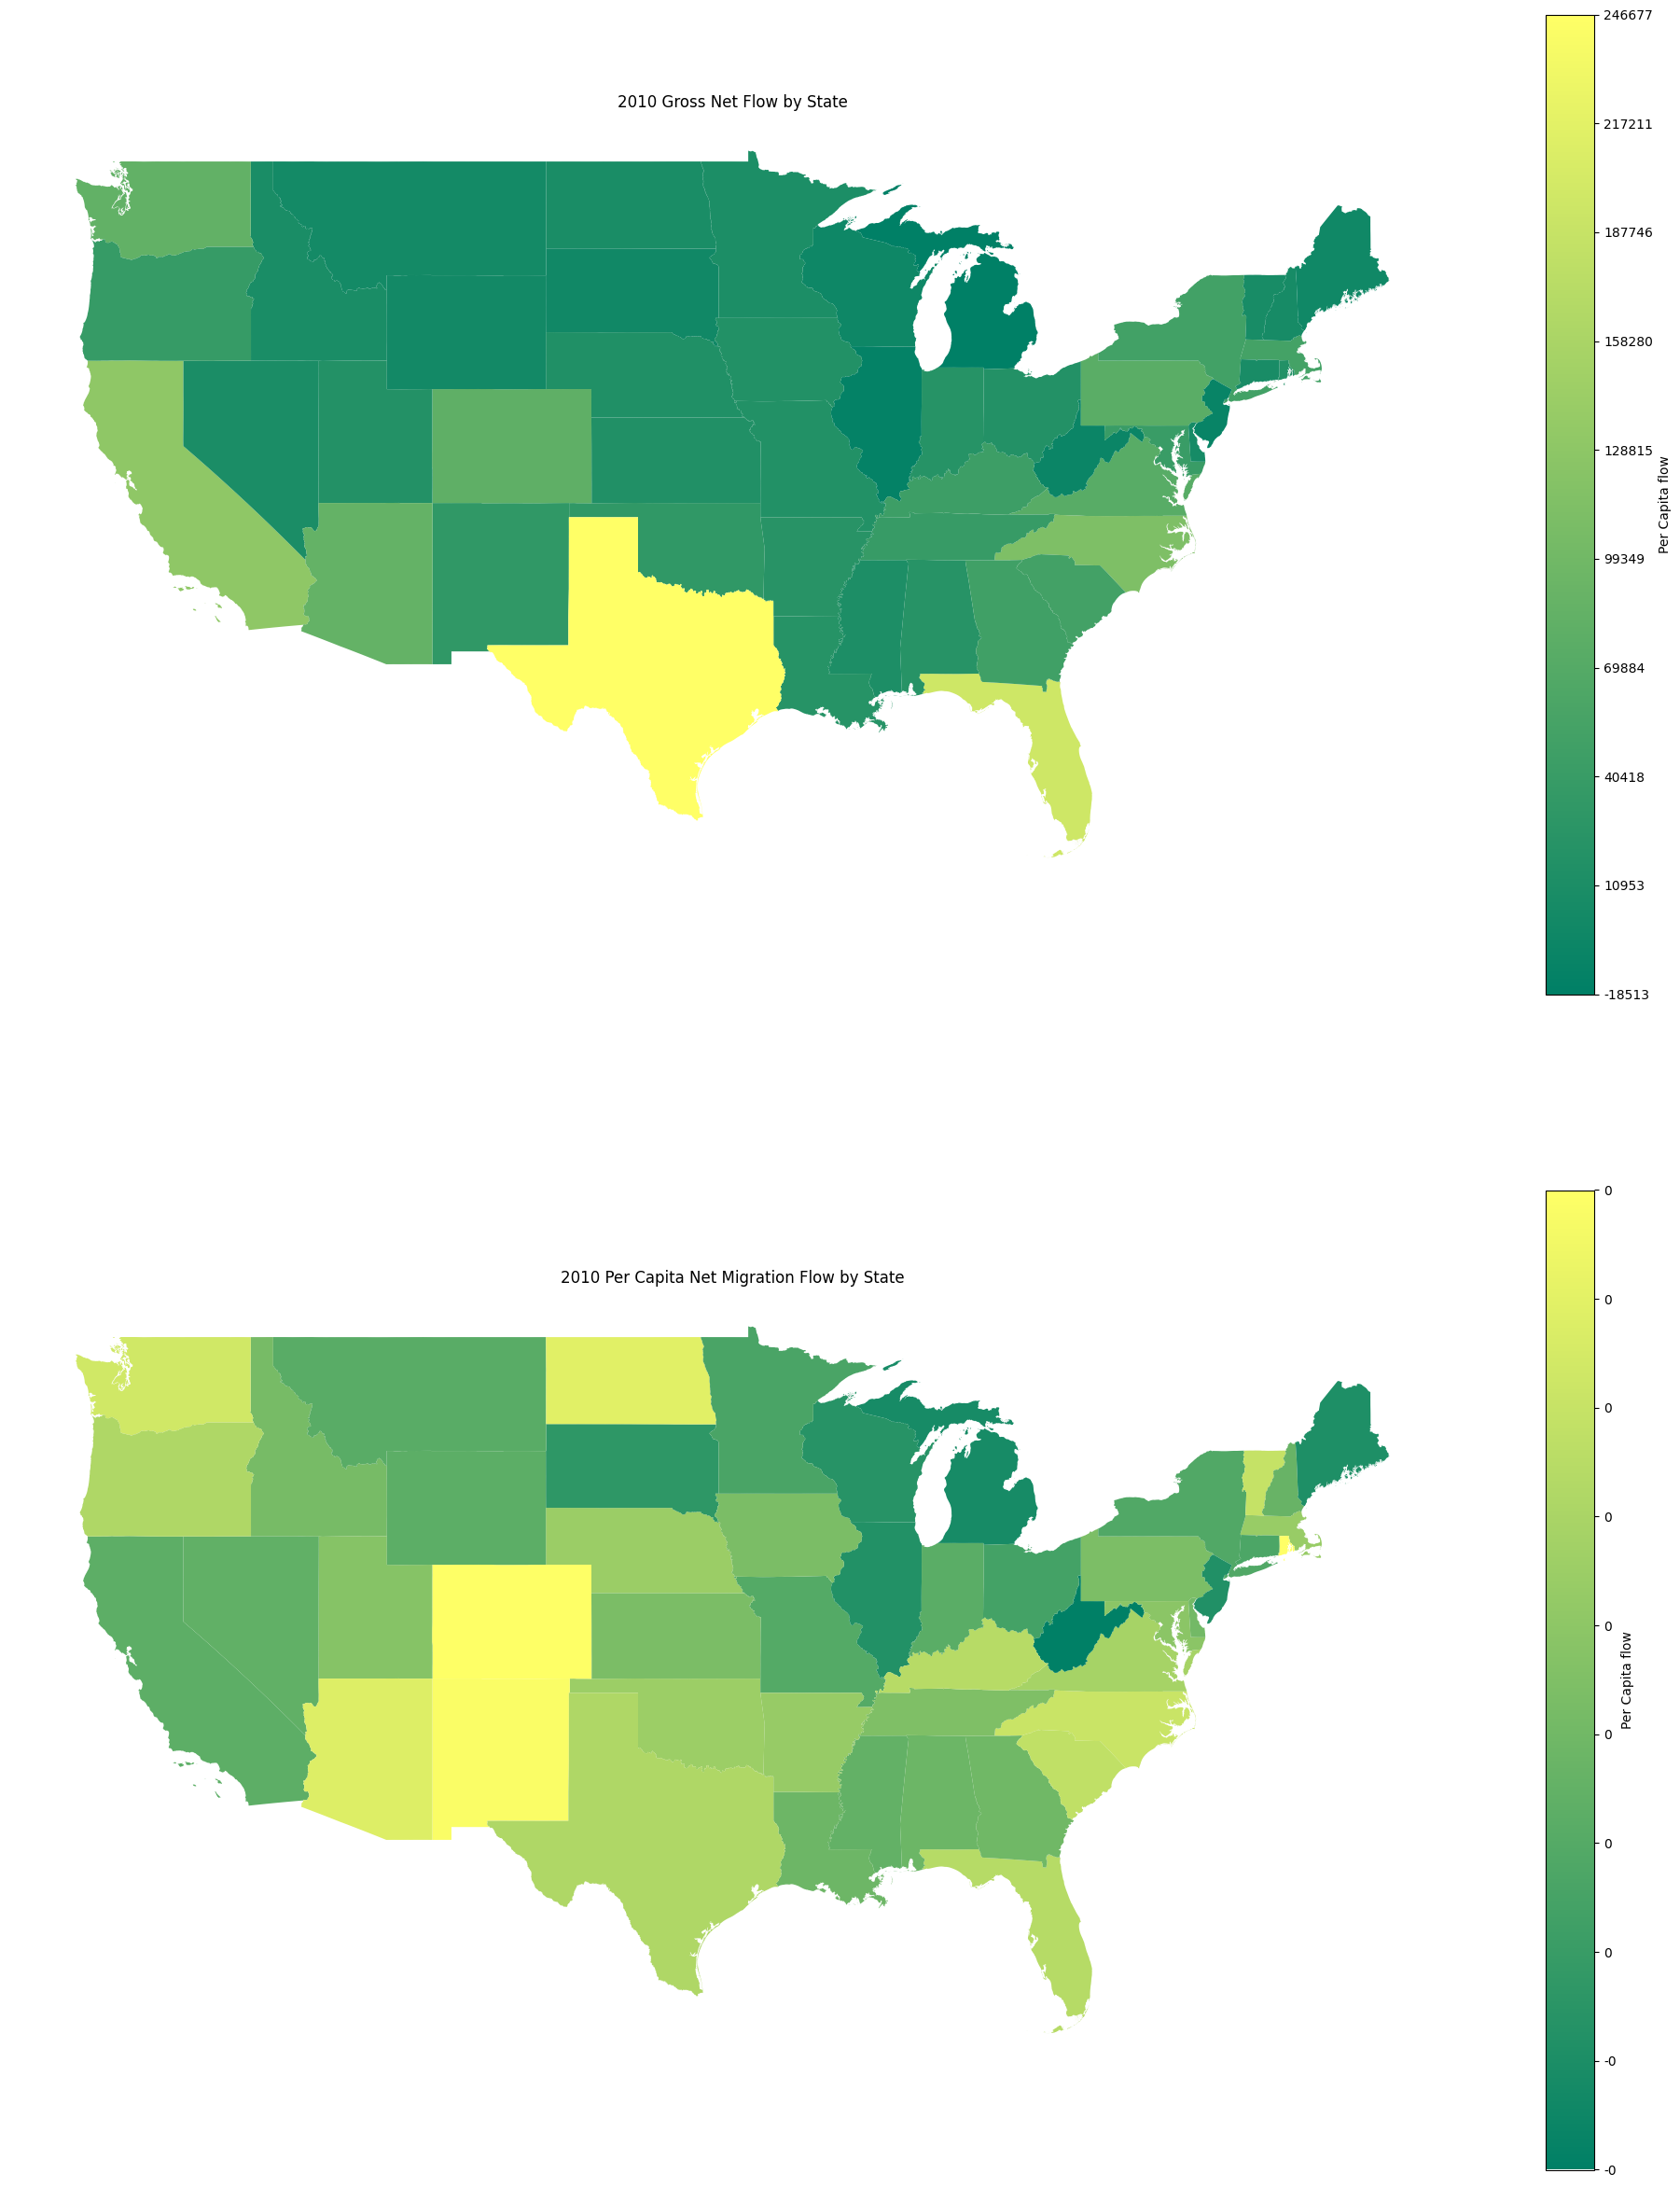

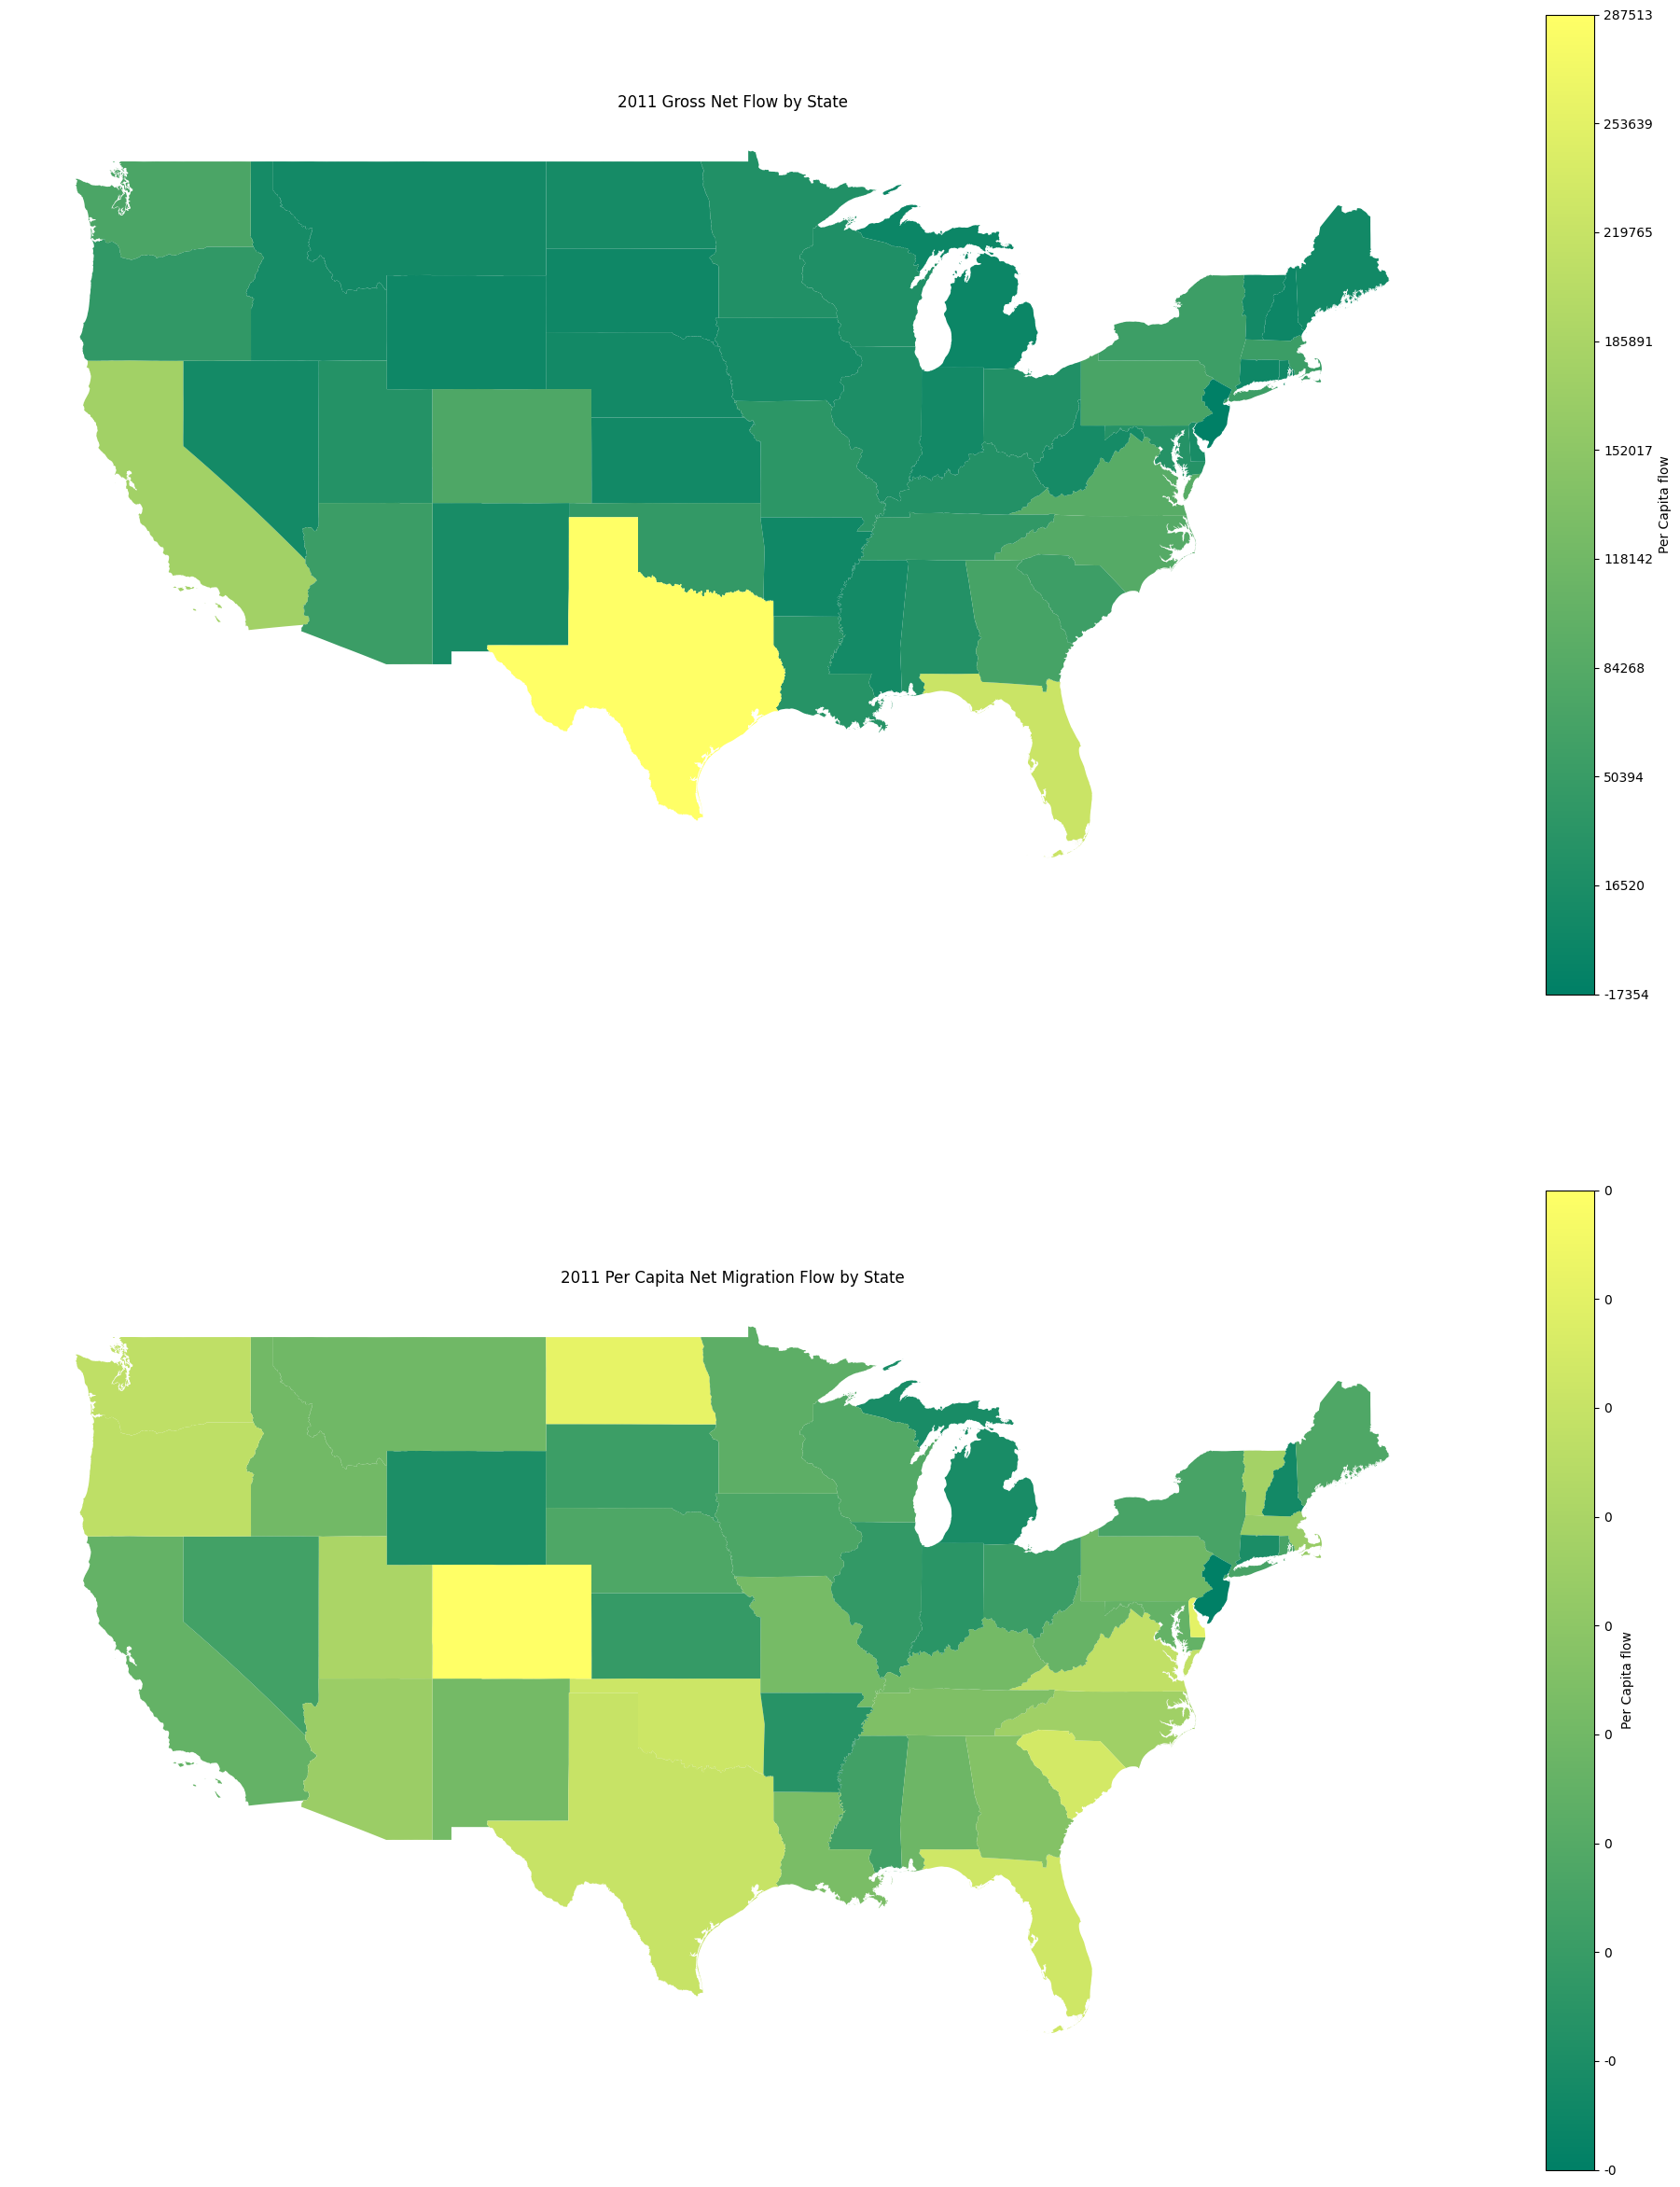

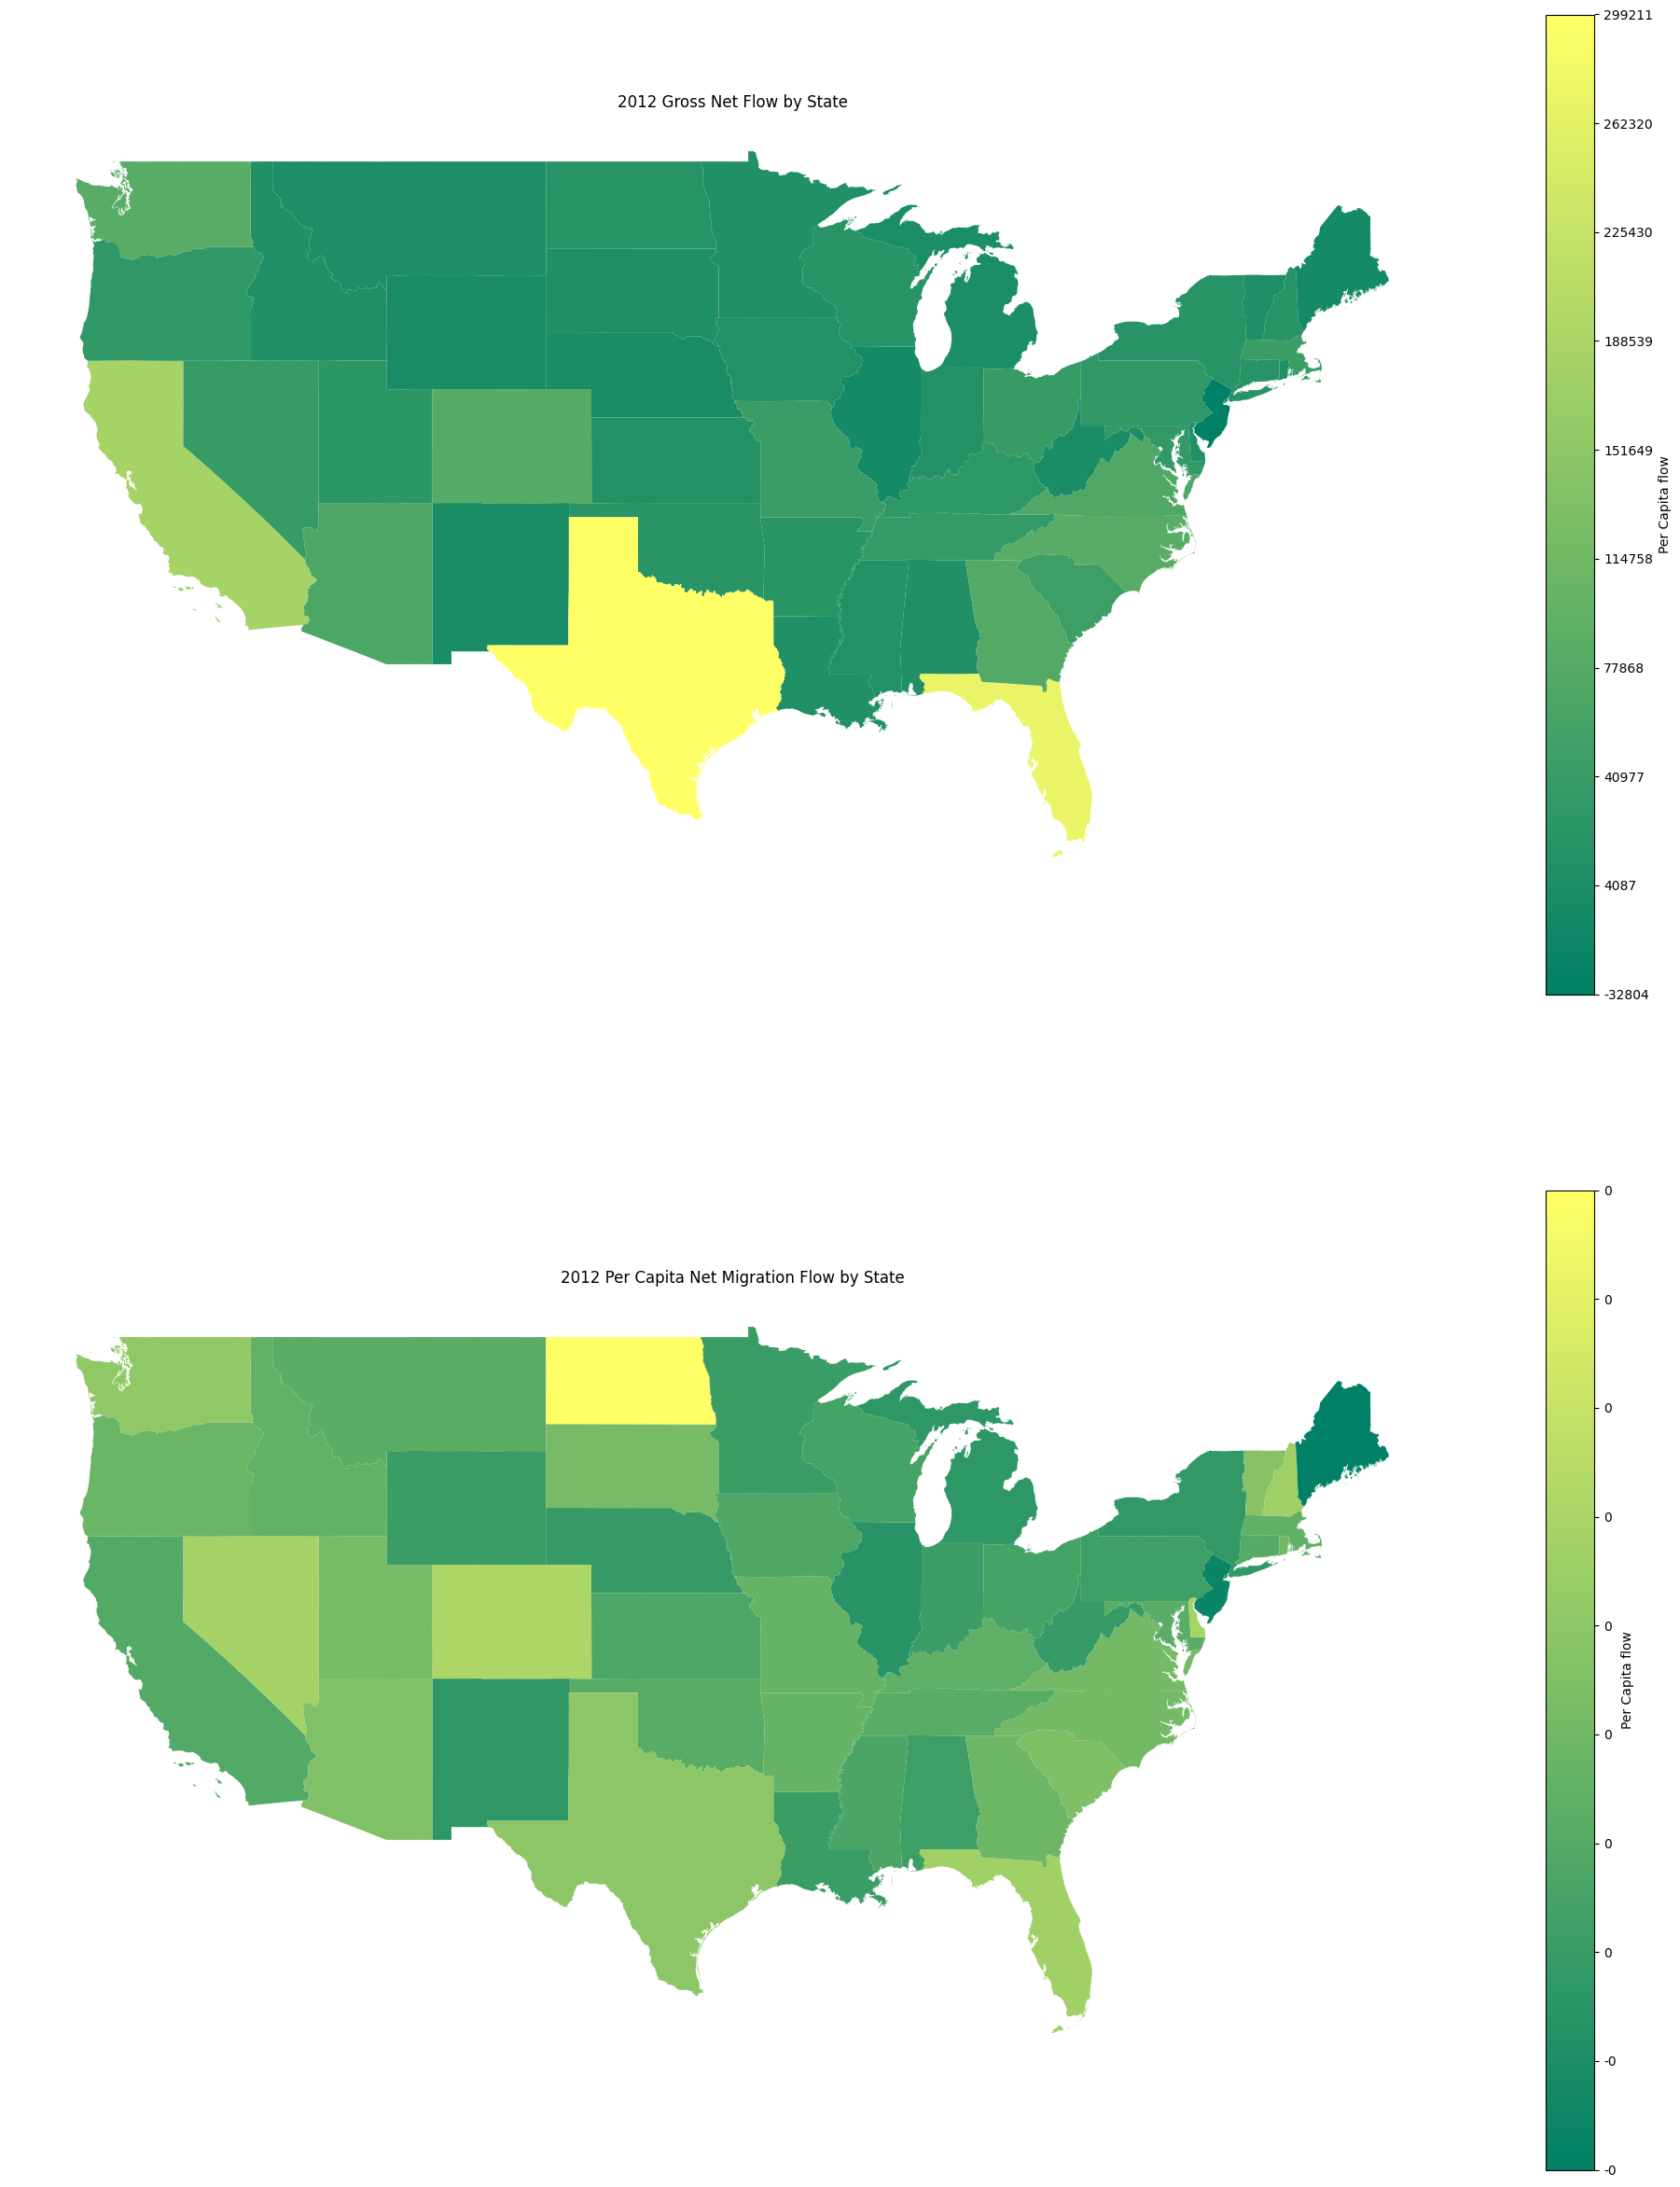

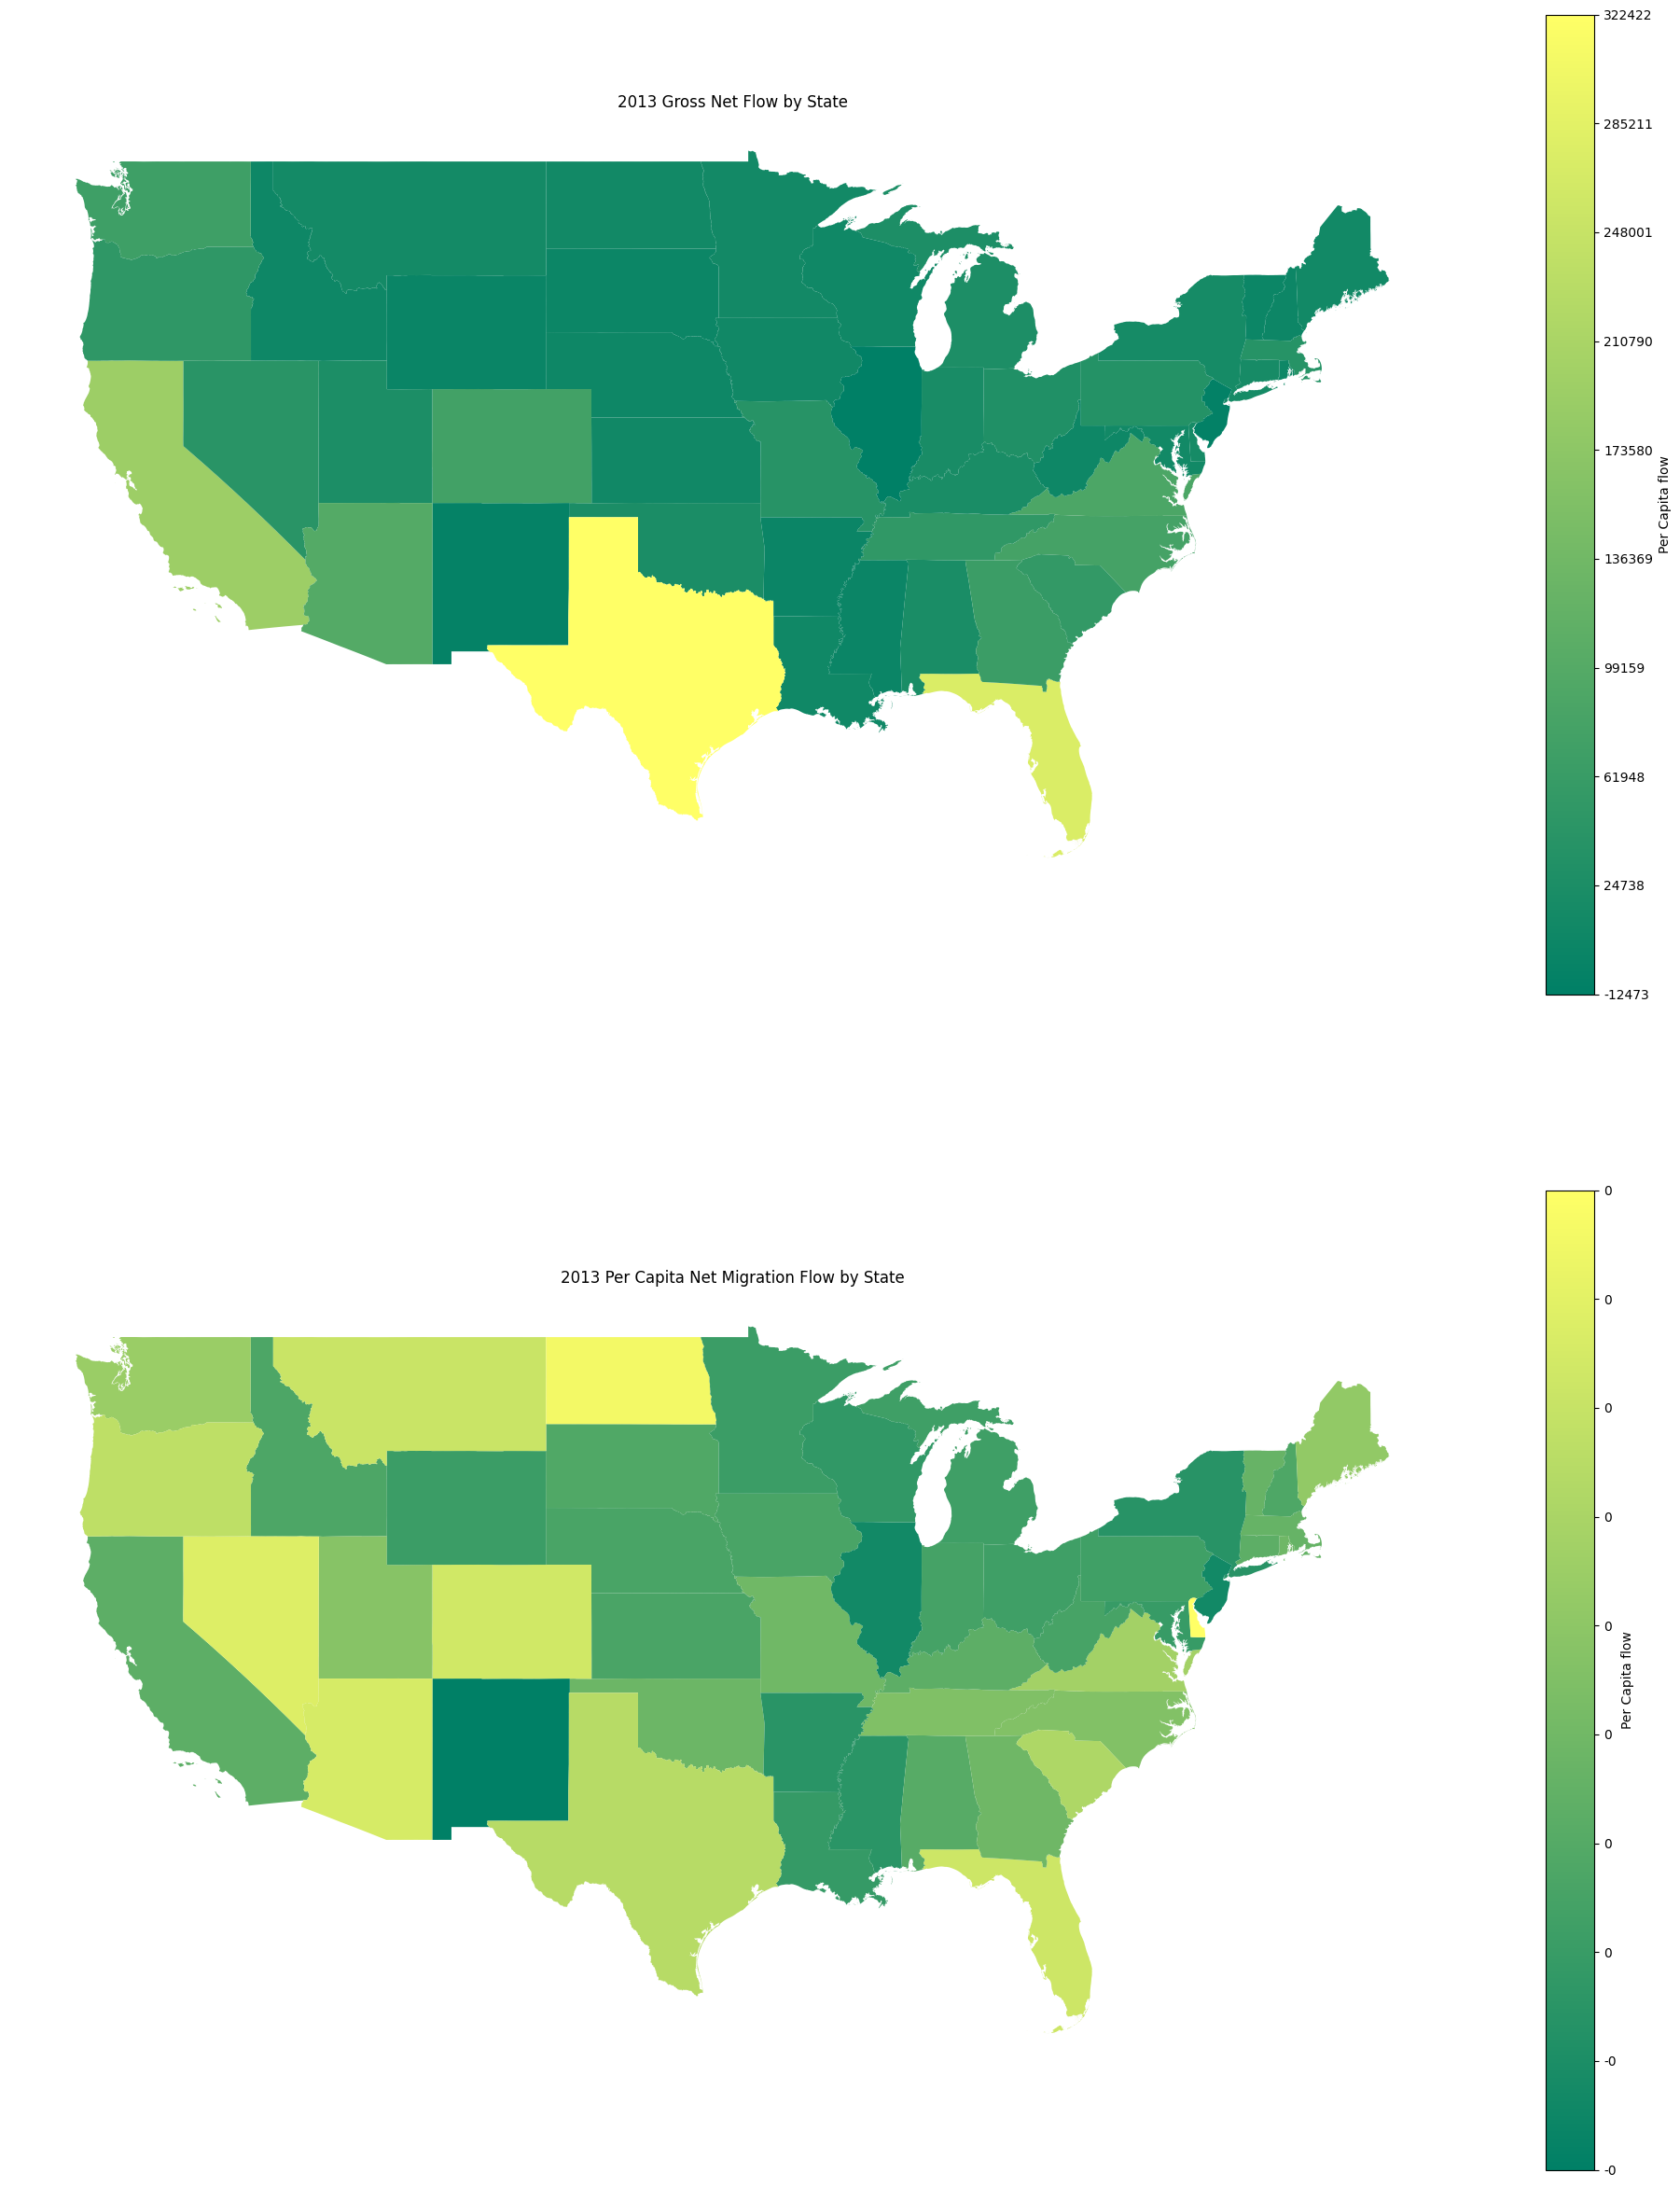

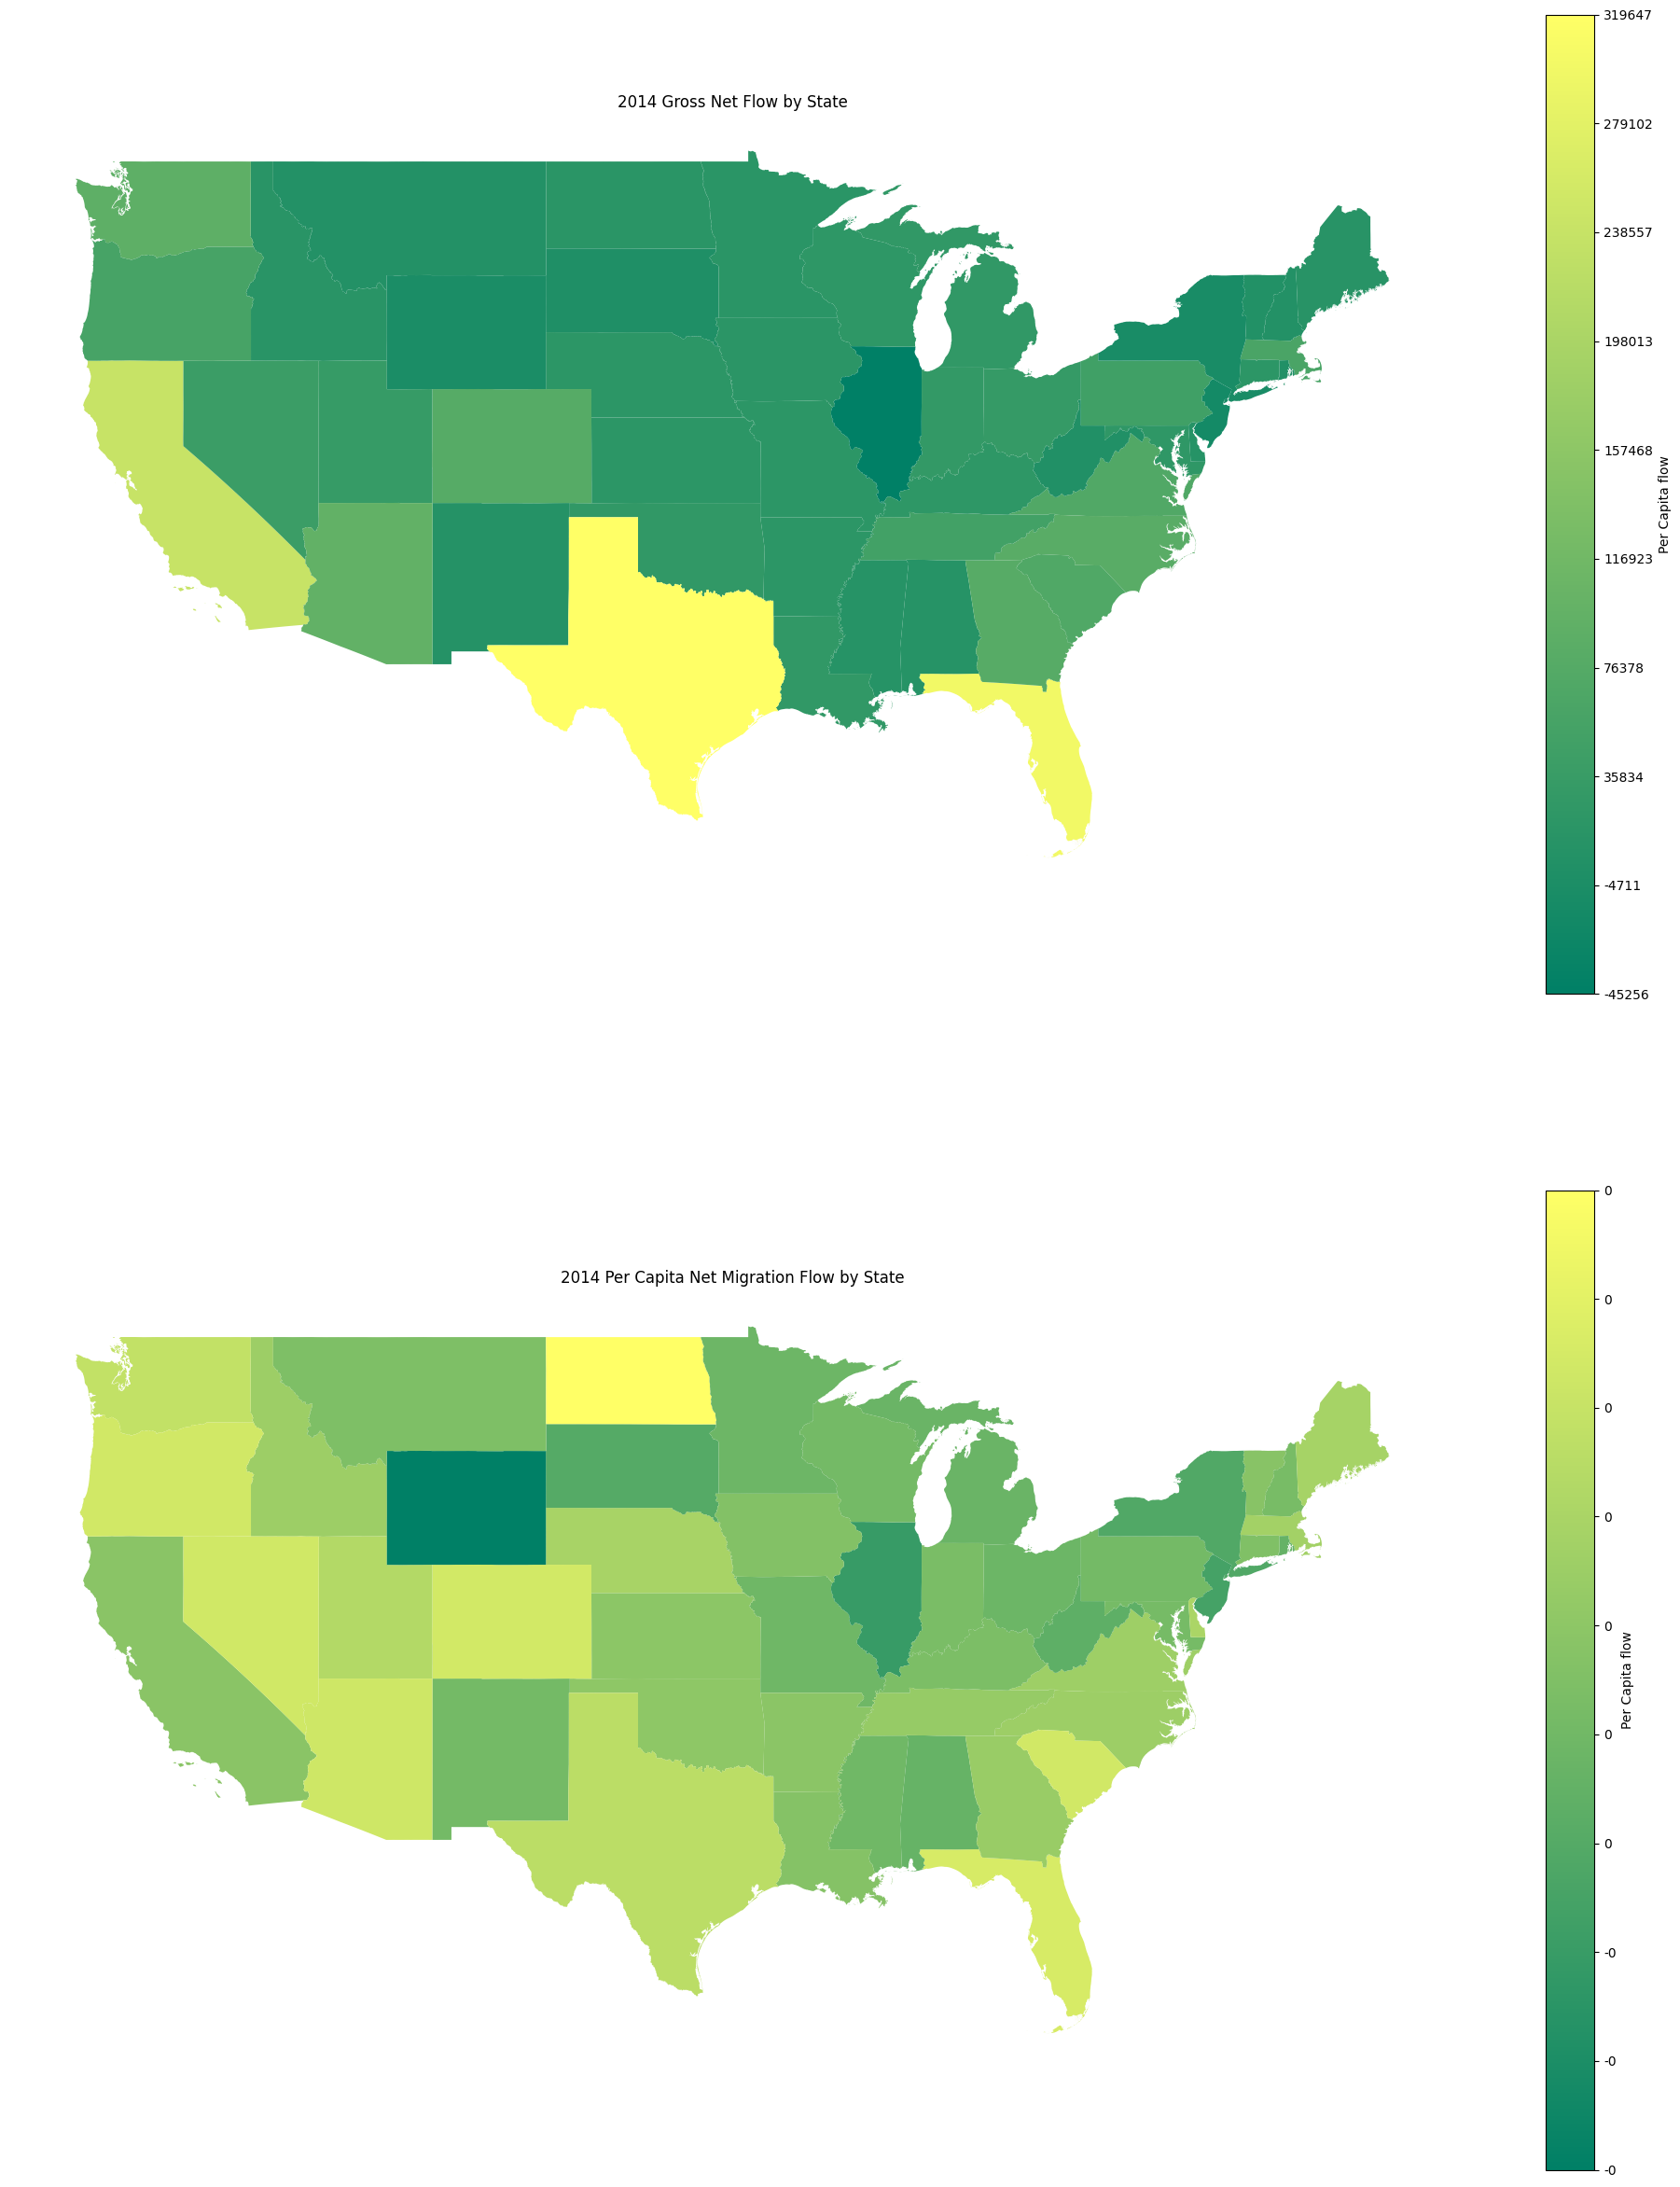

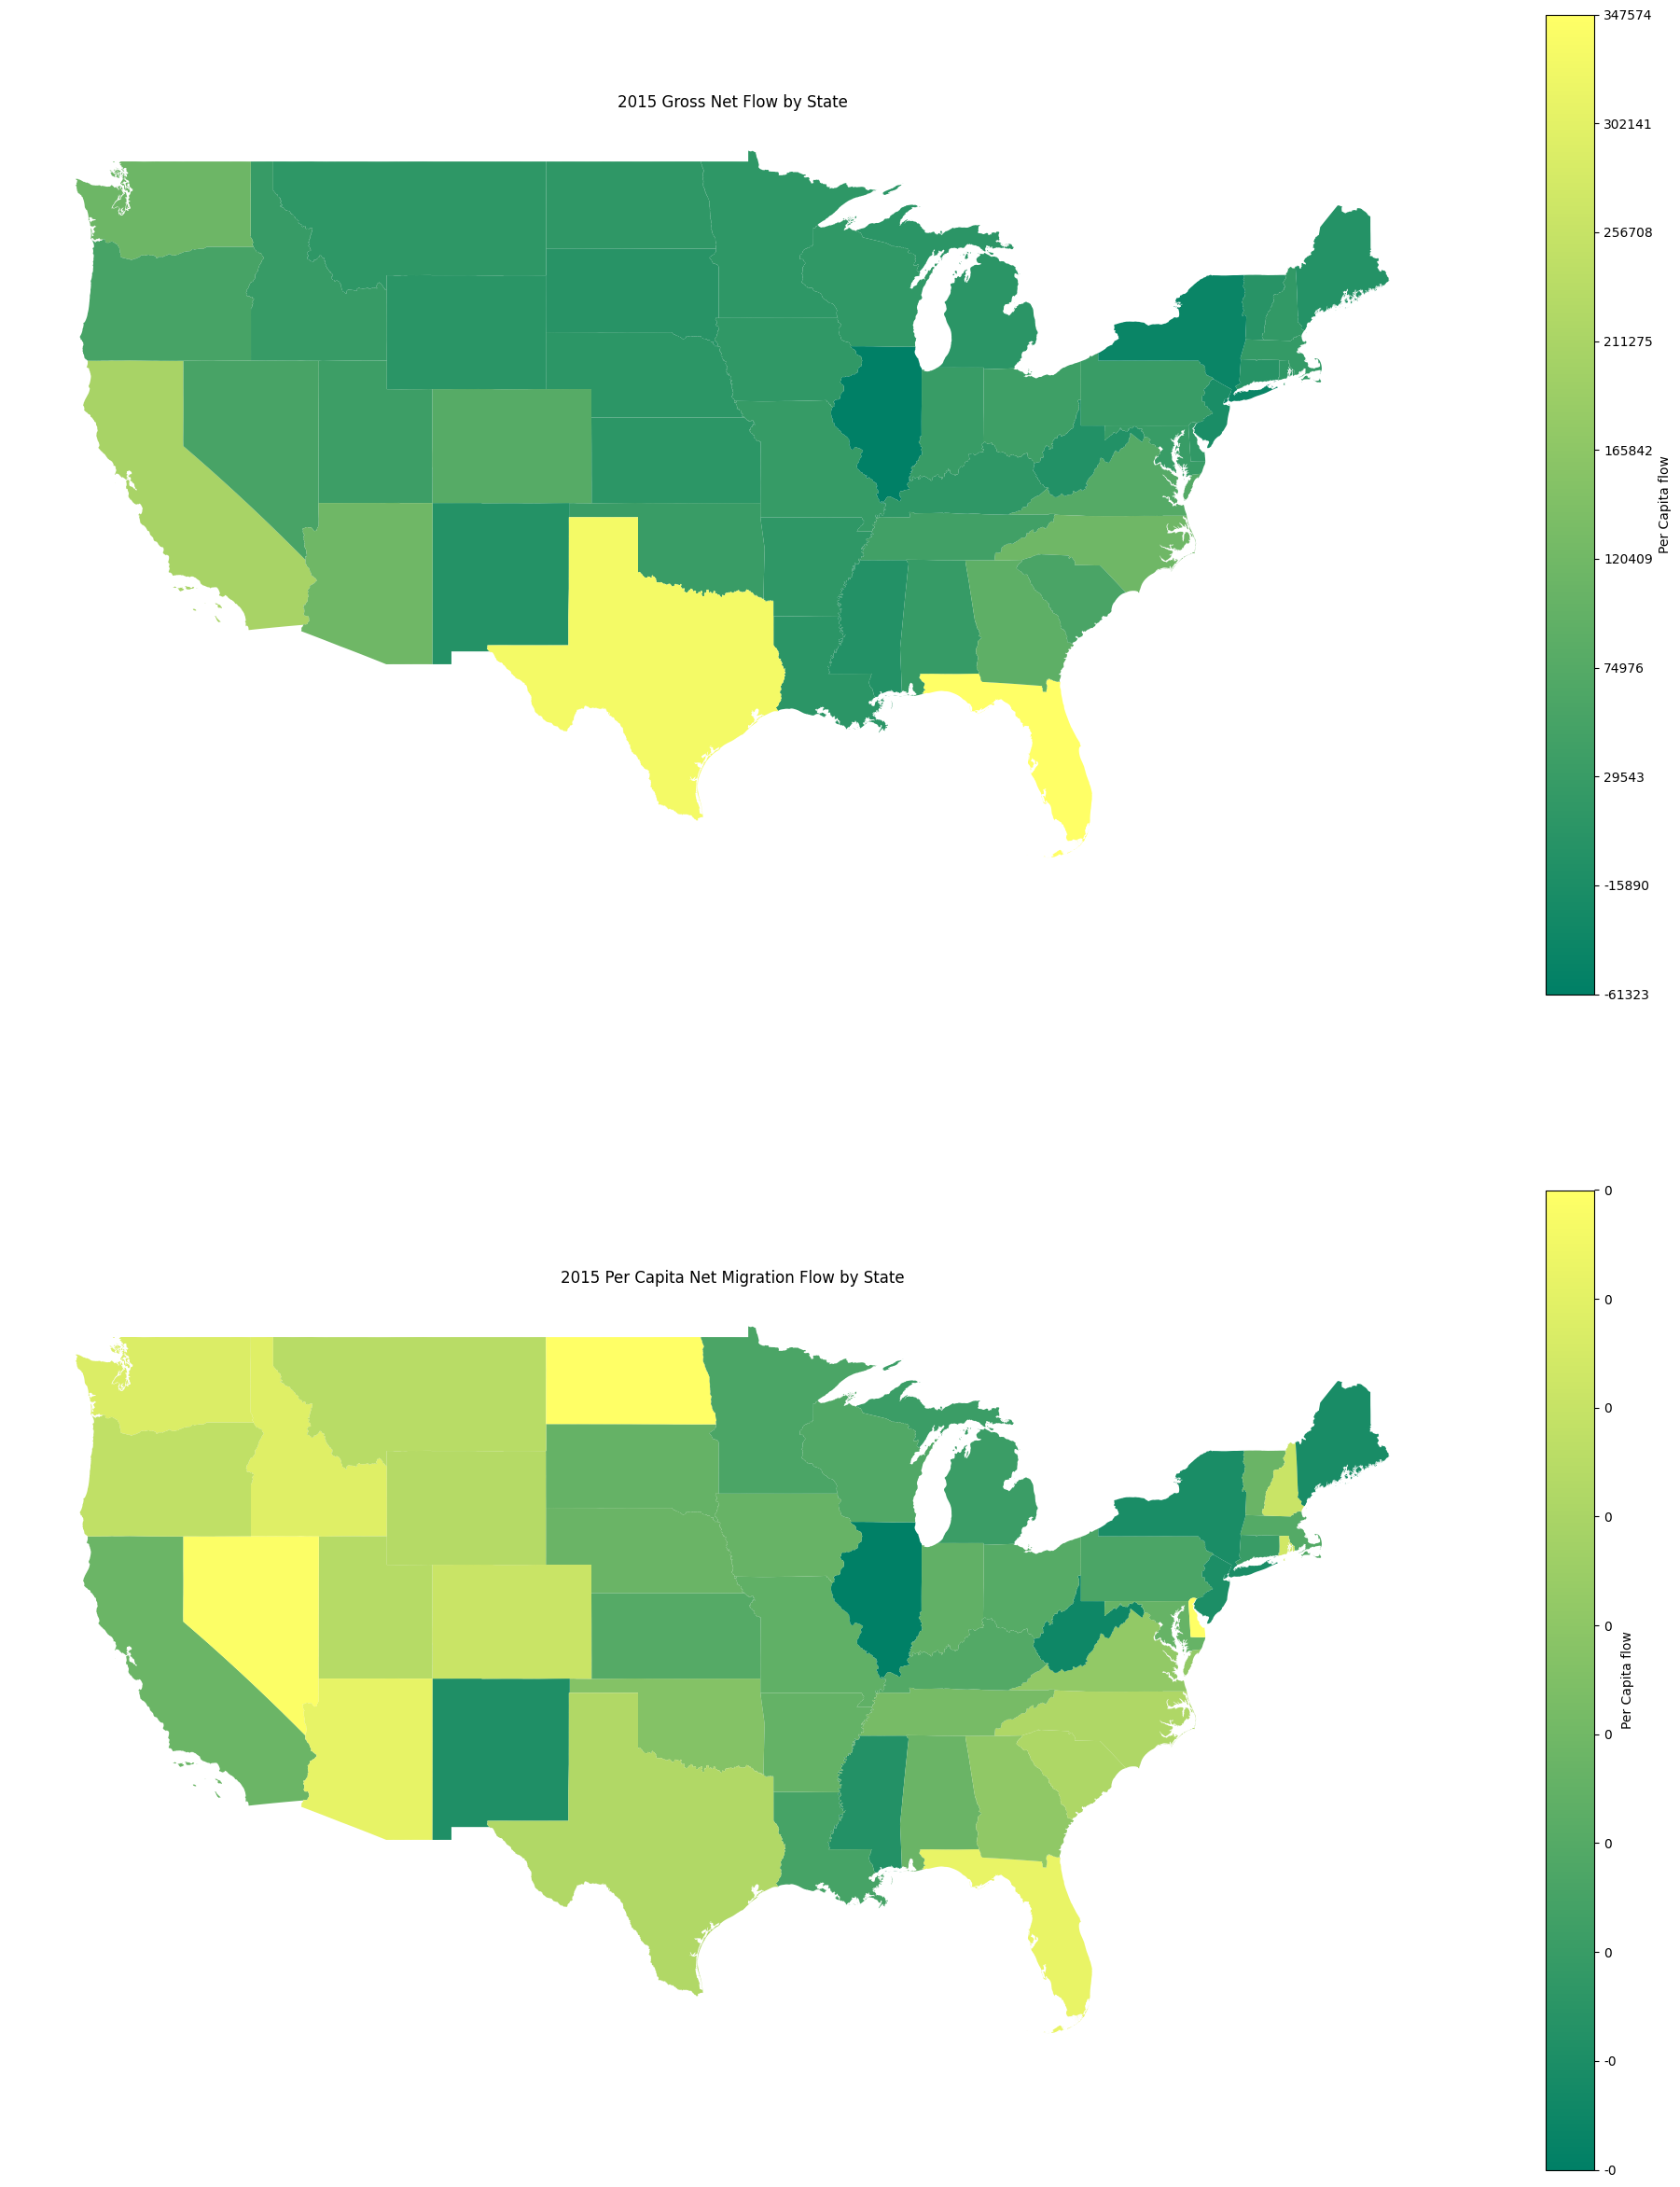

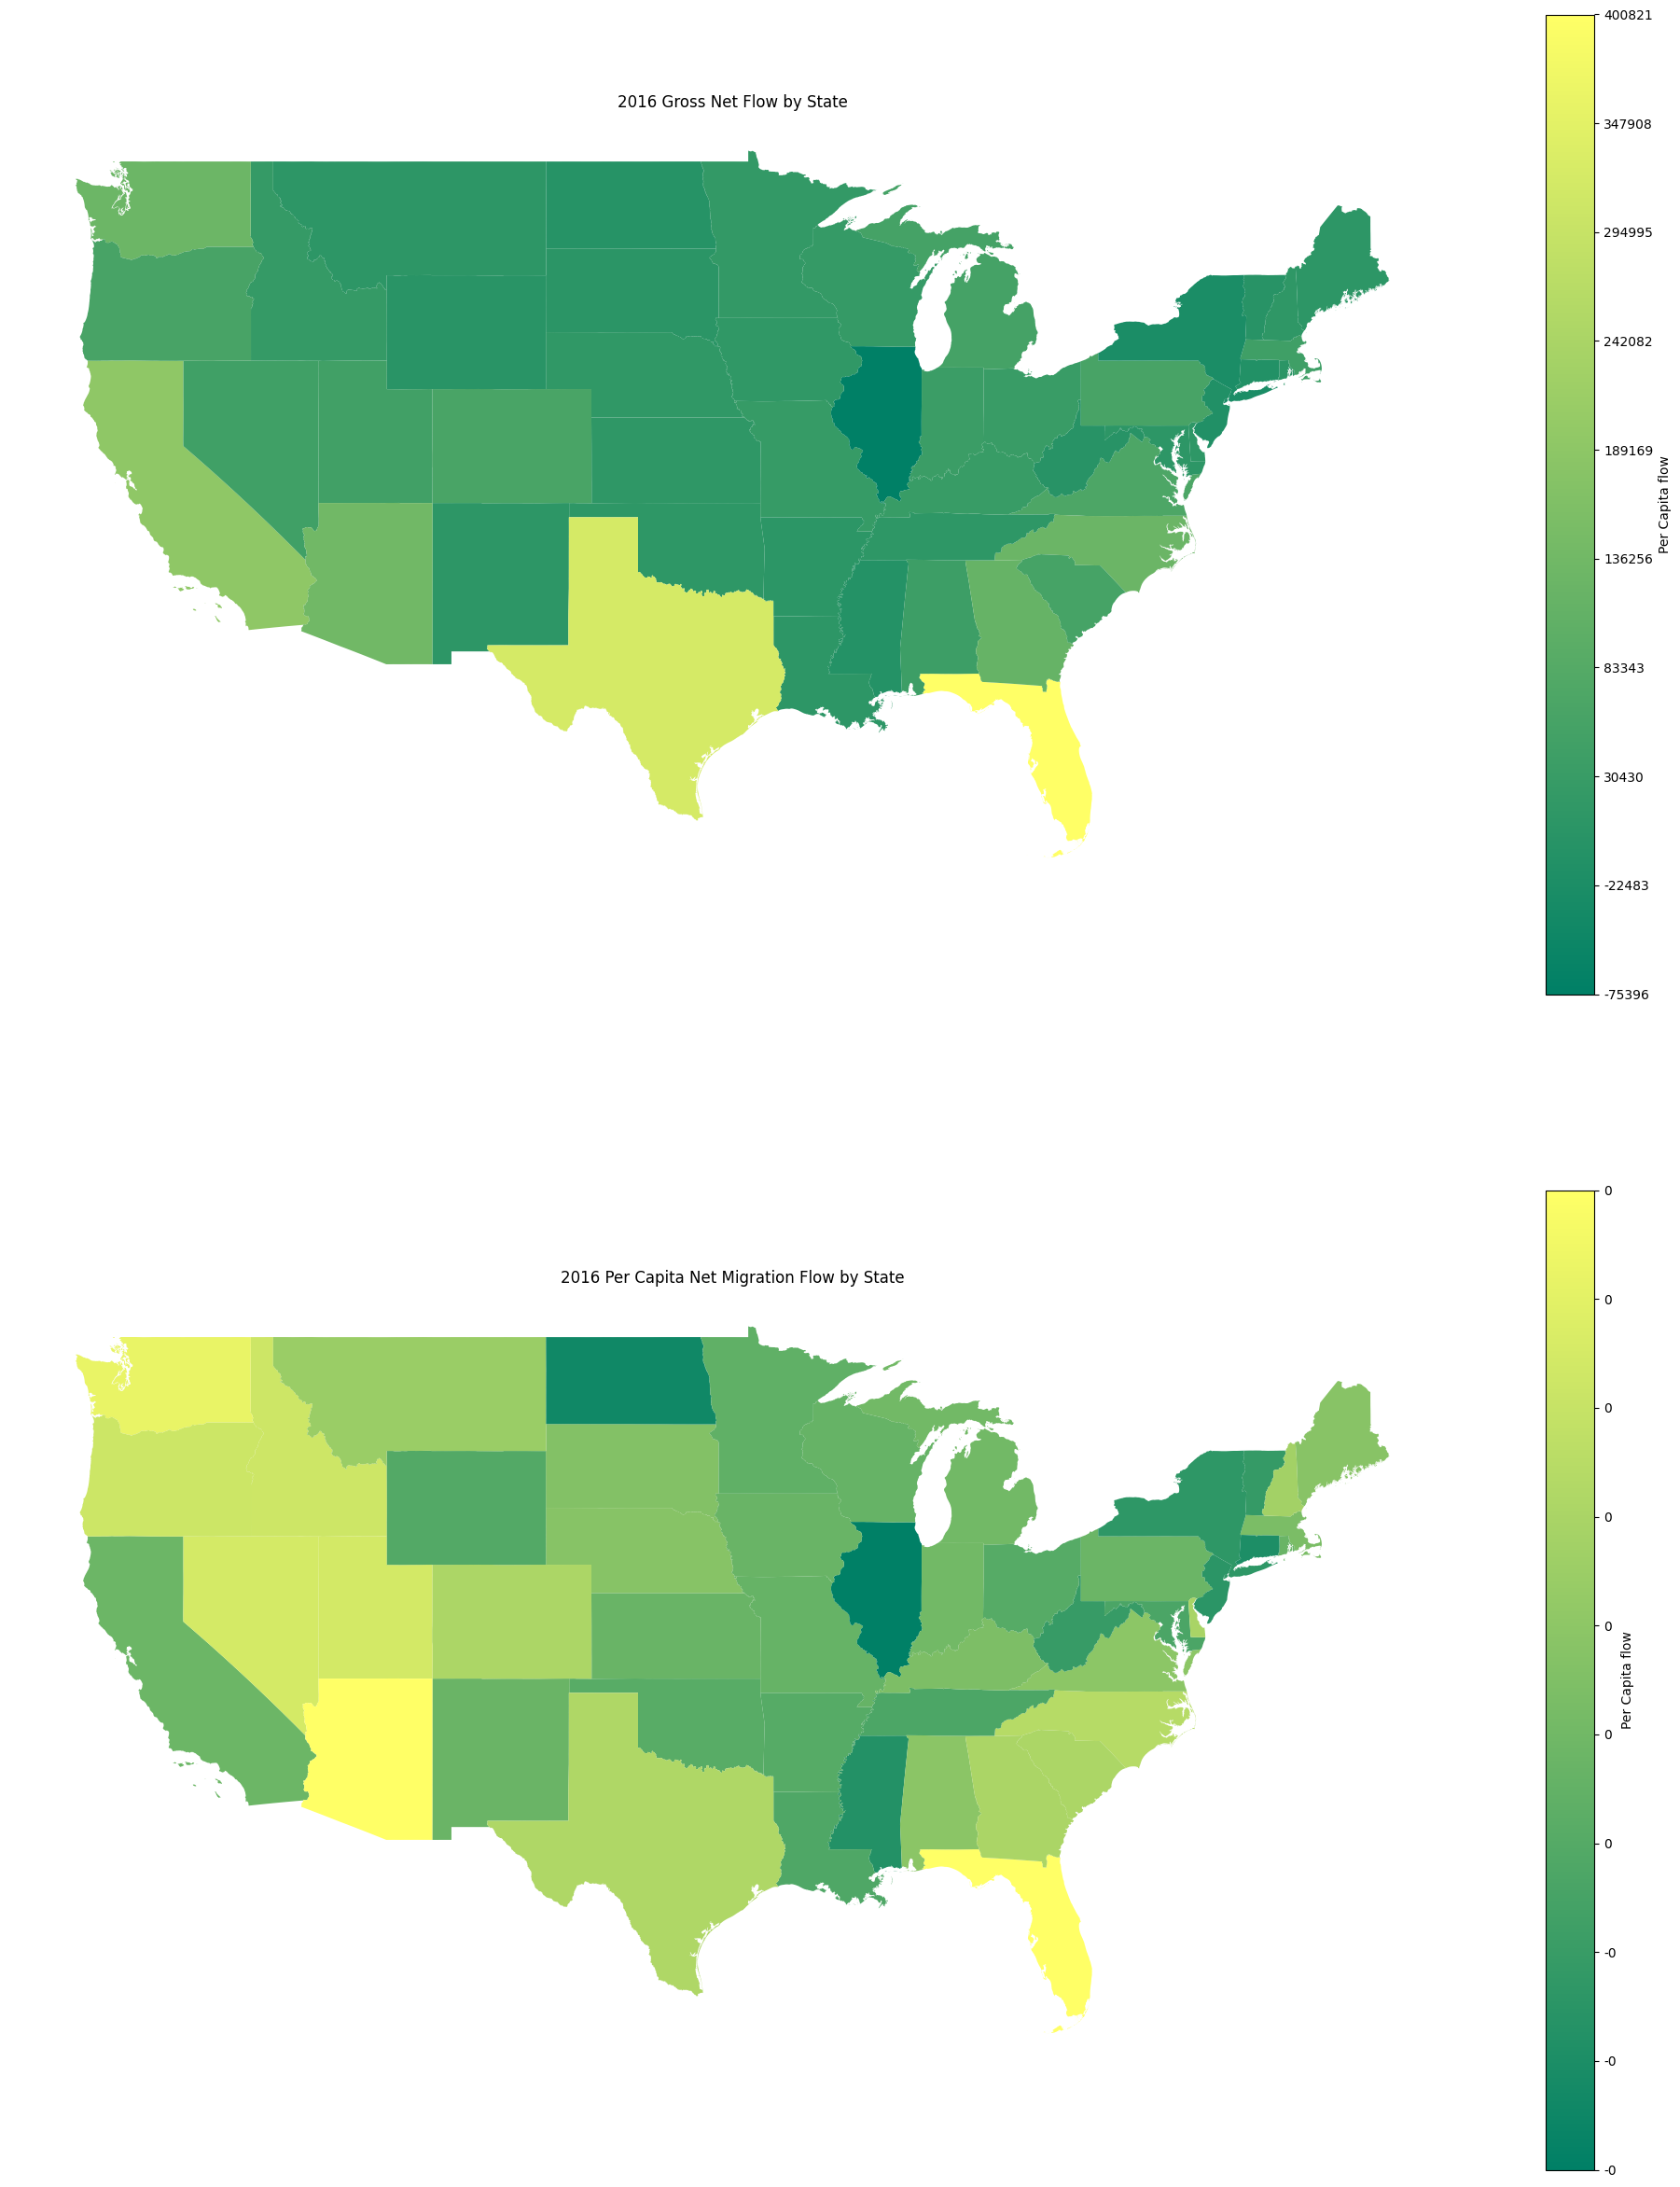

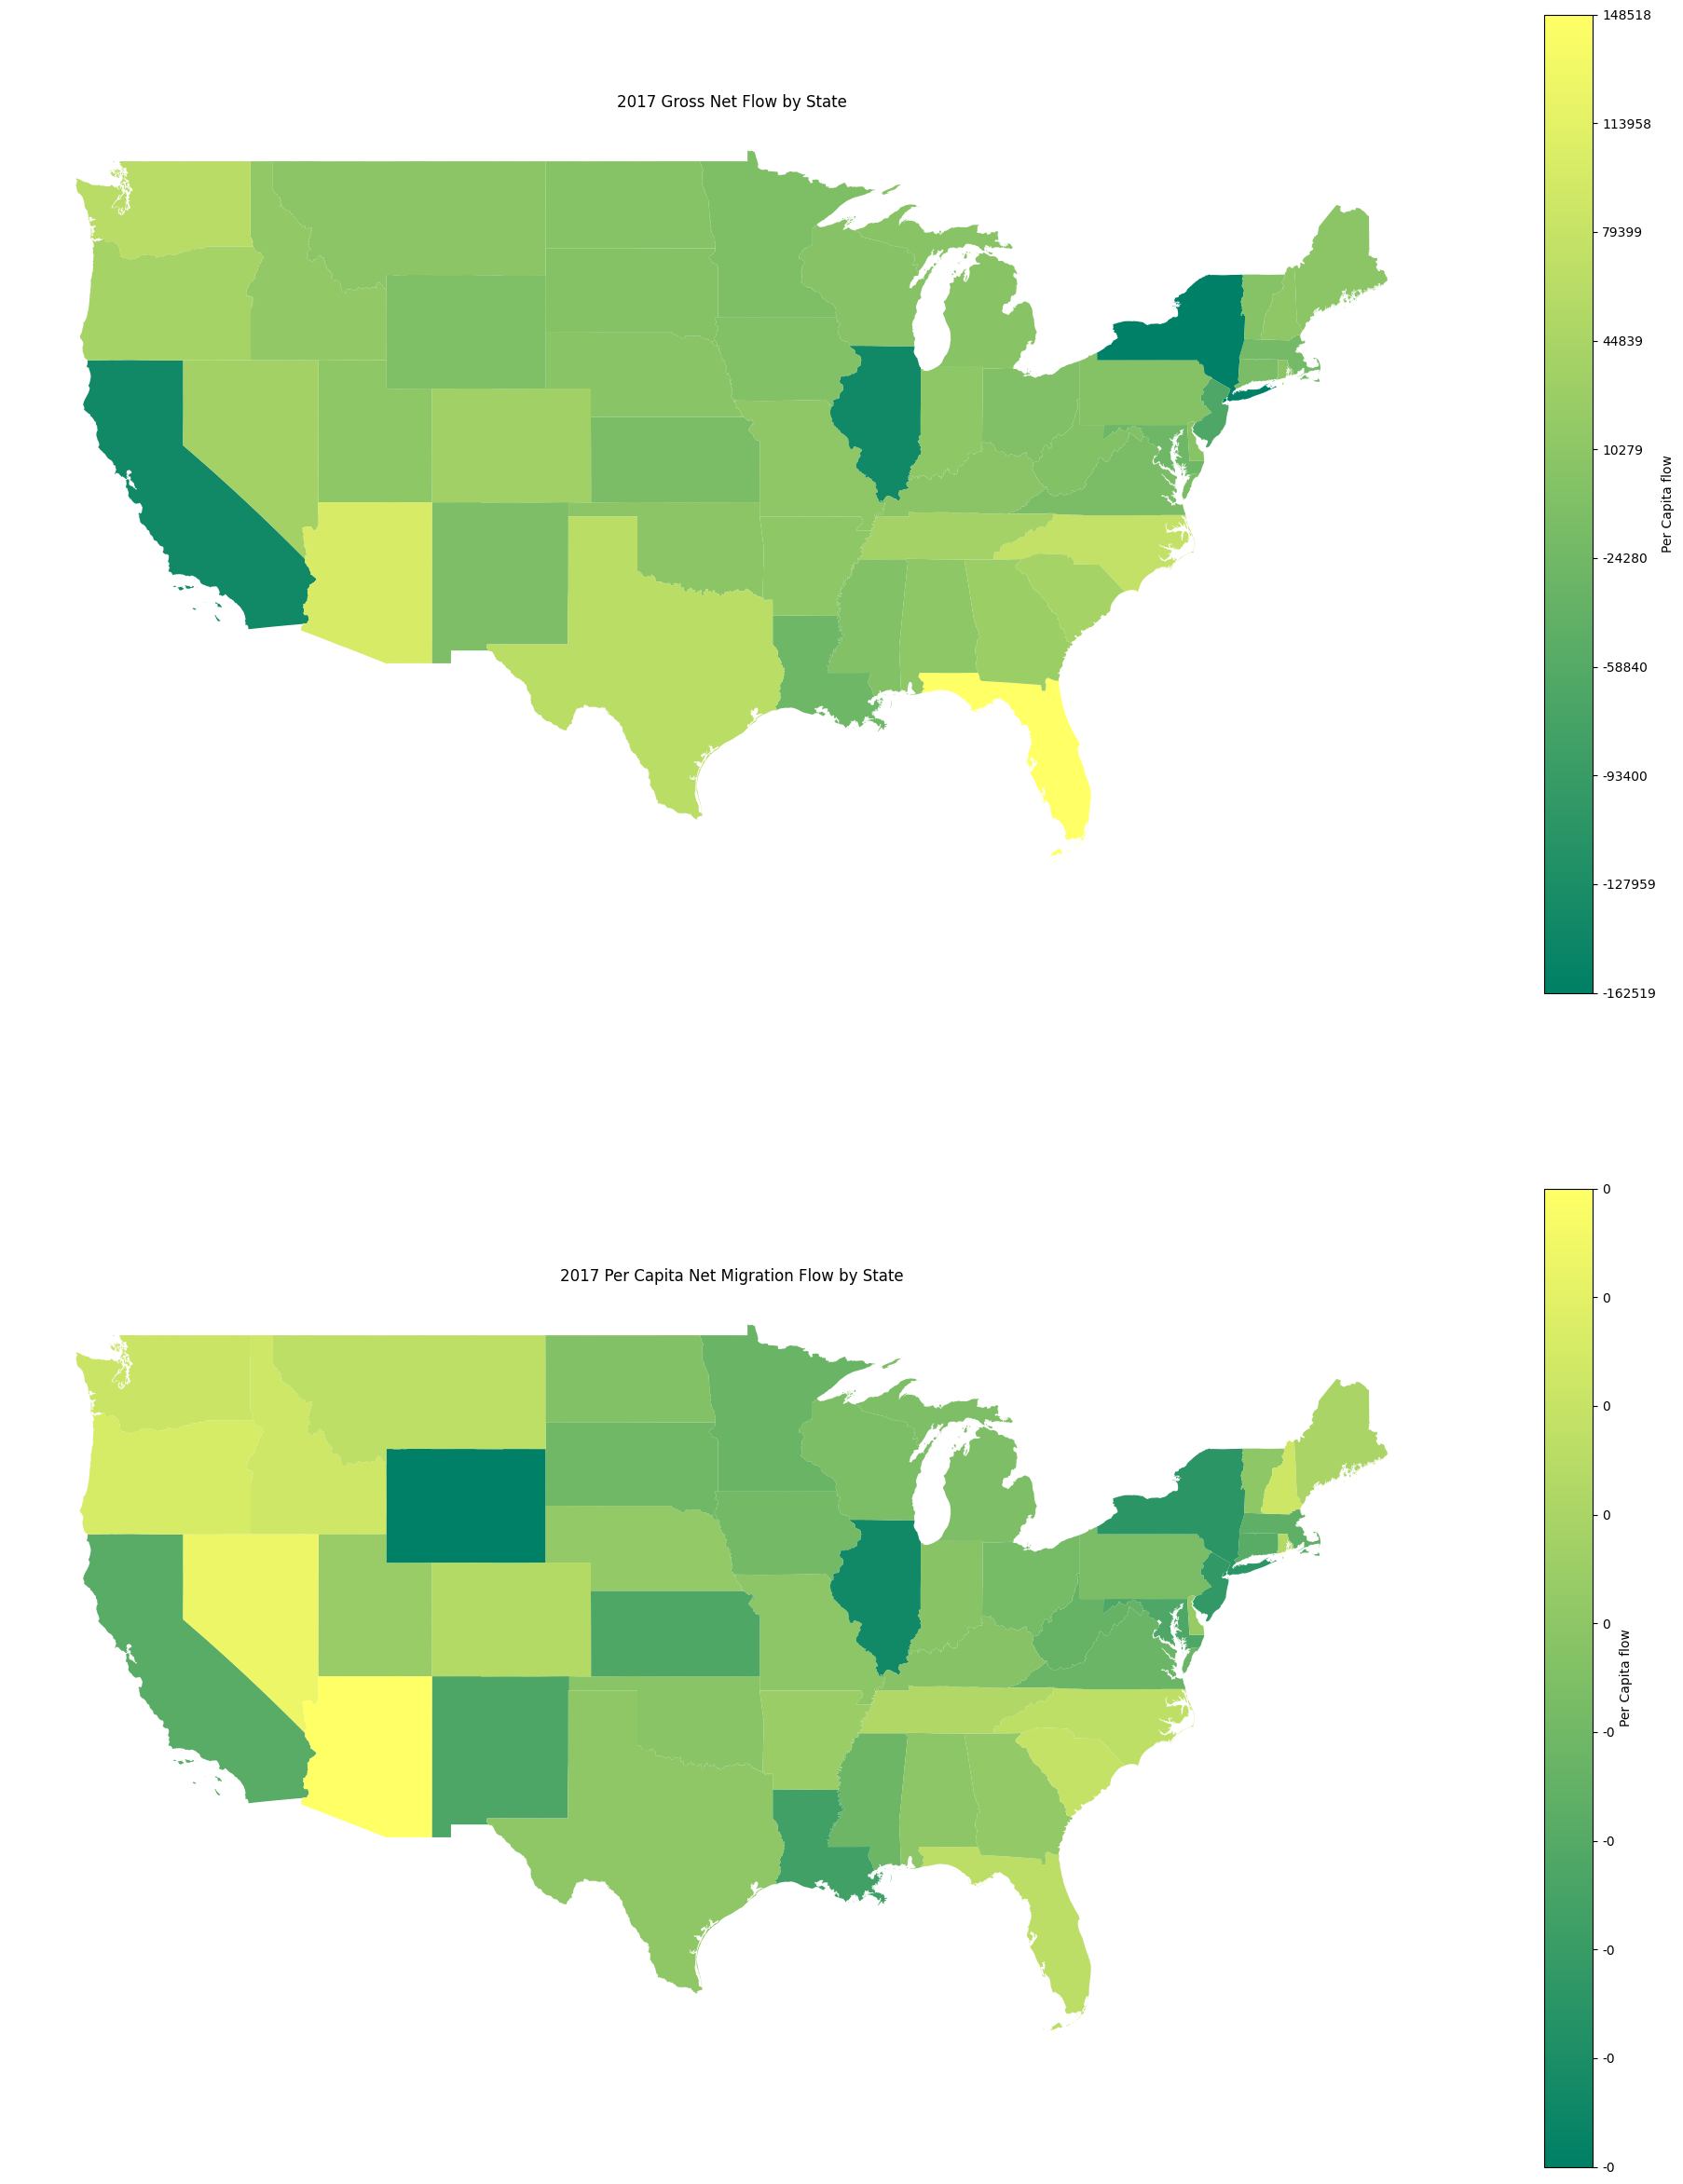

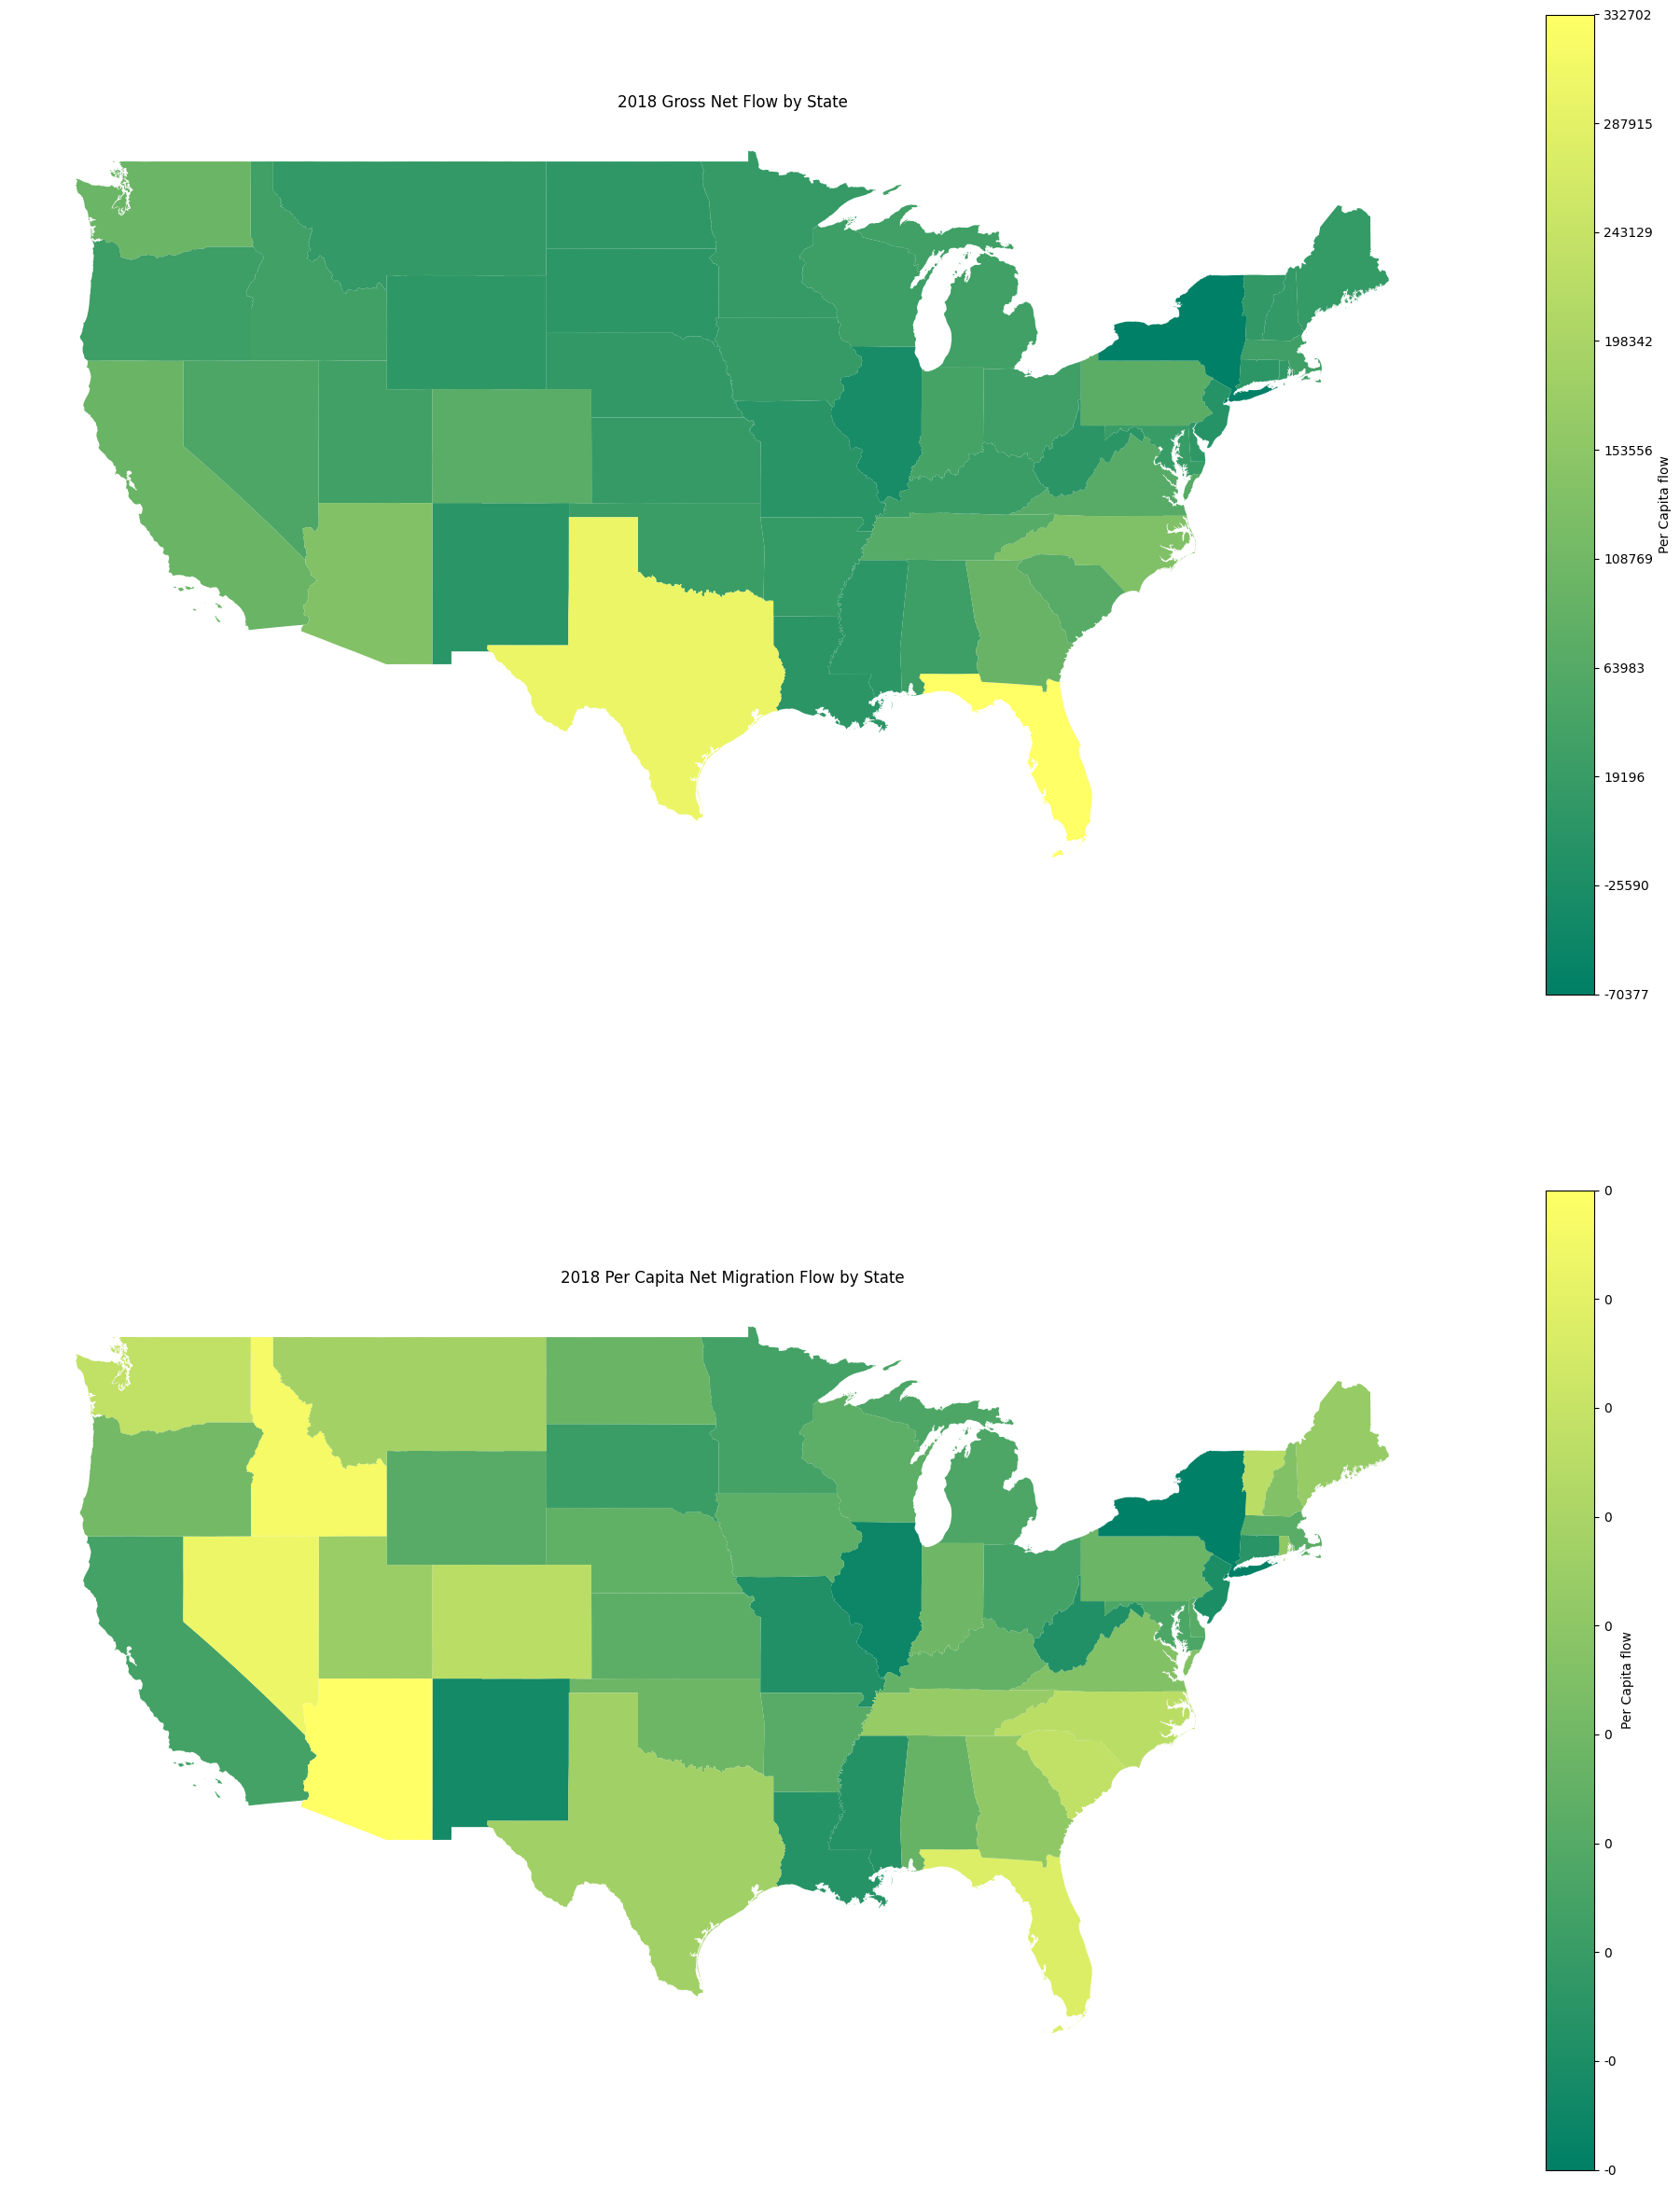

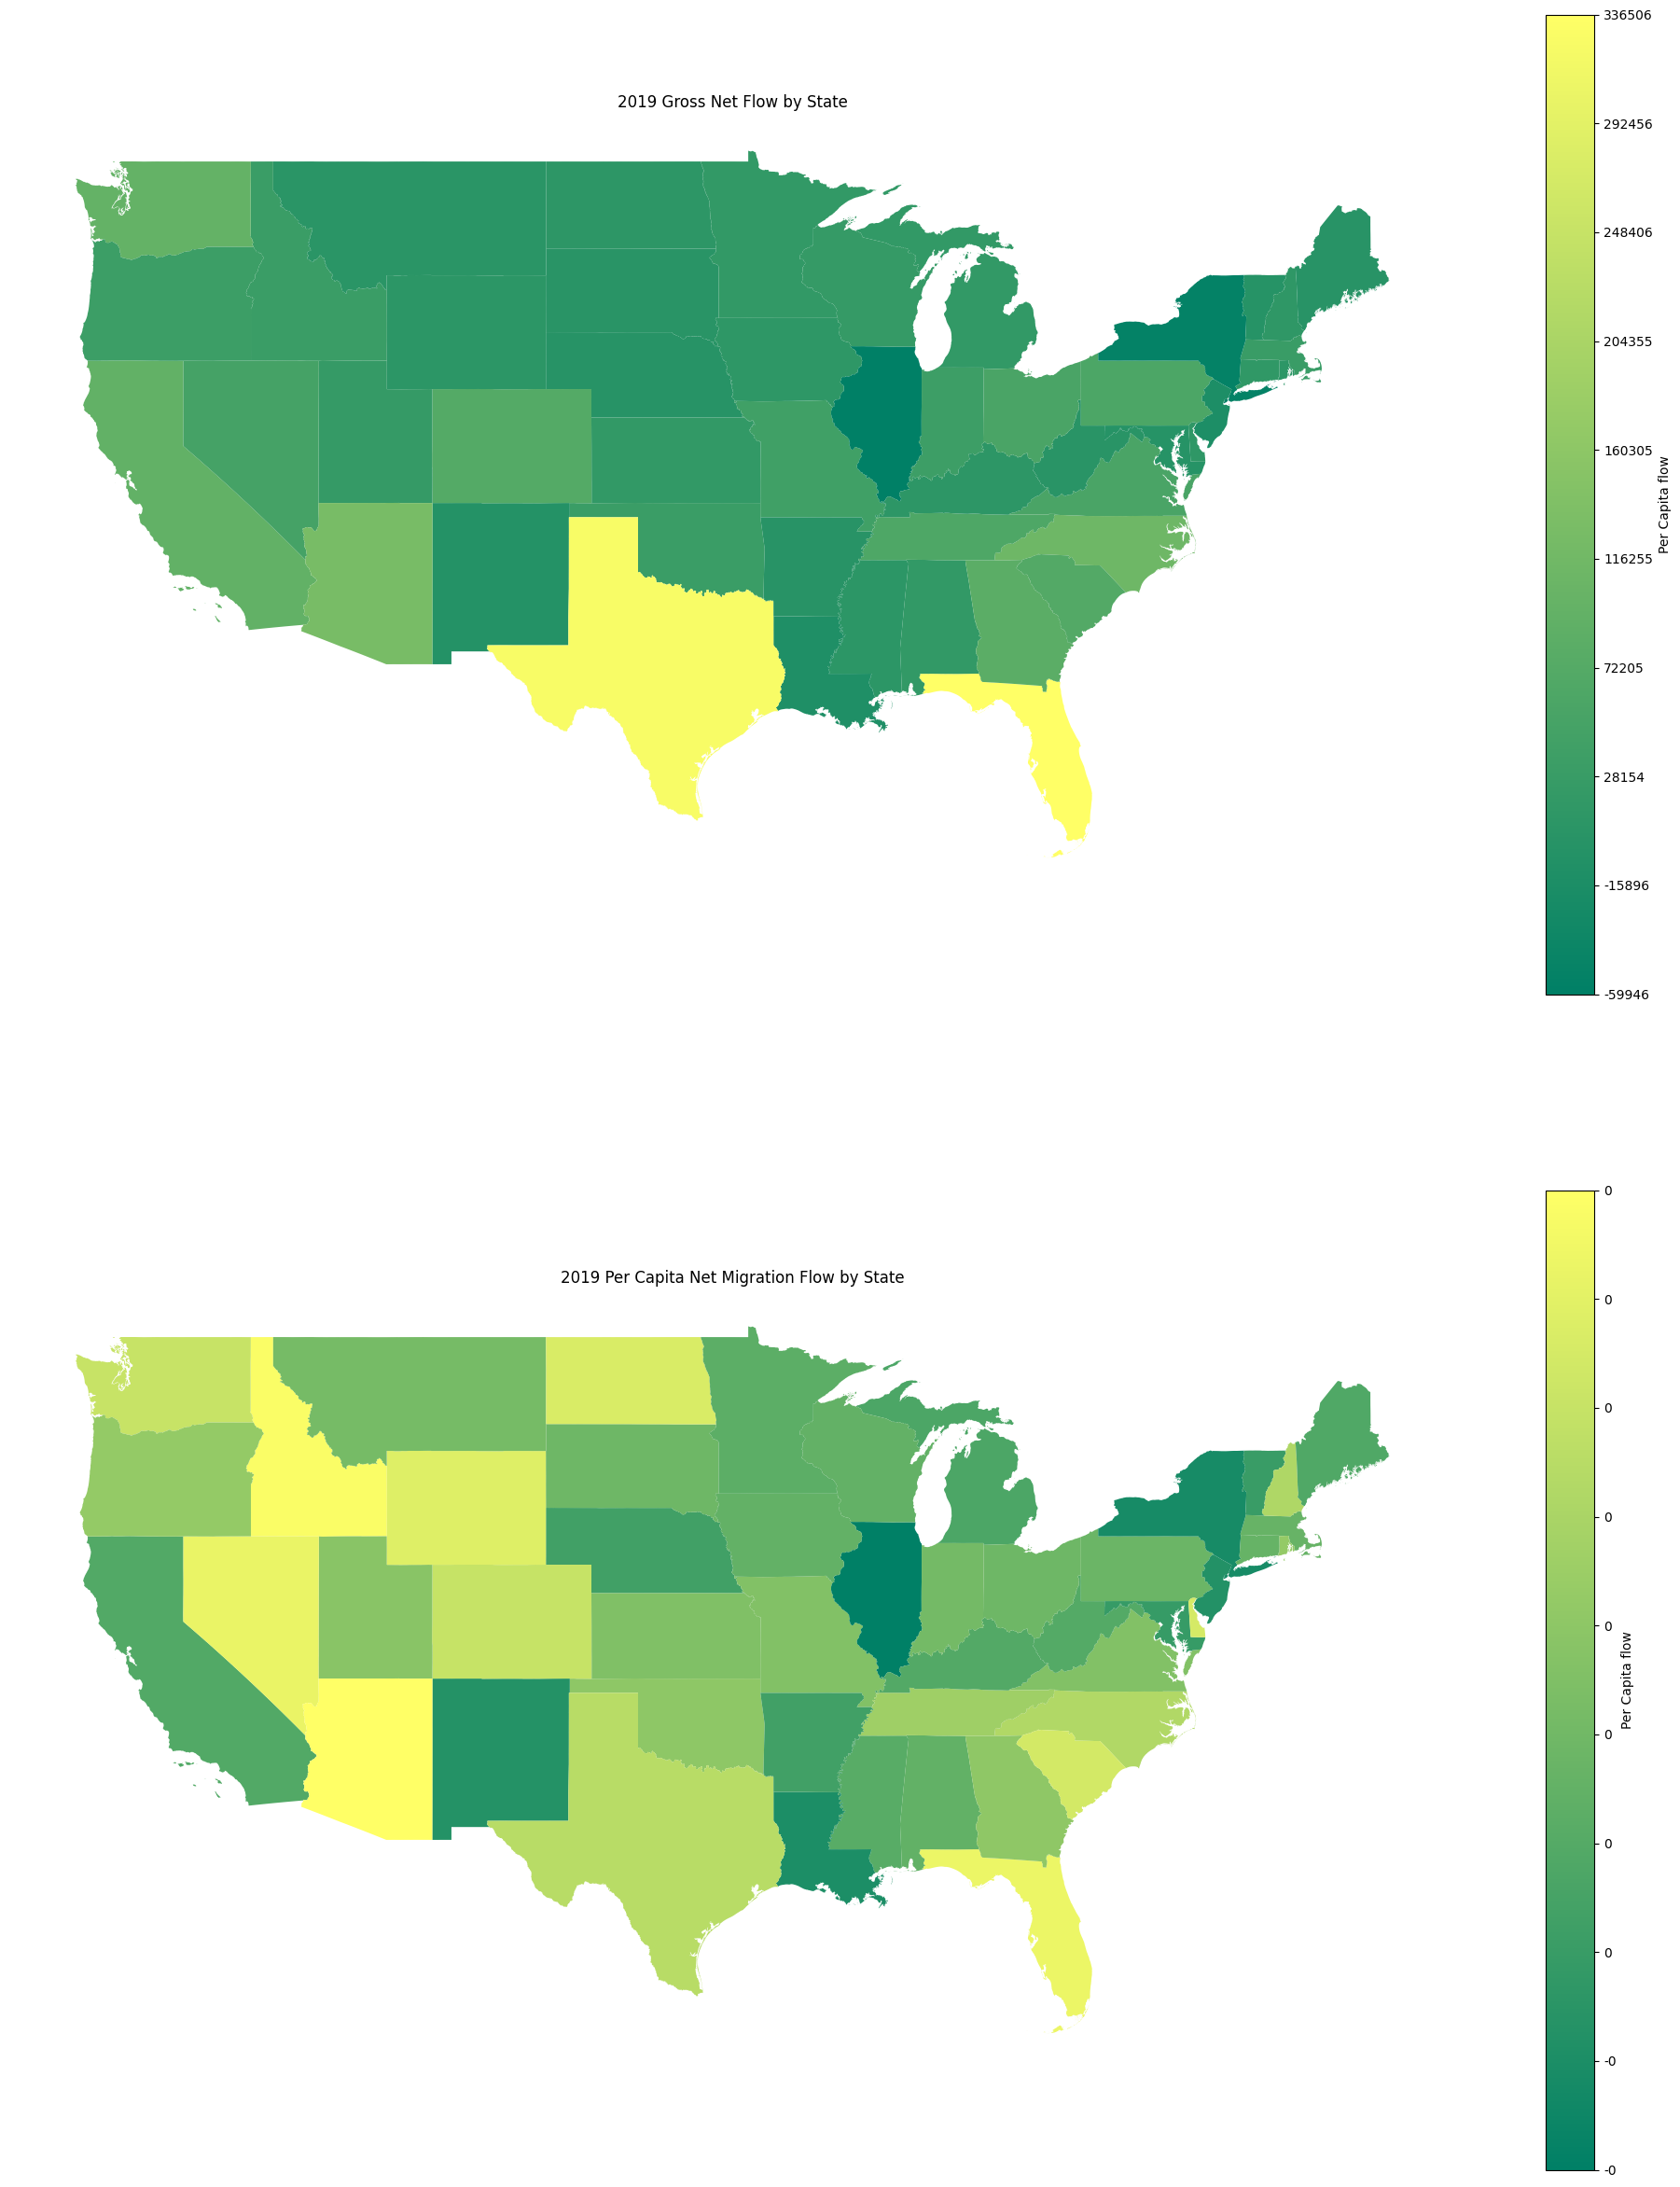

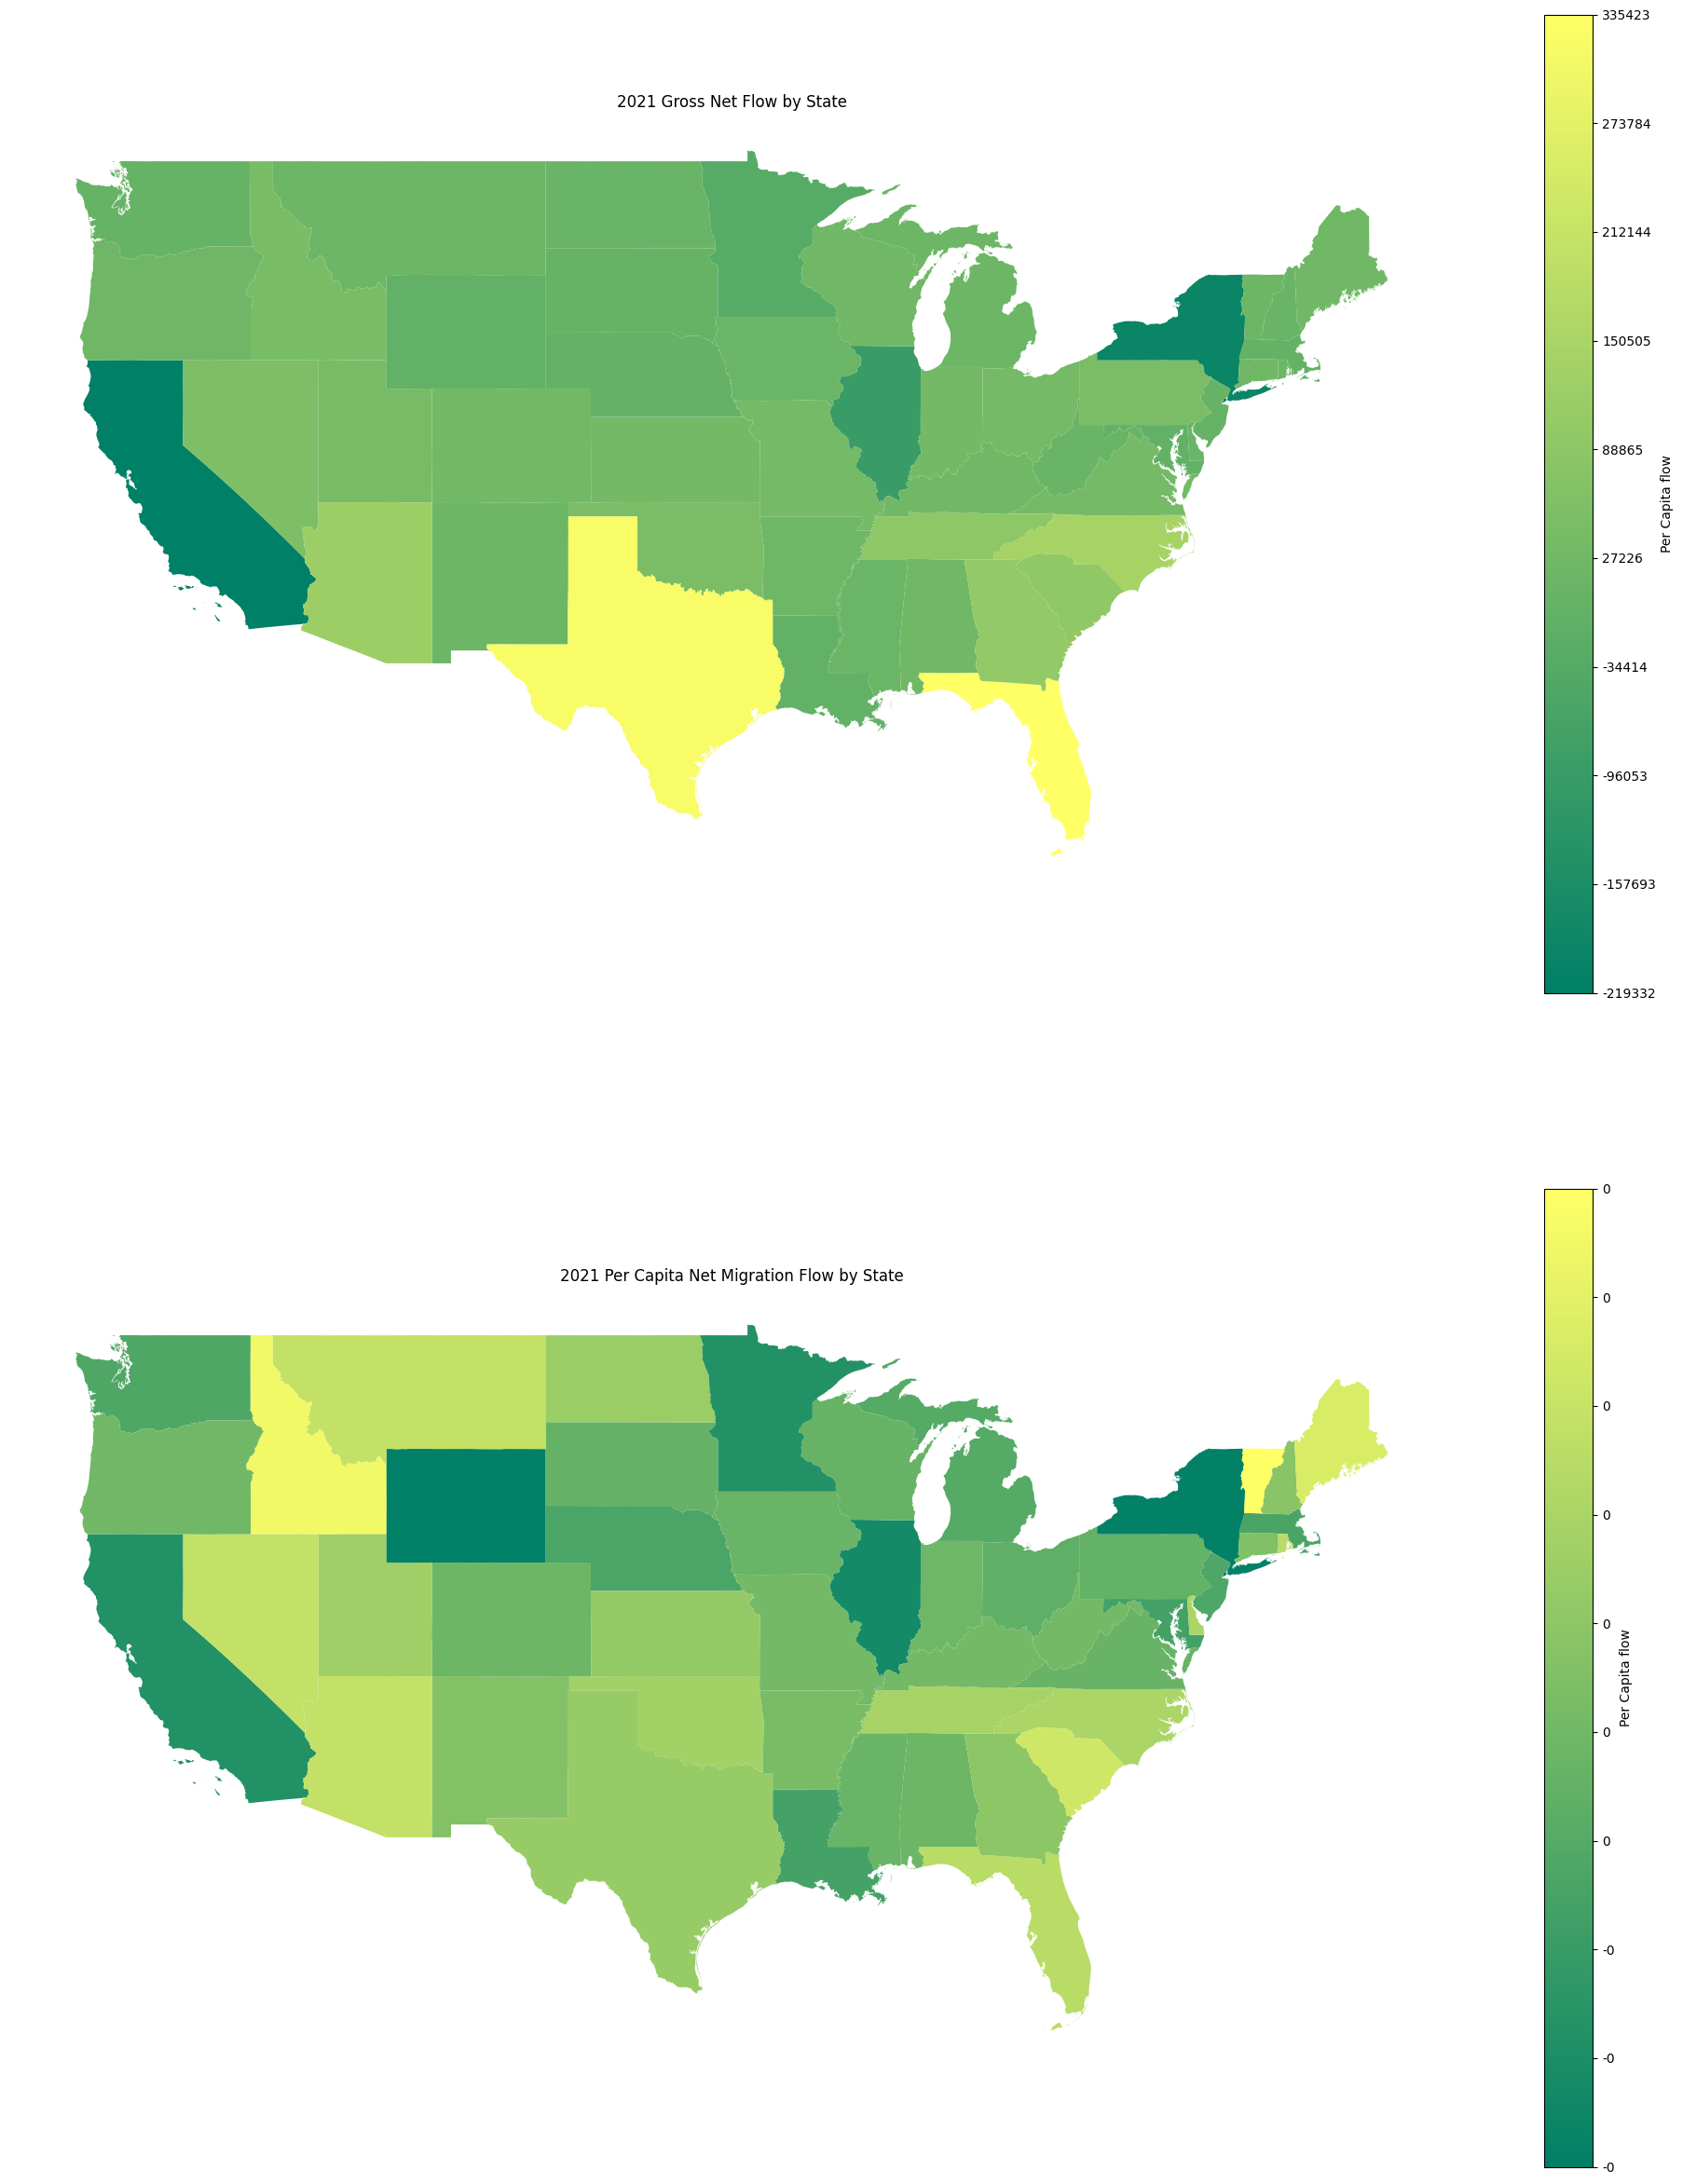

In [84]:
for filename in os.listdir(f"{root}/Data/State"):
    if filename.endswith('.xls'):
        print(f"processing {filename}")
        name, _ = os.path.splitext(filename)
        year = name.split('_')[-1]
        data_path = f"{root}/Data/State/{filename}"
        save_path = f"{root}/Figures/State EDA/{year} netflow.png"
        plot_heat(data_path, save_path)